# Исследование факторов ДТП по регионам РФ

## Вступление

ДТП - является одной из частых причин инвалидизации и преждевременной смерти среди трудоспособного населения. Затраты, связанные с ликвидацией последствий ДТП, достигают до 3% внутреннего валового продукта страны.
Вашему вниманию представлен baseline для выгрузки и дальнейшего анализа данных по ДТП с 2015 по 2023 годы, 2024 до февраля.

Файлы находятся [тут](https://dtp-stat.ru/opendata) в формате geojson.
Ниже представлена структура файлов. Для рассмотрения возьму  18 субъектов Центрального округа РФ вместе с Москвой.

## Задача
Провести глубокий анализ данных, формулировка и проверка гипотез, опираясь на доступные признаки


# Оглавление
* [Шаг 1.Подготовка и очистка данных](#Шаг_1.Подготовка_и_очистка_данных)
   
* [Шаг 2.Исследовательский анализ данных](#Шаг_2.Исследовательский_анализ_данных)
            
* [Шаг 3. Статистический анализ данных](#Шаг_3._Статистический_анализ_данных)
    * [Шаг 3.1 Гипотезы по Женщинам](#Шаг_3.1_Гипотезы_по_женщинам)
    * [Шаг 3.2 Гипотезы по Мужчинам](#Шаг_3.2_Гипотезы_по_Мужчинам)
    * [Шаг 3.3 Гипотезы о Мужчинах и Женщинах](#Шаг_3.3_Гипотезы_о_Мужчинах_и_Женщинах)
    * [Шаг 3.4 Гипотеза о пешеходах](#Шаг_3.4_Гипотеза_о_пешеходах)
    * [Шаг 3.5 Гипотезы о безопасности в городах](#Шаг3.5_Гипотезы_о_безопасности_в_городах)
* [Шаг 4. Выводы](#Шаг4._Выводы:)
    * [Шаг 4.1 Выводы подробнее](#Шаг_4.1_Выводы_подробнее)
* [Шаг5. Ссылка на дашборд](#Шаг5._Ссылка_на_дашборд)
    

# Шаг 1.Подготовка и очистка данных <a class="anchor" id="Шаг_1.Подготовка_и_очистка_данных"></a>

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import requests
import json
from bs4 import BeautifulSoup
import warnings
import re
import math as mth
from scipy import stats as st
warnings.filterwarnings("ignore")

In [2]:
#сайт с нашими данными
url = 'https://dtp-stat.ru/opendata'
#отправка запроса на получение ресурса
res = requests.get(url)
#получим статус
res.status_code

200

In [3]:
#получим с сайта  документ в виде вложенной структуры данных
soup = BeautifulSoup (res.text, 'html.parser')
#получим список ссылок на все *.geojson файлы
link = soup.find_all('a', href=re.compile(".{1,}\.geojson"))
#получим первый датафрейм
df = gpd.read_file(link[4].get('href'))

#создадим один датафрейм из 18 субъектов Центрального округа РФ
#(у меня заняло это около 10 минут)

numbers = [5,6,9,12,16,21,25,27,29,30,38,61,68,70,71,73,84]
for i in numbers:
    gdf = gpd.read_file(link[i].get('href'))
    df = pd.concat([df, gdf], axis=0)


In [4]:
#выведем первые пять строк
pd.set_option('display.max_columns',None)


df.head()

id                                 tags  \
0  2700162  [Дорожно-транспортные происшествия]   
1  2810534  [Дорожно-транспортные происшествия]   
2  2797373  [Дорожно-транспортные происшествия]   
3  2797385  [Дорожно-транспортные происшествия]   
4  2797406  [Дорожно-транспортные происшествия]   

                                      light  \
0                       Светлое время суток   
1                       Светлое время суток   
2  В темное время суток, освещение включено   
3  В темное время суток, освещение включено   
4                       Светлое время суток   

                                   point  \
0  {'lat': 50.581711, 'long': 36.546707}   
1  {'lat': 50.592862, 'long': 36.592062}   
2   {'lat': 50.56623, 'long': 36.570654}   
3  {'lat': 50.602335, 'long': 36.590395}   
4   {'lat': 50.64927, 'long': 36.567028}   

                                              nearby    region scheme  \
0  [Жилые дома индивидуальной застройки, Регулиру...  Белгород    070   
1  [Многоквартирные жилые дома, Мост, эстакада, п...  Белгород    040   
2  [Многоквартирные жилые дома, Административные ...  Белгород    500   
3  [Многоквартирные жилые дома, Крупный торговый ...  Белгород    300   
4              [Выезд с прилегающей территории, АЗС]  Белгород    030   

                                           address     weather      category  \
0              г Белгород, ул Красноармейская, 67а      [Ясно]  Столкновение   
1  г Белгород, пр-кт Ватутина, Д.3 ул. Харьковская  [Снегопад]  Столкновение   
2                    г Белгород, ул Губкина, Щорса      [Ясно]  Столкновение   
3           г Белгород, пр-кт Белгородский, Попова      [Ясно]  Столкновение   
4           г Белгород, пр-кт Б.Хмельницкого, 205б      [Ясно]  Столкновение   

             datetime severity  \
0 2022-05-14 16:30:00  Тяжёлый   
1 2023-02-03 12:50:00   Легкий   
2 2023-01-25 22:20:00   Легкий   
3 2023-01-25 22:45:00   Легкий   
4 2023-01-23 11:07:00   Легкий   

                                            vehicles  dead_count participants  \
0  [ { "year": 2009, "brand": "ВАЗ", "color": "Се...           0          [ ]   
1  [ { "year": 2011, "brand": "NISSAN", "color": ...           0          [ ]   
2  [ { "year": 2011, "brand": "CHEVROLET", "color...           0          [ ]   
3  [ { "year": 2009, "brand": "RENAULT", "color":...           0          [ ]   
4  [ { "year": 2019, "brand": "VOLKSWAGEN", "colo...           0          [ ]   

   injured_count         parent_region  \
0              1  Белгородская область   
1              2  Белгородская область   
2              2  Белгородская область   
3              2  Белгородская область   
4              1  Белгородская область   

                                 road_conditions  participants_count  \
0                                        [Сухое]                   3   
1  [Обработанное противогололедными материалами]                   4   
2                                        [Сухое]                   3   
3                                        [Сухое]                   2   
4                                        [Сухое]                   3   

  participant_categories                   geometry  
0        [Все участники]  POINT (36.54671 50.58171)  
1        [Все участники]  POINT (36.59206 50.59286)  
2        [Все участники]  POINT (36.57065 50.56623)  
3        [Все участники]  POINT (36.59040 50.60233)  
4        [Все участники]  POINT (36.56703 50.64927)

In [5]:
# Создадим функция для исследования данных.

def first_look_data(data):
    display(data.head())
    print('Колонки')
    print(data.columns)
#     Данный print позволяет красиво выделять данные,

    print(50*'-')
    print('Содержимое колонок')
    print(20*'*')

    for col in data:
        print(col)
# Не все колонки могут быть прочитаны
# unique и nunique
        try:
            print(data[col].unique())
            print(data[col].nunique())


        except TypeError:
            print('Списковое исключение')

            print(data[col][:5])



        print(20*'*')
    print('Общая информация')
    print(data.info())

    print(50*"-")
    print('Пропуски')
    print(data.isna().sum())
    print(50*"-")

In [6]:
first_look_data(df)

id                                 tags  \
0  2700162  [Дорожно-транспортные происшествия]   
1  2810534  [Дорожно-транспортные происшествия]   
2  2797373  [Дорожно-транспортные происшествия]   
3  2797385  [Дорожно-транспортные происшествия]   
4  2797406  [Дорожно-транспортные происшествия]   

                                      light  \
0                       Светлое время суток   
1                       Светлое время суток   
2  В темное время суток, освещение включено   
3  В темное время суток, освещение включено   
4                       Светлое время суток   

                                   point  \
0  {'lat': 50.581711, 'long': 36.546707}   
1  {'lat': 50.592862, 'long': 36.592062}   
2   {'lat': 50.56623, 'long': 36.570654}   
3  {'lat': 50.602335, 'long': 36.590395}   
4   {'lat': 50.64927, 'long': 36.567028}   

                                              nearby    region scheme  \
0  [Жилые дома индивидуальной застройки, Регулиру...  Белгород    070   
1  [Многоквартирные жилые дома, Мост, эстакада, п...  Белгород    040   
2  [Многоквартирные жилые дома, Административные ...  Белгород    500   
3  [Многоквартирные жилые дома, Крупный торговый ...  Белгород    300   
4              [Выезд с прилегающей территории, АЗС]  Белгород    030   

                                           address     weather      category  \
0              г Белгород, ул Красноармейская, 67а      [Ясно]  Столкновение   
1  г Белгород, пр-кт Ватутина, Д.3 ул. Харьковская  [Снегопад]  Столкновение   
2                    г Белгород, ул Губкина, Щорса      [Ясно]  Столкновение   
3           г Белгород, пр-кт Белгородский, Попова      [Ясно]  Столкновение   
4           г Белгород, пр-кт Б.Хмельницкого, 205б      [Ясно]  Столкновение   

             datetime severity  \
0 2022-05-14 16:30:00  Тяжёлый   
1 2023-02-03 12:50:00   Легкий   
2 2023-01-25 22:20:00   Легкий   
3 2023-01-25 22:45:00   Легкий   
4 2023-01-23 11:07:00   Легкий   

                                            vehicles  dead_count participants  \
0  [ { "year": 2009, "brand": "ВАЗ", "color": "Се...           0          [ ]   
1  [ { "year": 2011, "brand": "NISSAN", "color": ...           0          [ ]   
2  [ { "year": 2011, "brand": "CHEVROLET", "color...           0          [ ]   
3  [ { "year": 2009, "brand": "RENAULT", "color":...           0          [ ]   
4  [ { "year": 2019, "brand": "VOLKSWAGEN", "colo...           0          [ ]   

   injured_count         parent_region  \
0              1  Белгородская область   
1              2  Белгородская область   
2              2  Белгородская область   
3              2  Белгородская область   
4              1  Белгородская область   

                                 road_conditions  participants_count  \
0                                        [Сухое]                   3   
1  [Обработанное противогололедными материалами]                   4   
2                                        [Сухое]                   3   
3                                        [Сухое]                   2   
4                                        [Сухое]                   3   

  participant_categories                   geometry  
0        [Все участники]  POINT (36.54671 50.58171)  
1        [Все участники]  POINT (36.59206 50.59286)  
2        [Все участники]  POINT (36.57065 50.56623)  
3        [Все участники]  POINT (36.59040 50.60233)  
4        [Все участники]  POINT (36.56703 50.64927)

Колонки
Index(['id', 'tags', 'light', 'point', 'nearby', 'region', 'scheme', 'address',
       'weather', 'category', 'datetime', 'severity', 'vehicles', 'dead_count',
       'participants', 'injured_count', 'parent_region', 'road_conditions',
       'participants_count', 'participant_categories', 'geometry'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2700162 2810534 2797373 ... 1867222 1874000 1867695]
350384
********************
tags
Списковое исключение
0    [Дорожно-транспортные происшествия]
1    [Дорожно-транспортные происшествия]
2    [Дорожно-транспортные происшествия]
3    [Дорожно-транспортные происшествия]
4    [Дорожно-транспортные происшествия]
Name: tags, dtype: object
********************
light
['Светлое время суток' 'В темное время суток, освещение включено'
 'Сумерки' 'В темное время суток, освещение отсутствует'
 'В темное время суток, освещение не включено' 'Не установлено']
6
****************

In [7]:
#выведем доли  пропусков в значениях
print(round(df.isna().sum()/len(df)*100, 1))

id                        0.0
tags                      0.0
light                     0.0
point                     0.0
nearby                    0.0
region                    0.0
scheme                    4.8
address                   4.8
weather                   0.0
category                  0.0
datetime                  0.0
severity                  0.0
vehicles                  0.0
dead_count                0.0
participants              0.0
injured_count             0.0
parent_region             0.0
road_conditions           0.0
participants_count        0.0
participant_categories    0.0
geometry                  0.5
dtype: float64


In [8]:
#проверим на наличие явных дубликатов
print('Количество дубликатов  по id:', df['id'].duplicated().sum())

Количество дубликатов  по id: 0


Отметим, что в открытой таблице больше трехсот тысяч строк и 21 столбец, есть пропуски в столбцах - scheme, address и geometry, эти столбцы можно удалить,т.к. не нужны для дальнейшего исследования, а в адресах нет единого заполнения тем более. Все столбцы в нужном типе данных, есть те, которые необходимо раскрыть  в отдельную таблицу -  vehicles, participants. Также в столбцах значения в виде списков.

In [4]:
#добавим столбец год ДТП
df['year'] = df['datetime'].dt.year
df['year'].sort_values().value_counts()

year
2015    47627
2016    43038
2017    41961
2018    40975
2019    40882
2020    35656
2021    34137
2023    31159
2022    29963
2024     7434
Name: count, dtype: int64

In [5]:
#добавим столбец год-месяц ДТП
df['data'] = pd.to_datetime(df['datetime']).dt.strftime('%Y-%m')
df['data'].sort_values().value_counts()

data
2015-08    4845
2015-09    4463
2015-12    4452
2016-08    4424
2015-07    4421
           ... 
2024-01    1812
2022-02    1653
2024-02    1644
2024-03    1639
2020-04    1486
Name: count, Length: 112, dtype: int64

Для дальнейшей работы и анализа создадим отдельно столбец с годом и столбец Месяц Год.

In [6]:
#обрежем таблицу до февраля 2024 г
df = df.loc[df['data']<='2024-02']
df['data'].sort_values().value_counts()

data
2015-08    4845
2015-09    4463
2015-12    4452
2016-08    4424
2015-07    4421
           ... 
2023-02    1876
2024-01    1812
2022-02    1653
2024-02    1644
2020-04    1486
Name: count, Length: 110, dtype: int64

т.к. работа выполнялась, когда данные на сайте были до февраля 2024 года, а они постоянно обновляются, поэтому обрежем таблицу по эти данные.

In [7]:
#создадим столбец, содержащий 1, если категория участников содержит Дети
df['baby'] = np.where(df['participant_categories'].str.contains("Дети", regex=False), 1,0)
df['baby'].value_counts()

baby
0    318058
1     30796
Name: count, dtype: int64

Добавим для удобства исследования столбец где аварии, в которой есть участники дети. Где значение 1 указывает на участие ребенка в ДТП.

In [8]:
#сократим название значения в колонке роль
df['category']= \
df['category'].\
replace('Возгорание вследствие технической неисправности движущегося или остановившегося ТС, участвующего в дорожном движении.',\
        'Возгорание по технической неисправности ТС')
df['category']= \
df['category'].\
replace('Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ',\
        'Наезд на лицо, осуществляющее работы')
df['category']= \
df['category'].\
replace('Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы',\
        'Наезд на лицо, осуществляющее несение службы')
df['category']= \
df['category'].\
replace('Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность',\
        'Наезд на лицо, осуществляющее иную деятельность')
df.explode('category')['category'].unique()

array(['Столкновение', 'Наезд на пешехода', 'Наезд на велосипедиста',
       'Наезд на препятствие', 'Падение пассажира', 'Наезд на стоящее ТС',
       'Съезд с дороги', 'Опрокидывание',
       'Наезд на лицо, осуществляющее работы',
       'Наезд на лицо, осуществляющее несение службы',
       'Отбрасывание предмета', 'Иной вид ДТП',
       'Наезд на лицо, осуществляющее иную деятельность',
       'Наезд на животное', 'Наезд на внезапно возникшее препятствие',
       'Наезд на гужевой транспорт', 'Падение груза',
       'Возгорание по технической неисправности ТС'], dtype=object)

In [9]:
# добавим функцию для открытия и нормализации столбцов внутри датасета

def normalize_json_to_data(data, col):
    """Функция раскладывает и нормализует
    json столбцы в датасет по id.
    """

    data_out = pd.json_normalize(data.explode(col)[col])


#     Все таблицы связаны между собой через id родительской таблицы.

    data_out = pd.concat([
        pd.DataFrame(data.explode(col)['id'].values, columns=['id']),
        data_out
    ],
                            axis=1)
    return data_out

In [10]:
#приведем столбец к виду json
df['vehicles'] = df['vehicles'].apply(json.loads)
df['participants'] = df['participants'].apply(json.loads)

In [11]:
# Датафрейм для машин.

df_vehicles = normalize_json_to_data(df, 'vehicles').reset_index(drop=True)

# Датафрейм для пассажиров машин.

df_vehicles_participants = normalize_json_to_data(
    df_vehicles, 'participants').reset_index(drop=True)

# Датафрейм для пешеходов.
# Дополнительно удалим все пустые строки, так как там нет пешеходов.
df_footer = normalize_json_to_data(
    df, 'participants').dropna().reset_index(drop=True)

In [18]:
first_look_data(df_vehicles)

id    year       brand  color                   model  \
0  2700162  2009.0         ВАЗ  Серый  ВАЗ 2114 и модификации   
1  2700162  2007.0         ВАЗ  Серый  ВАЗ 2114 и модификации   
2  2810534  2011.0      NISSAN  Серый                    Juke   
3  2810534  2001.0  VOLKSWAGEN  Синий                    Golf   
4  2810534  2011.0     PEUGEOT  Белый   Прочие модели Peugeot   

                                       category  \
0                    Прочие легковые автомобили   
1                      В-класс (малый) до 3,9 м   
2  С-класс (малый средний, компактный) до 4,3 м   
3                    Прочие легковые автомобили   
4                    Прочие легковые автомобили   

                                        participants  
0  [{'role': 'Водитель', 'gender': 'Мужской', 'vi...  
1  [{'role': 'Водитель', 'gender': 'Мужской', 'vi...  
2  [{'role': 'Водитель', 'gender': 'Женский', 'vi...  
3  [{'role': 'Водитель', 'gender': 'Женский', 'vi...  
4  [{'role': 'Водитель', 'gender': 'Женский', 'vi...

Колонки
Index(['id', 'year', 'brand', 'color', 'model', 'category', 'participants'], dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2700162 2810534 2797373 ... 1867222 1874000 1867695]
348745
********************
year
[2.009e+03 2.007e+03 2.011e+03 2.001e+03 2.012e+03 2.017e+03 2.018e+03
 2.019e+03 2.004e+03 2.005e+03 2.000e+03 2.006e+03 2.014e+03 1.991e+03
 2.002e+03 2.013e+03 2.008e+03 1.998e+03 2.015e+03 2.020e+03 2.016e+03
       nan 1.985e+03 2.010e+03 1.999e+03 1.995e+03 2.003e+03 1.984e+03
 2.021e+03 1.994e+03 1.996e+03 1.997e+03 1.990e+03 1.980e+03 1.989e+03
 1.993e+03 2.022e+03 1.987e+03 1.988e+03 1.992e+03 2.023e+03 1.978e+03
 1.981e+03 1.986e+03 1.979e+03 1.983e+03 1.961e+03 1.977e+03 1.982e+03
 1.974e+03 1.976e+03 1.975e+03 1.967e+03 1.972e+03 1.973e+03 1.971e+03
 1.968e+03 1.964e+03 1.000e+00 1.970e+03 1.965e+03 1.962e+03 1.969e+03
 1.960e+03 1.957e+03 1.923e+03 1.959e+03 1.952e+03 1.963e+03 1.966e+03
 1.956e+

Есть пропуски в датасете, нам будут особенно интересно категоризировать столбец category. И расскрыть внутри таблицу participants.

In [19]:
first_look_data(df_vehicles_participants)

id      role   gender  \
0  2700162  Водитель  Мужской   
1  2700162  Водитель  Мужской   
2  2700162  Пассажир  Женский   
3  2810534  Водитель  Женский   
4  2810534  Водитель  Женский   

                                          violations  \
0  [Неправильный выбор дистанции, Управление тран...   
1                                                 []   
2                                                 []   
3                    [Нарушение правил перестроения]   
4                                                 []   

                                       health_status  \
0                                       Не пострадал   
1                                       Не пострадал   
2  Раненый, находящийся (находившийся) на стацион...   
3  Раненый, находящийся (находившийся) на амбулат...   
4                                       Не пострадал   

   years_of_driving_experience  
0                          7.0  
1                         25.0  
2                          NaN  
3                         10.0  
4                         15.0

Колонки
Index(['id', 'role', 'gender', 'violations', 'health_status',
       'years_of_driving_experience'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2700162 2810534 2797373 ... 1867222 1874000 1867695]
348745
********************
role
['Водитель' 'Пассажир' 'Велосипедист' nan 'Пешеход']
4
********************
gender
['Мужской' 'Женский' None nan]
2
********************
violations
Списковое исключение
0    [Неправильный выбор дистанции, Управление тран...
1                                                   []
2                                                   []
3                      [Нарушение правил перестроения]
4                                                   []
Name: violations, dtype: object
********************
health_status
['Не пострадал'
 'Раненый, находящийся (находившийся) на стационарном лечении'
 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара

In [20]:
first_look_data(df_footer)

id     role   gender violations  \
0  2797424  Пешеход  Женский         []   
1  2797432  Пешеход  Женский         []   
2  1580387  Пешеход  Женский         []   
3  2554505  Пешеход  Женский         []   
4  1581130  Пешеход  Мужской         []   

                                       health_status  
0  Раненый, находящийся (находившийся) на стацион...  
1  Раненый, находящийся (находившийся) на амбулат...  
2  Раненый, находящийся (находившийся)  на амбула...  
3  Раненый, находящийся (находившийся) на амбулат...  
4  Раненый, находящийся (находившийся)  на амбула...

Колонки
Index(['id', 'role', 'gender', 'violations', 'health_status'], dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2797424 2797432 1580387 ... 1866433 1871694 1873491]
99446
********************
role
['Пешеход'
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира'
 'Водитель' 'Пассажир']
4
********************
gender
['Женский' 'Мужской']
2
********************
violations
Списковое исключение
0    []
1    []
2    []
3    []
4    []
Name: violations, dtype: object
********************
health_status
['Раненый, находящийся (находившийся) на стационарном лечении'
 'Раненый, находящийся (находившийся) на амбулаторном лечении, либо в условиях дневного стационара'
 'Раненый, находящийся (находившийся)  на амбулаторном лечении, либо которому по характеру полученных травм обозначена необходимость амбулаторного лечения (вне зависимости от его фактическо

В данном датасете пропусков нет. Интересно рассмотреть все столбцы и категоризировать столбец с состоянием здоровья.

In [12]:
# Удяляем участников в транспортном средстве.
df_vehicles.drop(['participants'],axis=1,inplace = True)
df_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567938 entries, 0 to 567937
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        567938 non-null  int64  
 1   year      544027 non-null  float64
 2   brand     546948 non-null  object 
 3   color     554550 non-null  object 
 4   model     546940 non-null  object 
 5   category  565193 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 26.0+ MB


In [13]:
#  Объединим таблицы df_footer и df_vehicles_participants
df_foot_part = pd.concat([df_vehicles_participants,df_footer]).copy().reset_index(drop=True)

In [23]:
first_look_data(df_foot_part)

id      role   gender  \
0  2700162  Водитель  Мужской   
1  2700162  Водитель  Мужской   
2  2700162  Пассажир  Женский   
3  2810534  Водитель  Женский   
4  2810534  Водитель  Женский   

                                          violations  \
0  [Неправильный выбор дистанции, Управление тран...   
1                                                 []   
2                                                 []   
3                    [Нарушение правил перестроения]   
4                                                 []   

                                       health_status  \
0                                       Не пострадал   
1                                       Не пострадал   
2  Раненый, находящийся (находившийся) на стацион...   
3  Раненый, находящийся (находившийся) на амбулат...   
4                                       Не пострадал   

   years_of_driving_experience  
0                          7.0  
1                         25.0  
2                          NaN  
3                         10.0  
4                         15.0

Колонки
Index(['id', 'role', 'gender', 'violations', 'health_status',
       'years_of_driving_experience'],
      dtype='object')
--------------------------------------------------
Содержимое колонок
********************
id
[2700162 2810534 2797373 ... 1867222 1874000 1867695]
348745
********************
role
['Водитель' 'Пассажир' 'Велосипедист' nan 'Пешеход'
 'Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира']
5
********************
gender
['Мужской' 'Женский' None nan]
2
********************
violations
Списковое исключение
0    [Неправильный выбор дистанции, Управление тран...
1                                                   []
2                                                   []
3                      [Нарушение правил перестроения]
4                                                   []
Name: violations, dtype: object
********************
health_status
['Не пострадал'
 'Раненый, находящийся (наход

Есть пропуски по роли и полу. По стажу вождения -ожидаемы пропуски, потому что есть не только водители в таблице.

In [14]:
#создадим столбец, содержащий 1, если статус здоровья содержит Скончался
df_foot_part['dead'] = np.where(df_foot_part['health_status'].str.contains("Скончался"), 1,0)
df_foot_part['dead'].value_counts()

dead
0    810268
1     41219
Name: count, dtype: int64

В таблице с участниками имеются пропуски в роли и пол участника, далее можно будет изучить к какому больше году это относится,т.к. есть информация, что до 2018 года заполнение всех пунктов сотрудниками ГИБДД было не полное, можно сказать, что учились еще все правильно вбивать.

In [15]:
#создадим столбец, содержащий 1, если нарушение есть
df_foot_part['category_violations'] = np.where(df_foot_part['violations'].str.len() < 1, 0,1)
df_foot_part['category_violations'].value_counts()

category_violations
0    443937
1    407550
Name: count, dtype: int64

В датафрейме нарушающих и не нарушающих участников почти поровну. Учли Погибших, которые скончались даже через несколько дней, и общее их число составило 41213 человека.

In [16]:
#сократим название значения в колонке роль
df_foot_part['role']= \
df_foot_part['role'].\
replace('Пешеход, перед ДТП находившийся в (на) ТС в качестве водителя или пешеход, перед ДТП находившийся в (на) ТС в качестве пассажира',\
        'Пешеход-Водитель(Пассажир)')
df_foot_part['role'].value_counts()

role
Водитель                      551691
Пассажир                      178930
Пешеход                       102894
Велосипедист                   12733
Пешеход-Водитель(Пассажир)      2494
Name: count, dtype: int64

In [17]:
#удалим столбцы со схемами и адресами
df.drop(['scheme','address','point','geometry'],axis=1, inplace = True)
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 348854 entries, 0 to 16118
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      348854 non-null  int64         
 1   tags                    348854 non-null  object        
 2   light                   348854 non-null  object        
 3   nearby                  348854 non-null  object        
 4   region                  348854 non-null  object        
 5   weather                 348854 non-null  object        
 6   category                348854 non-null  object        
 7   datetime                348854 non-null  datetime64[ns]
 8   severity                348854 non-null  object        
 9   vehicles                348854 non-null  object        
 10  dead_count              348854 non-null  int64         
 11  participants            348854 non-null  object        
 12  injured_count           3488

In [18]:
#добавим в таблицу год и регион, города, дату и участие детей для дальнейшего исследования
df_foot_part = pd.merge(df_foot_part, df[['id', 'year','parent_region', 'baby','data','region', 'severity']], on='id')
df_foot_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851487 entries, 0 to 851486
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           851487 non-null  int64  
 1   role                         848742 non-null  object 
 2   gender                       831329 non-null  object 
 3   violations                   848742 non-null  object 
 4   health_status                847394 non-null  object 
 5   years_of_driving_experience  501719 non-null  float64
 6   dead                         851487 non-null  int64  
 7   category_violations          851487 non-null  int64  
 8   year                         851487 non-null  int32  
 9   parent_region                851487 non-null  object 
 10  baby                         851487 non-null  int64  
 11  data                         851487 non-null  object 
 12  region                       851487 non-null  object 
 13 

In [29]:
#выведем доли  пропусков в значениях роли по полу
print(round((df_foot_part[df_foot_part['gender'].isna()]['year'].value_counts()/
                                               len(df_foot_part['year']))*100, 2))

year
2018    0.49
2016    0.42
2017    0.40
2023    0.32
2015    0.30
2019    0.14
2021    0.10
2020    0.10
2022    0.06
2024    0.03
Name: count, dtype: float64


In [30]:
#выведем доли  пропусков в значениях роли по роли
print(round((df_foot_part[df_foot_part['role'].isna()]['year'].value_counts()/
                                               len(df_foot_part['year']))*100, 2))

year
2015    0.15
2016    0.13
2021    0.03
2023    0.00
2022    0.00
2020    0.00
2018    0.00
Name: count, dtype: float64


In [31]:
#выведем доли  пропусков в значениях роли по статусу здоровья
print(round(df_foot_part[df_foot_part['health_status'].isna()]['year'].value_counts()/
                                               len(df_foot_part['year'])*100, 2))

year
2015    0.18
2016    0.16
2017    0.10
2021    0.03
2023    0.00
2022    0.00
2020    0.00
2018    0.00
2019    0.00
Name: count, dtype: float64




Отметим, что больше всего пропусков в столбце роль в 2015 и 2016 годах, они составляют меньше одного процента от общего числа строк, поэтому можно будет удалить строки с пропусками в столбцах Роль и Нарушения. Также поступим с пропусками в столбце статус здоровья из-за малой доли пропущенных значений. Как видим, действительно пропуски связаны с годом, до 2018 года инспекторы вводили не правильно данные.

А вот распределение пропусков в столбце Пол несколько иное, в 2018 и 2017 больше всего, в каждом из году они имеются, но также малый имеют процент, чтобы как то могли повлиять на дальнейшее исследование. Воспользуемся и для этого столбца удалением строк с пропуском.


In [19]:
#удалим пропуски в столбцах Роль, Пол, Нарушения и Статус здоровья
df_foot_part.dropna(subset=['role', 'violations', 'gender', 'health_status'], inplace = True)
df_foot_part.isna().sum()

id                                  0
role                                0
gender                              0
violations                          0
health_status                       0
years_of_driving_experience    334576
dead                                0
category_violations                 0
year                                0
parent_region                       0
baby                                0
data                                0
region                              0
severity                            0
dtype: int64

In [20]:
def categorize_health(row):

    d =['стационара' , 'амбулаторном', 'кроме разовой']
    if 'Не пострадал'  in row:
        return  'Не пострадал'
    if 'Другое' in row:
        return 'Другое'
    if 'Скончался' in row:
        return 'Скончался'
    if 'амбулаторного' in row:
        return 'Раненый-Амбулаторное'
    for i in d:
        if i in row:
            return 'Стационар или Амбулаторное'
    if 'стационарном' in row:
        return 'Раненый-Стационар'
    if 'раненый не относится'  in row:
        return 'Травмы'



In [21]:
#выведем столбец категорий здоровья
df_foot_part['health_category'] = df_foot_part['health_status'].apply(categorize_health)
df_foot_part.drop('health_status',axis=1,inplace = True)
df_foot_part['health_category'].value_counts()

health_category
Не пострадал                  362281
Раненый-Амбулаторное          164049
Раненый-Стационар             145187
Стационар или Амбулаторное    113891
Скончался                      38039
Травмы                          7851
Name: count, dtype: int64

Отметим, что в таблице df_foot_part по статусу здоровья участники разделяются: больше всего Не пострадал - 362174, затем почти с одинаковым количеством людей раненные Раненый-Амбулаторное - 164049, Раненый-Стационар -145179, Стационар или Амбулаторное - 113769, и на 5 месте Скончался - 38033, и есть Травмы - 7829, которые не нуждаются в лечении.

In [22]:
def hurt_category(row):

    if 'или'  in row:
         return 1
    if 'Раненый' in row:
         return 1
    else:
         return 0

In [23]:
#выведем столбец с раненными
df_foot_part['hurt'] = df_foot_part['health_category'].apply(hurt_category)
df_foot_part['hurt'].value_counts()

hurt
1    423127
0    408171
Name: count, dtype: int64

В таблице df_foot_part почти поровну участников с ранением и без ранения.

In [24]:
#выведем процент пропусков в стаже водителей c участием детей
print('Процент пропусков в стаже водителей с участием детей:',
   round(df_foot_part.\
            query('role=="Водитель" & baby==1')['years_of_driving_experience'].isnull().sum()/\
                len(df_foot_part.query('role=="Водитель"')['years_of_driving_experience'])*100,2))

Процент пропусков в стаже водителей с участием детей: 0.83


In [38]:
#выведем первые 15 нарушения для водителя с участием детей и имеющим пропуск в стаже
df_foot_part.\
        loc[(df_foot_part['role']=="Водитель") & (df_foot_part['baby']==1) & (df_foot_part['years_of_driving_experience']\
                                                                                  .isna()==True)]['violations'].value_counts().head(15)

violations
[Управление ТС лицом, не имеющим права на управление ТС]                                                                                               255
[]                                                                                                                                                     240
[Управление ТС лицом, не имеющим права на управление ТС, Нарушение правил применения мотошлема]                                                        110
[Управление ТС лицом, не имеющим права на управление ТС, Другие нарушения ПДД водителем]                                                               103
[Нарушение правил расположения ТС на проезжей части, Управление ТС лицом, не имеющим права на управление ТС]                                            87
[Несоблюдение очередности проезда, Управление ТС лицом, не имеющим права на управление ТС]                                                              79
[Несоблюдение очередности проезда]                         

Заметим, что среди водителей, у которых есть пропуск в стаже вождения и ДТП с участием детей, имеются нарушения: Управление ТС лицом, не имеющим права на управление ТС. Процент таких 0.83 от всех аварий, и говорит, что среди них есть дети - водители, не имеющих прав вождения в принципе. Также пропуски у водителей также могут быть связаны с отсутствием прав. Поэтому эти пропуски можно заменить на 0 лет.

In [24]:
#заменим пропуске в стаже на 0 у водителей не имеющих прав
df_foot_part.\
        loc[(df_foot_part['role']=="Водитель")  & (df_foot_part['years_of_driving_experience']\
                                                    .isna()==True),'years_of_driving_experience'] = np.where(df_foot_part.\
        loc[(df_foot_part['role']=="Водитель")  & (df_foot_part['years_of_driving_experience']\
                                                    .isna()==True),'violations'].str.contains("не имеющим права"),0, df_foot_part.\
        loc[(df_foot_part['role']=="Водитель")  & (df_foot_part['years_of_driving_experience']\
                                                    .isna()==True),'years_of_driving_experience'])

In [40]:
#выведем процент пропусков в стаже водителей Женщин
print('Процент пропусков в стаже водителей Женщин:',
   round(df_foot_part.\
            query('role=="Водитель" & gender=="Женский" ')['years_of_driving_experience'].isnull().sum()/\
                len(df_foot_part.query('role=="Водитель" & gender=="Женский"')['years_of_driving_experience'])*100,2))

Процент пропусков в стаже водителей Женщин: 0.0


In [41]:
#выведем процент пропусков в стаже водителей Мужчин
print('Процент пропусков в стаже водителей Мужчин:',
   round(df_foot_part.\
            query('role=="Водитель" & gender=="Мужской"')['years_of_driving_experience'].isnull().sum()/\
                len(df_foot_part.query('role=="Водитель" & gender=="Мужской"')['years_of_driving_experience'])*100,2))

Процент пропусков в стаже водителей Мужчин: 0.0


Рассмотрели остальные пропуски в стаже у женщин и у женщин, после замены стажа водителей не имеющих прав на вождение ТС на НОЛь, пропусков больше нет.

In [25]:
#Создадим словарь для распределения авто по категориям
categories = {
    'Общественный': ['бусы', 'D-класс', 'Трамваи'],
    'Личный': [
        'легковые', 'В-класс', 'Минивэны и универсалы',
        'Спортивные (гоночные)', 'Автодома'
    ],
    'Велосипед_Самокат': [
        'елосипеды', 'мотоблоки', 'Мотоколяски',
        'электрическое средство передвижения'
    ],
    'Спец.техника': [
        'пециализиров', 'Автокраны', 'Тракторы', 'пецтехника',
        'Медицинские комплексы', 'Пожарные', 'Автобетоносмесители', 'амосвалы',
        'медицинской помощи', 'Боевая', 'дорожно-строительные',
        'Автоэвакуаторы', 'оснащенные подъемниками', 'денежной выручки',
        'Автоцементовозы', 'Бульдозеры', 'Автогудронаторы', 'Автобетононасосы'
    ],
    'Мотоцикл': [
        'цикл', 'А-класс', 'мототранспортные', 'Мопеды', 'Мотороллеры',
        'Снегоходы', 'Мототранспорт', 'Мотонарты, аэросани'
    ],
    'Грузовой': [
        'ярусные', 'С-класс', 'Фургоны', 'Седельные тягачи', 'рузовые',
        'этажные', 'S-класс', 'Е-класс', 'Рефрижераторы', 'Бортовые',
        'Цистерны', 'для перевозки', 'погрузчики', 'Автолесовозы',
        'нефтяных и газовых скважин'
    ]
}

#добавим функцию категоризации авто
def categorize_avto(row):
    for category, keywords in categories.items():
        if any(keyword in row for keyword in keywords):
            return category
    return 'Другое'


In [26]:
#заполним пустые строки на Другое и разобьем на категории
df_vehicles['category'] =df_vehicles['category'].fillna('Другое')
df_vehicles['avto_category'] = df_vehicles['category'].apply(categorize_avto)
df_vehicles.drop('category',axis=1,inplace = True)
df_vehicles['avto_category'].value_counts()


avto_category
Личный               250786
Грузовой             180855
Общественный          52871
Мотоцикл              47465
Велосипед_Самокат     13768
Спец.техника          13093
Другое                 9100
Name: count, dtype: int64

Отметим, что аварий с личным транспортом больше всего, на втором месте идет грузовой транспорт, в три раза меньше в авариях учавствует общественный транспорт и меньше всего участников на спец. технике и велосипеде.

In [27]:
#добавим в таблицу год и регион
df_vehicles = pd.merge(df_vehicles, df[['id', 'baby','dead_count', 'severity']], on='id')
df_vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567938 entries, 0 to 567937
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             567938 non-null  int64  
 1   year           544027 non-null  float64
 2   brand          546948 non-null  object 
 3   color          554550 non-null  object 
 4   model          546940 non-null  object 
 5   avto_category  567938 non-null  object 
 6   baby           567938 non-null  int64  
 7   dead_count     567938 non-null  int64  
 8   severity       567938 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 39.0+ MB


In [45]:
df.head()

id                                 tags  \
0  2700162  [Дорожно-транспортные происшествия]   
1  2810534  [Дорожно-транспортные происшествия]   
2  2797373  [Дорожно-транспортные происшествия]   
3  2797385  [Дорожно-транспортные происшествия]   
4  2797406  [Дорожно-транспортные происшествия]   

                                      light  \
0                       Светлое время суток   
1                       Светлое время суток   
2  В темное время суток, освещение включено   
3  В темное время суток, освещение включено   
4                       Светлое время суток   

                                              nearby    region     weather  \
0  [Жилые дома индивидуальной застройки, Регулиру...  Белгород      [Ясно]   
1  [Многоквартирные жилые дома, Мост, эстакада, п...  Белгород  [Снегопад]   
2  [Многоквартирные жилые дома, Административные ...  Белгород      [Ясно]   
3  [Многоквартирные жилые дома, Крупный торговый ...  Белгород      [Ясно]   
4              [Выезд с прилегающей территории, АЗС]  Белгород      [Ясно]   

       category            datetime severity  \
0  Столкновение 2022-05-14 16:30:00  Тяжёлый   
1  Столкновение 2023-02-03 12:50:00   Легкий   
2  Столкновение 2023-01-25 22:20:00   Легкий   
3  Столкновение 2023-01-25 22:45:00   Легкий   
4  Столкновение 2023-01-23 11:07:00   Легкий   

                                            vehicles  dead_count participants  \
0  [{'year': 2009, 'brand': 'ВАЗ', 'color': 'Серы...           0           []   
1  [{'year': 2011, 'brand': 'NISSAN', 'color': 'С...           0           []   
2  [{'year': 2011, 'brand': 'CHEVROLET', 'color':...           0           []   
3  [{'year': 2009, 'brand': 'RENAULT', 'color': '...           0           []   
4  [{'year': 2019, 'brand': 'VOLKSWAGEN', 'color'...           0           []   

   injured_count         parent_region  \
0              1  Белгородская область   
1              2  Белгородская область   
2              2  Белгородская область   
3              2  Белгородская область   
4              1  Белгородская область   

                                 road_conditions  participants_count  \
0                                        [Сухое]                   3   
1  [Обработанное противогололедными материалами]                   4   
2                                        [Сухое]                   3   
3                                        [Сухое]                   2   
4                                        [Сухое]                   3   

  participant_categories  year     data  baby  
0        [Все участники]  2022  2022-05     0  
1        [Все участники]  2023  2023-02     0  
2        [Все участники]  2023  2023-01     0  
3        [Все участники]  2023  2023-01     0  
4        [Все участники]  2023  2023-01     0

### df - общий датасет

* 'coordinates' - координаты  ,
* 'id' - идентификатор,
* 'tags' - показатели с официального сайта ГИБДД,
* 'light' - время суток,
* 'nearby' - объекты рядом,
* 'region' - город/район и т.д.,
* 'weather' - погодные условия,
* 'category' - тип ДТП
* 'datetime' - дата и время ДТП,
* 'severity' - тяжесть состояния,
* 'vehicles' транспортное средство,
* 'dead_count' - погибшие,
* 'participants' - участники в транспортном средстве,
* 'injured_count' - количество пострадавших,
* 'parent_region' - центральный регион,
* 'road_conditions' - условия дороги,
* 'participants_count' - количество участников ДТП,
* 'participant_categories' - категории участников
* 'years' - год ДТП




### df_foot_part - данные по пассажирам ТС и пешеходам.

    id - идентификатор
    role - роль в ДТП
    gender - половая принадлежность
    violations - нарушение
    health_category - категории вреда здоровью
    years_of_driving_experience - стаж вождения
    dead - скончался человек или нет
    category_violations - по категориям нарушил или нет
    avto_category - категории ТС
    parent_region - регион
    year - год аварии
    baby -  с участием детей
    region - город
    data - Месяц и год
    severity - тяжесть состояния,



### df_vehicles- данные по транспорту

    id - идентификатор
    year - год выпуска ТС
    brand - бренд ТС
    color - цвет ТС
    model -модель ТС
    avto_category - категория ТС
    baby - с участием детей
    severity - тяжесть состояния,

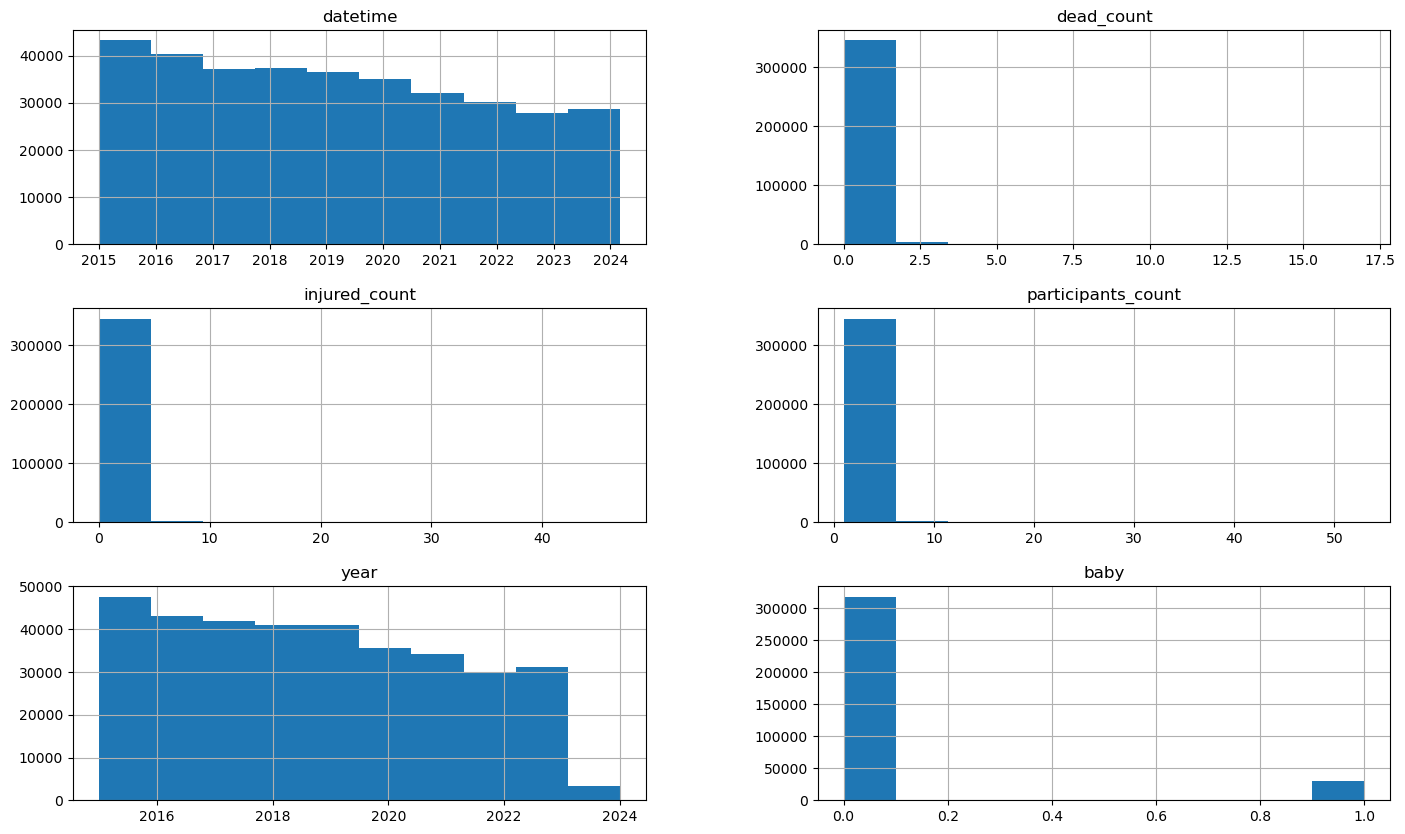

In [46]:
#Построим гистограммы по числовым столбцам
df.loc[:, df.columns != 'id'].hist(figsize=(17,10))
plt.show()

По первым гистограмам видно, что с годами число аварий уменьшается, чаще всего в авариях погибают 1-2 человека, до 5 раненных, больше всего участия в ДТП личных машит, затем грузовых.

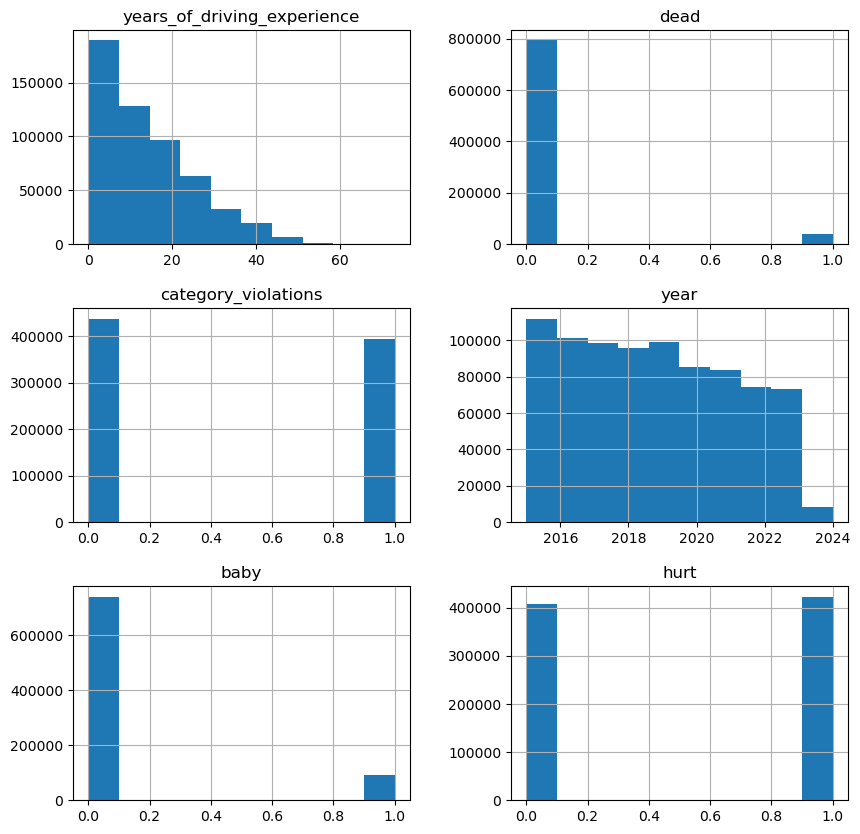

In [47]:
#Построим гистограммы по числовым столбцам
df_foot_part.loc[:, df_foot_part.columns != 'id'].hist(figsize=(10,10))
plt.show()

Отметим, что больше всего аварий до 15 лет стажа, затем идет на убыль. Число нарушающих и не нарушающих почти одинаково. Число раненных чуть больше чем не раненных в ДТП. Число смертей и число участников аварий с детьми почти рядом.

# Шаг 2.Исследовательский анализ данных <a id="Шаг_2.Исследовательский_анализ_данных"></a>

In [28]:
#посчитаем границу выбросов для стажа всех участников ДТП
q1 = df_foot_part['years_of_driving_experience'].quantile(0.25)
q3 = df_foot_part['years_of_driving_experience'].quantile(0.75)
release_max_years_dr = q3+1.5*(q3-q1)
release_min_years_dr = q3-1.5*(q3-q1)
print('Верхняя граница значений стажа:', release_max_years_dr)
print('Нижняя граница значений стажа:', release_min_years_dr)

Верхняя граница значений стажа: 45.0
Нижняя граница значений стажа: -3.0


In [29]:
#посмотрим процент стажа со значением более 45
print('Процент стажа со значением более 45:', round(len(df_foot_part.\
                            query('years_of_driving_experience > @release_max_years_dr'))/len(df_foot_part)*100,2), '%')

Процент стажа со значением более 45: 0.69 %


Процент водителей со стажем выше верхней границы очень мал.

In [30]:
#выведем значения стажа для  всех участников ДТП с учетом верхней границы
df_foot_part.query('years_of_driving_experience <= @release_max_years_dr')['years_of_driving_experience'].describe()

count    532962.000000
mean         13.604525
std          10.797827
min           0.000000
25%           5.000000
50%          11.000000
75%          20.000000
max          45.000000
Name: years_of_driving_experience, dtype: float64

In [31]:
#посчитаем границу выбросов  стажа для женщин
q1_w = df_foot_part.query('gender=="Женский"')['years_of_driving_experience'].quantile(0.25)
q3_w = df_foot_part.query(' gender=="Женский"')['years_of_driving_experience'].quantile(0.75)
release_max_years_dr_w = q3_w+1.5*(q3_w-q1_w)
release_min_years_dr_w = q3_w-1.5*(q3_w-q1_w)
print('Верхняя граница значений стажа:', release_max_years_dr_w)
print('Нижняя граница значений стажа:', release_min_years_dr_w)

Верхняя граница значений стажа: 29.0
Нижняя граница значений стажа: -1.0


In [35]:
#посмотрим процент стажа Женщин со значением более  верхней границы
print('Процент стажа женщин со значением более верхних значений:', round(len(df_foot_part.\
            query('gender=="Женский" & years_of_driving_experience > @release_max_years_dr_w'))/len(df_foot_part.query('gender=="Женский"'))*100,2), '%')

Процент стажа женщин со значением более верхних значений: 0.56 %


In [36]:
#выведем значения стажа для женщин с учетом верхней границы
df_foot_part.query(' gender=="Женский" & years_of_driving_experience <= @release_max_years_dr_w')['years_of_driving_experience'].describe()

count    77700.000000
mean         9.124414
std          6.601624
min          0.000000
25%          4.000000
50%          8.000000
75%         13.000000
max         29.000000
Name: years_of_driving_experience, dtype: float64

In [41]:
#посчитаем границу выбросов  стажа для мужчин
q1_m = df_foot_part.query('gender=="Мужской"')['years_of_driving_experience'].quantile(0.25)
q3_m = df_foot_part.query(' gender=="Мужской"')['years_of_driving_experience'].quantile(0.75)
release_max_years_dr_m = q3_m+1.5*(q3_m-q1_m)
release_min_years_dr_m = q3_m-1.5*(q3_m-q1_m)
print('Верхняя граница значений стажа:', release_max_years_dr_m)
print('Нижняя граница значений стажа:', release_min_years_dr_m)

Верхняя граница значений стажа: 47.5
Нижняя граница значений стажа: -3.5


In [42]:
#посмотрим процент стажа мужчин со значением более  верхней границы
print('Процент стажа мужчин со значением более верхних значений:', round(len(df_foot_part.\
             query('gender=="Мужской" & years_of_driving_experience > @release_max_years_dr_m'))/len(df_foot_part.query('gender=="Мужской"'))*100,2), '%')

Процент стажа мужчин со значением более верхних значений: 0.65 %


In [44]:
#выведем значения стажа для мужчин
df_foot_part.query(' gender=="Мужской"  & years_of_driving_experience <= @release_max_years_dr_m')['years_of_driving_experience'].describe()

count    455856.000000
mean         14.443283
std          11.308115
min           0.000000
25%           5.000000
50%          12.000000
75%          22.000000
max          47.000000
Name: years_of_driving_experience, dtype: float64

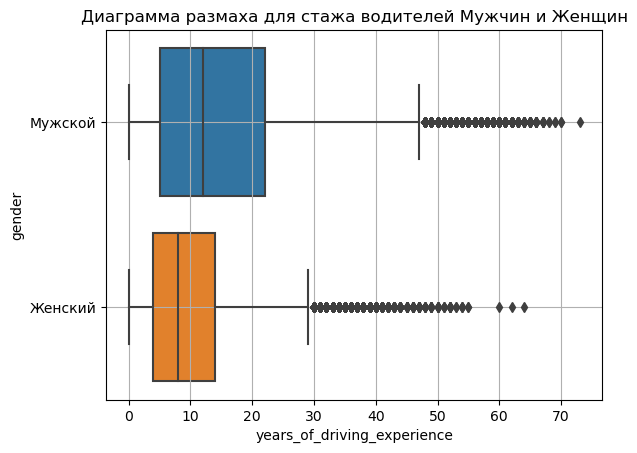

In [46]:
#построим диаграмму размаха
sns.boxplot(data=df_foot_part , x='years_of_driving_experience', y='gender')
plt.title('Диаграмма размаха для стажа водителей Мужчин и Женщин')

plt.grid(True)
plt.show()

In [45]:
##добавим функцию подписывающую значения над столбчатой диаграммой в процентах
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 11, ha='center')

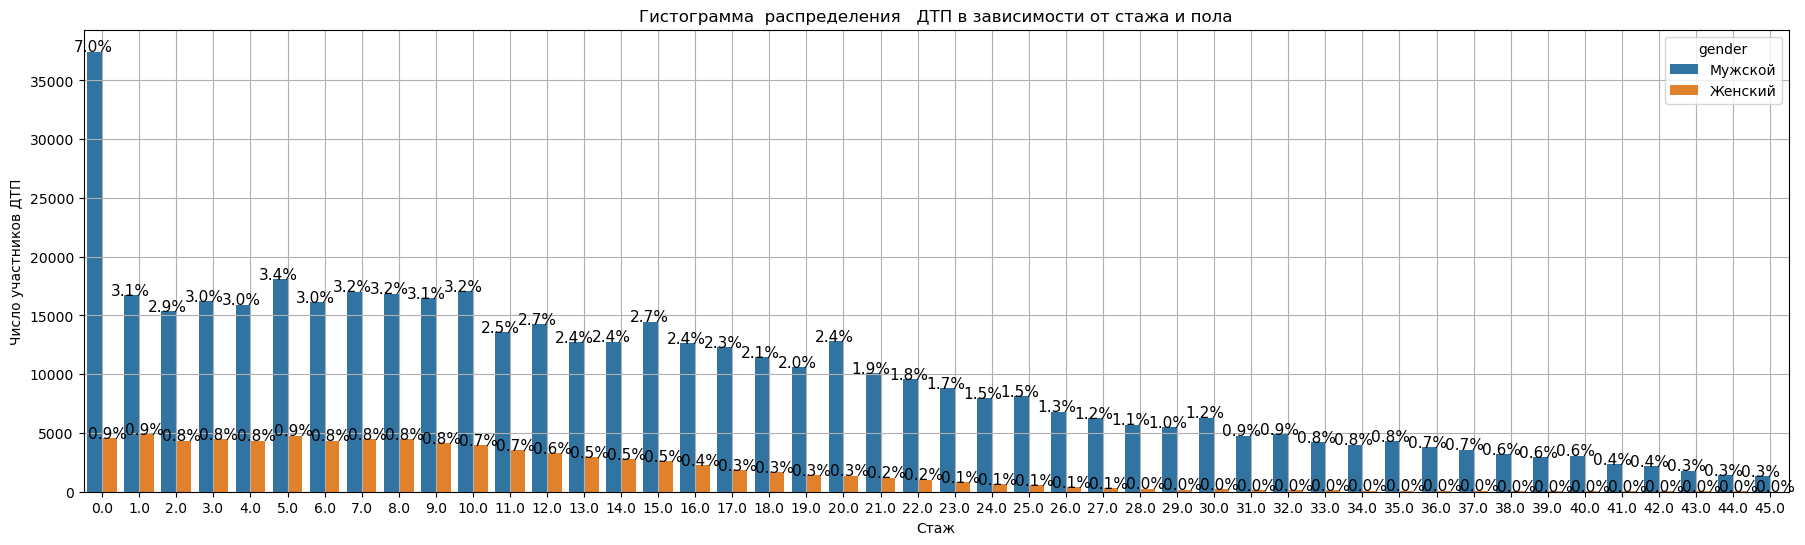

In [47]:
#Построим гистограмму распределения ДТП в зависимости от стажа и пола
plt.figure(figsize=(22, 6))
ax=sns.countplot(hue = df_foot_part.query('years_of_driving_experience<=@release_max_years_dr')['gender'], x ='years_of_driving_experience' ,\
              data = df_foot_part.query('years_of_driving_experience<=@release_max_years_dr'))

plt.title('Гистограмма  распределения   ДТП в зависимости от стажа и пола')
plt.xlabel( 'Стаж')
plt.ylabel('Число участников ДТП')
without_hue(ax,df_foot_part.query('years_of_driving_experience<=@release_max_years_dr')['gender'])
plt.grid(True)

plt.show();

*По диаграмме размаха, рассчетам  и таблице* выделим, что:

   Минимальное значение стажа 0 лет говорит об участии детей-водителей, и людей не имеющих прав или водитель мог скрыться с места преступления и таких аварий больше всего.   
   
   Верхняя граница значений стажа водителей: 45

   Процент стажа всех нарушающих со значением более 45: 0,69 %

   **Медианное и среднее значение стажа всех участников ДТП** по количеству аварий сотставляет - **11-13 лет**.

   А  водители со стажем  **от 0 до 5 лет** совершают до **25%** от всех аварий.
   
   А также сделаем вывод, что **женщины** не ездят аккуратнее, т.к. стаж  приходящийся на 25% аварий ниже и составляет: от 0 года до 4 лет, а **Медианное и среднее значение стажа женщин в ДТП 8-9 лет**. **Верхняя** граница стажа нарушающих женщин составляет **29 лет**.
   
Видим скошенность медианного значения стажа у Мужчин и у Женщин ближе к стороне с минимальным значением, получаем , что распределение стажа  скошено вправо (или «положительно» скошено).  В левой части распределения, плотность значений больше по величине, чем в правой.

In [41]:
#создадим сводную таблицу по тяжести ДТП и стажу
z= df_foot_part.query('years_of_driving_experience<=@release_max_years_dr').pivot_table(index='years_of_driving_experience',
                         columns='severity',
                         values = 'id',
                         aggfunc='count', margins=True)
z

severity                     Легкий  С погибшими  Тяжёлый     All
years_of_driving_experience                                      
0.0                           20784         4569    16641   41994
1.0                           13284         1544     6776   21604
2.0                           12273         1387     6066   19726
3.0                           12673         1556     6463   20692
4.0                           12497         1625     6143   20265
5.0                           14259         1784     6828   22871
6.0                           12524         1690     6261   20475
7.0                           13280         1823     6410   21513
8.0                           13081         1740     6466   21287
9.0                           12544         1731     6323   20598
10.0                          12750         1813     6462   21025
11.0                          10513         1479     5106   17098
12.0                          10784         1530     5260   17574
13.0                           9533         1415     4711   15659
14.0                           9407         1402     4690   15499
15.0                          10078         1620     5346   17044
16.0                           8787         1398     4724   14909
17.0                           8328         1419     4388   14135
18.0                           7684         1282     4139   13105
19.0                           7084         1223     3709   12016
20.0                           8230         1459     4472   14161
21.0                           6796         1105     3362   11263
22.0                           6361         1054     3173   10588
23.0                           5776          982     2857    9615
24.0                           5110          911     2608    8629
25.0                           5142          891     2646    8679
26.0                           4297          781     2143    7221
27.0                           3843          703     1979    6525
28.0                           3504          640     1803    5947
29.0                           3253          624     1788    5665
30.0                           3681          761     2065    6507
31.0                           2863          566     1488    4917
32.0                           2893          547     1553    4993
33.0                           2486          509     1340    4335
34.0                           2415          436     1262    4113
35.0                           2410          514     1454    4378
36.0                           2121          442     1310    3873
37.0                           2125          418     1137    3680
38.0                           1857          346     1064    3267
39.0                           1727          344      950    3021
40.0                           1775          350     1010    3135
41.0                           1355          263      773    2391
42.0                           1243          258      686    2187
43.0                           1047          188      585    1820
44.0                            801          177      457    1435
45.0                            790          145      424    1359
All                          316048        49444   167301  532793

In [48]:
#создадим сводную таблицу по тяжести ДТП и стажу в % от общего число в строке стаж 
for col in z.columns:
    z[col] = np.round(z[col]*100 / z['All'],1)
z

severity                     Легкий  С погибшими  Тяжёлый    All
years_of_driving_experience                                     
0.0                            49.5         10.9     39.6  100.0
1.0                            61.5          7.1     31.4  100.0
2.0                            62.2          7.0     30.8  100.0
3.0                            61.2          7.5     31.2  100.0
4.0                            61.7          8.0     30.3  100.0
5.0                            62.3          7.8     29.9  100.0
6.0                            61.2          8.3     30.6  100.0
7.0                            61.7          8.5     29.8  100.0
8.0                            61.5          8.2     30.4  100.0
9.0                            60.9          8.4     30.7  100.0
10.0                           60.6          8.6     30.7  100.0
11.0                           61.5          8.7     29.9  100.0
12.0                           61.4          8.7     29.9  100.0
13.0                           60.9          9.0     30.1  100.0
14.0                           60.7          9.0     30.3  100.0
15.0                           59.1          9.5     31.4  100.0
16.0                           58.9          9.4     31.7  100.0
17.0                           58.9         10.0     31.0  100.0
18.0                           58.6          9.8     31.6  100.0
19.0                           59.0         10.2     30.9  100.0
20.0                           58.1         10.3     31.6  100.0
21.0                           60.3          9.8     29.8  100.0
22.0                           60.1         10.0     30.0  100.0
23.0                           60.1         10.2     29.7  100.0
24.0                           59.2         10.6     30.2  100.0
25.0                           59.2         10.3     30.5  100.0
26.0                           59.5         10.8     29.7  100.0
27.0                           58.9         10.8     30.3  100.0
28.0                           58.9         10.8     30.3  100.0
29.0                           57.4         11.0     31.6  100.0
30.0                           56.6         11.7     31.7  100.0
31.0                           58.2         11.5     30.3  100.0
32.0                           57.9         11.0     31.1  100.0
33.0                           57.3         11.7     30.9  100.0
34.0                           58.7         10.6     30.7  100.0
35.0                           55.0         11.7     33.2  100.0
36.0                           54.8         11.4     33.8  100.0
37.0                           57.7         11.4     30.9  100.0
38.0                           56.8         10.6     32.6  100.0
39.0                           57.2         11.4     31.4  100.0
40.0                           56.6         11.2     32.2  100.0
41.0                           56.7         11.0     32.3  100.0
42.0                           56.8         11.8     31.4  100.0
43.0                           57.5         10.3     32.1  100.0
44.0                           55.8         12.3     31.8  100.0
45.0                           58.1         10.7     31.2  100.0
All                            59.3          9.3     31.4  100.0

In [49]:
#удалим столбец All
z.drop('All',axis=1,inplace = True)  

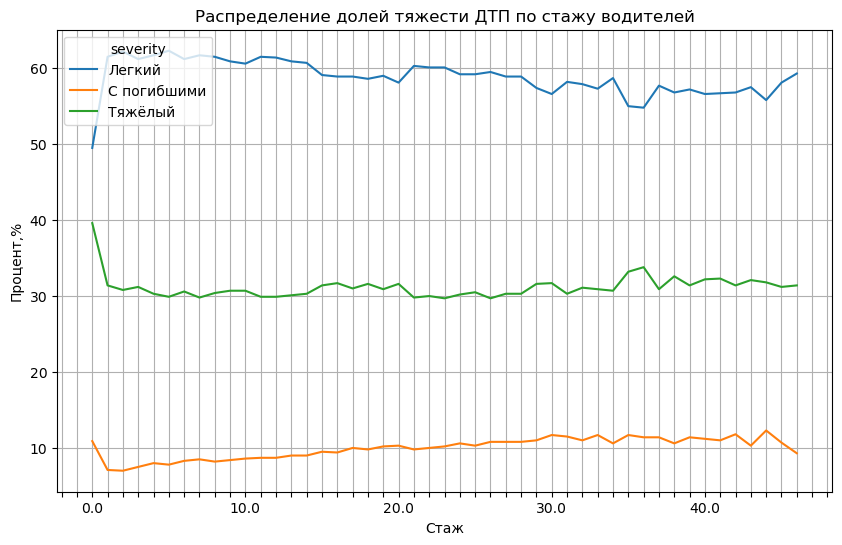

In [68]:
#построим график распределения долей тяжести ДТП по стажу водителей
plt.rcParams['figure.figsize'] = [10, 6]
ax=z.plot.line()
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
plt.title('Распределение долей тяжести ДТП по стажу водителей')
plt.xlabel( 'Стаж')
plt.ylabel('Процент,%')
plt.grid(True)
plt.show();

По графику Распределения долей тяжести ДТП по стажу водителей видим, что большой скачок в доли ДТП с тяжелым исходом и с погибшими имеется в отметке стажа 0 лет. Дальше до 15 лет стажа водителей больше 60%  аварий имеет с легким исходом, а доля погибших от года до 15 лет увеличивается и стремится к 10%. И после 20 лет стажа увеличивается процент погибших, а с легким исходом уменьшается. Возможно, водители до 15 лет стажа более аккуратны и внимательны, реакция еще хорошая. Хотя, по таблице и Гистограмме  распределения   ДТП в зависимости от стажа и пола число ДТП больше у водителей с меньшим стажем.

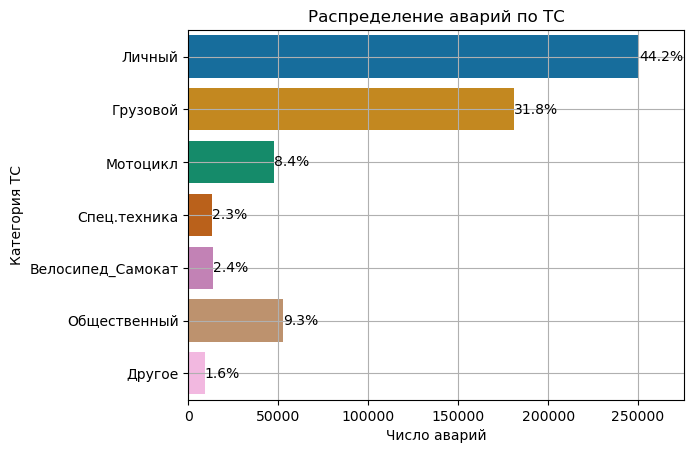

In [60]:
#выведем график распределения аварий по ТС
ax = sns.countplot(y='avto_category', data=df_vehicles, palette='colorblind',\
                              order = df_vehicles['avto_category'].value_counts.index)

# сохраним общее число аварий
total = df_vehicles['avto_category'].count()

#создадим подписи долей аварий
ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/total)*100:0.1f}%')
ax.margins(x=0.1)
ax.set(xlabel='Число аварий', ylabel='Категория ТС', title='Распределение аварий по ТС')
plt.grid(True)
plt.show();

По графику Доли ТС по авариям видим, что 44,2% аварий приходится на личный транспорт, на втором месте грузовой - 31,8%, намного тменьше аварий  с общественным транспортом - 9,3%. Отсюда можно сделать вывод, что в общественном транспорте безопаснее, чем в личном.

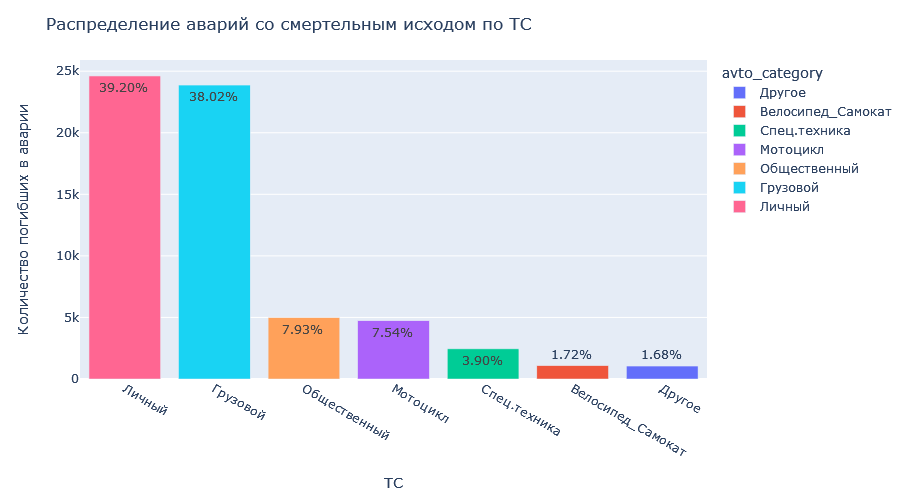

In [61]:
#построим график по сводной таблице - зависимости количество погибших в аварии по ТС
z =df_vehicles.groupby('avto_category', as_index=False)['dead_count'].sum().sort_values(by='dead_count')
# строим график
z['percent'] = round(z['dead_count']/df_vehicles['dead_count'].sum()*100,2)
fig = px.bar(z,
             x='avto_category',
             y='dead_count',
             color='avto_category',
             text=z['percent'].apply(lambda x: '{0:1.2f}%'.format(x)),
            )

# оформляем график
fig.update_layout(xaxis={'categoryorder':'total descending'},
    title='Распределение аварий со смертельным исходом по ТС',
                   xaxis_title='ТС',
                   yaxis_title='Количество погибших в аварии',
                   width=1000, # указываем размеры графика
                   height=500)

fig.show(); # выводим график

По числу погибших в авариях больше всего у Личного транспорта и доля составляет 39,20%, затем немного уступает грузовой транспорт-с долей погибших - 38,02%, Общественный и Мотоциклы имеют по 7,93% и 7,54% соотсветственно. У грузового транспорта много слепых зон и трудно быстро остановиться, думаю, поэтому много смертей с этим транспортным средством.

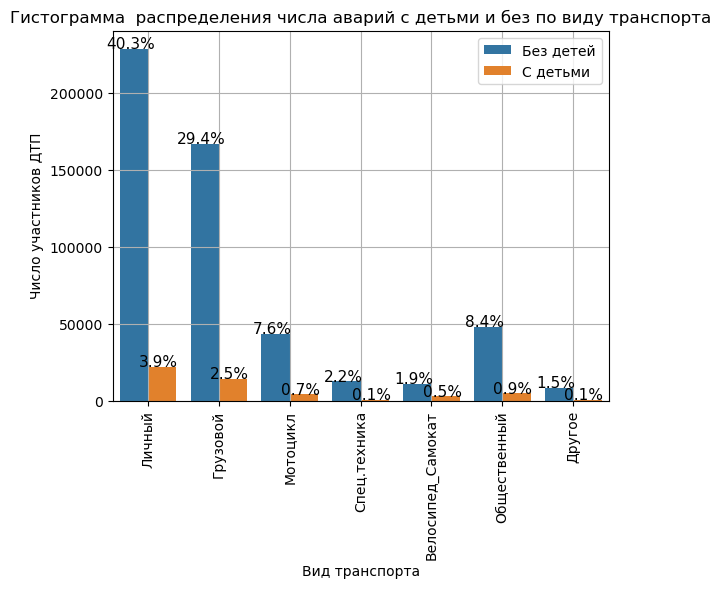

In [62]:
#Построим гистограмму распределения числа аварий с участием и без детей по виду транспорта
ax=sns.countplot(hue = 'baby', x = df_vehicles['avto_category'],\
              data = df_vehicles)

plt.title('Гистограмма  распределения числа аварий с детьми и без по виду транспорта')
plt.xlabel( 'Вид транспорта')
plt.ylabel('Число участников ДТП')
plt.legend(['Без детей','С детьми'])
plt.xticks(rotation=90)
plt.grid(True)
without_hue(ax,df_vehicles['avto_category'])
plt.show();

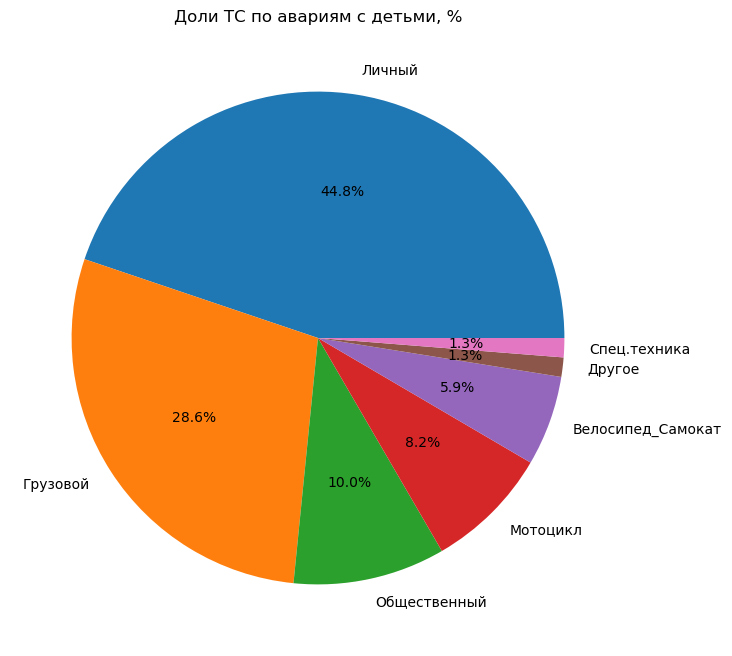

In [63]:
#построим график зависимости долей ТС с участием детей
category = df_vehicles.query('baby==1')['avto_category'].value_counts()

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(category,labels=category.index, autopct='%1.1f%%')
ax1.set_title('Доли ТС по авариям с детьми, %')

plt.show();

По Гистограмме  распределения числа аварий с детьми и без по виду транспорта заметим, что аварий с детьми крайне мало. Из них 44,8% приходится на участие личного транспорта, также на втором месте Грузовой - 28,6%, 10%-Общественный и на самом последнем месте аварии с участием спец. техники, всего 1,3%. Т.е. более внимательными на дороге быть и готовыми к появлению детей на ней нужно водителям на личном транспорте и  грузовом.

In [64]:
#создадим сводную таблицу по ролям и категории здоровья c участием детей
z= df_foot_part.query('baby==1').pivot_table(index='role',
                         columns='health_category',
                         values = 'id',
                         aggfunc='count', margins=True)
z

health_category             Не пострадал  Раненый-Амбулаторное  \
role                                                             
Велосипедист                        25.0                1120.0   
Водитель                         35207.0                3693.0   
Пассажир                          1268.0               11786.0   
Пешеход                            122.0                5600.0   
Пешеход-Водитель(Пассажир)          13.0                  20.0   
All                              36635.0               22219.0   

health_category             Раненый-Стационар  Скончался  \
role                                                       
Велосипедист                            932.0       64.0   
Водитель                               3512.0      903.0   
Пассажир                               8867.0     1360.0   
Пешеход                                4935.0      301.0   
Пешеход-Водитель(Пассажир)               29.0       14.0   
All                                   18275.0     2642.0   

health_category             Стационар или Амбулаторное  Травмы    All  
role                                                                   
Велосипедист                                     594.0     7.0   2742  
Водитель                                        1895.0   221.0  45431  
Пассажир                                        5272.0   708.0  29261  
Пешеход                                         2637.0    53.0  13648  
Пешеход-Водитель(Пассажир)                        15.0     NaN     91  
All                                            10413.0   989.0  91173

In [65]:
#создадим сводную таблицу с участием детей по ролям и категории здоровья в % от общего число в строке роль 
for col in z.columns:
    z[col] = np.round(z[col]*100 / z['All'],1)
z

health_category             Не пострадал  Раненый-Амбулаторное  \
role                                                             
Велосипедист                         0.9                  40.8   
Водитель                            77.5                   8.1   
Пассажир                             4.3                  40.3   
Пешеход                              0.9                  41.0   
Пешеход-Водитель(Пассажир)          14.3                  22.0   
All                                 40.2                  24.4   

health_category             Раненый-Стационар  Скончался  \
role                                                       
Велосипедист                             34.0        2.3   
Водитель                                  7.7        2.0   
Пассажир                                 30.3        4.6   
Пешеход                                  36.2        2.2   
Пешеход-Водитель(Пассажир)               31.9       15.4   
All                                      20.0        2.9   

health_category             Стационар или Амбулаторное  Травмы    All  
role                                                                   
Велосипедист                                      21.7     0.3  100.0  
Водитель                                           4.2     0.5  100.0  
Пассажир                                          18.0     2.4  100.0  
Пешеход                                           19.3     0.4  100.0  
Пешеход-Водитель(Пассажир)                        16.5     NaN  100.0  
All                                               11.4     1.1  100.0

In [66]:
#удалим столбец All
z.drop('All',axis=1,inplace = True)  

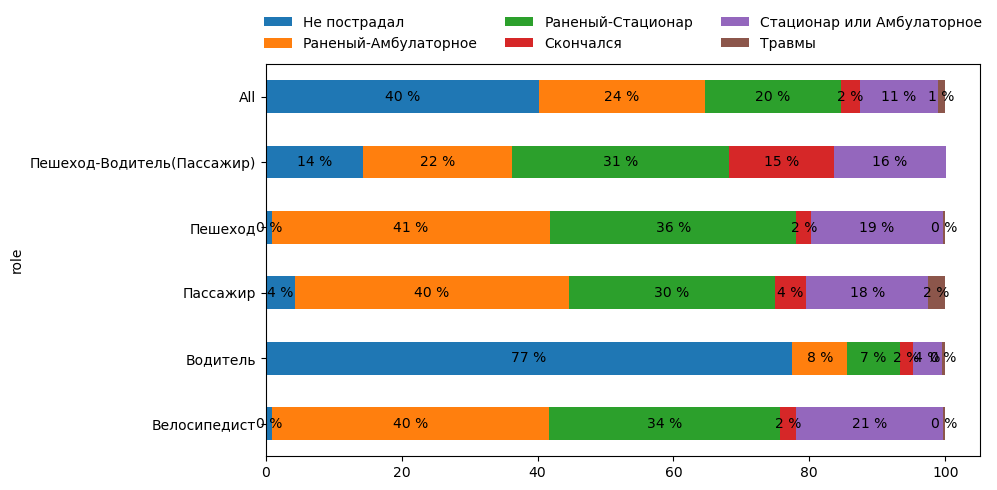

In [67]:
#Выведем график с участием детей % долей категорий здоровья в зависимости от роли

z.plot.barh(stacked=True,  figsize=(10,5))
#plt.title('Гистограмма  распределения с участием детей долей участников в категориях здоровья по ролям')
plt.legend(
     bbox_to_anchor=(0.5, 1.02),
     loc="lower center",
     borderaxespad=0,
     frameon=False,
     ncol=3,
    )
for ix, row in z.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in row:
        if element == element and element > 0.1:
            plt.text(
                    cumulative + element / 2,
                    ix,
                    f"{int(element)} %",
                    va="center",
                    ha="center",
                )
            cumulative += element
plt.tight_layout()

plt.show();

В ДТП с участием детей водитель меньше всего получает вреда для здоровья, больше 80% получают ранения отсальные участиники ДТП. Больше всего смертельных исходов в авариях с участием детей у тех, кто вышел из машины. предполагаю, что дети выходят из транспорта без присмотра взрослых, не внимательно относятся к безопасности и поэтому погибают.

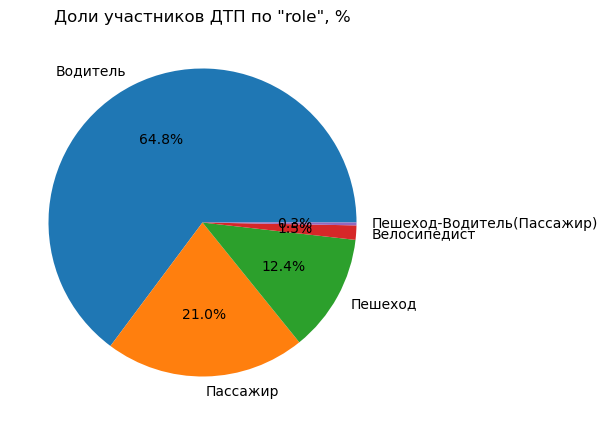

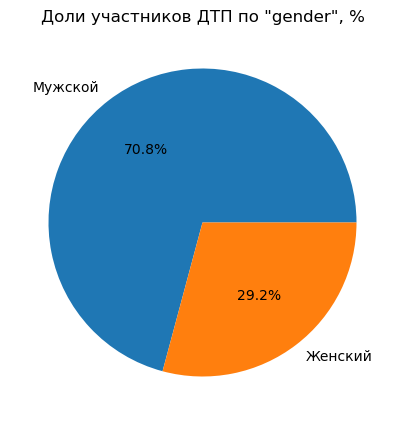

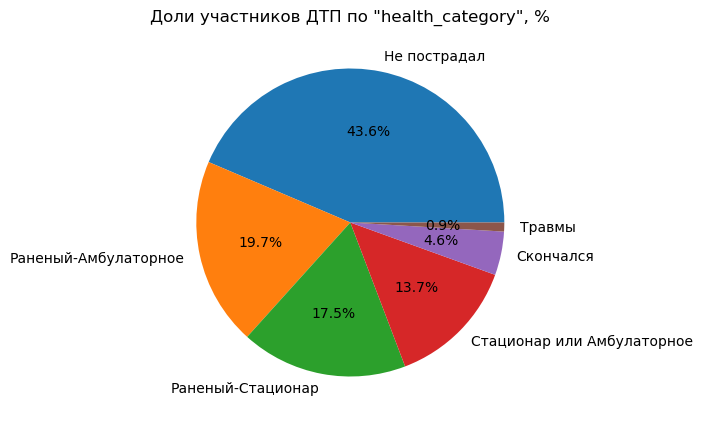

In [68]:
#построим график зависимости долей участников ДТП по категориям вреда здоровья
for col in df_foot_part[['role', 'gender', 'health_category']].columns:

    category = df_foot_part[col].value_counts()

    fig1, ax1 = plt.subplots(figsize=(5, 5))
    ax1.pie(category,labels=category.index, autopct='%1.1f%%')
    ax1.set_title(f'Доли участников ДТП по "{col}", %')
    plt.show();

По графикам распределения долей отметим, что больше всего в базе участников ДТП с ролью водитель - 64,8%, 21,1% пассажиров, 12% -пешеходов. Больше всего мужчин - 70,8%. 43,6% участников со статусом- не пострадал, около половины занимаю участники с ранениями. 4,6-Скончались.

In [69]:
#создадим сводную таблицу по ролям и категории здоровья
z= df_foot_part.pivot_table(index='role',
                         columns='health_category',
                         values = 'id',
                         aggfunc='count', margins=True)
z

health_category             Не пострадал  Раненый-Амбулаторное  \
role                                                             
Велосипедист                          79                  3915   
Водитель                          353129                 63509   
Пассажир                            8437                 63012   
Пешеход                              324                 33133   
Пешеход-Водитель(Пассажир)           205                   480   
All                               362174                164049   

health_category             Раненый-Стационар  Скончался  \
role                                                       
Велосипедист                             4019        952   
Водитель                                57898      16134   
Пассажир                                47030       8896   
Пешеход                                 35407      11569   
Пешеход-Водитель(Пассажир)                825        482   
All                                    145179      38033   

health_category             Стационар или Амбулаторное  Травмы     All  
role                                                                    
Велосипедист                                      3521      10   12496  
Водитель                                         45203    2674  538547  
Пассажир                                         42422    4834  174631  
Пешеход                                          22127     306  102866  
Пешеход-Водитель(Пассажир)                         496       5    2493  
All                                             113769    7829  831033

In [70]:
#создадим сводную таблицу по ролям и категории здоровья в % от общего число в строке роль
for col in z.columns:
    z[col] = np.round(z[col]*100 / z['All'],1)
z

health_category             Не пострадал  Раненый-Амбулаторное  \
role                                                             
Велосипедист                         0.6                  31.3   
Водитель                            65.6                  11.8   
Пассажир                             4.8                  36.1   
Пешеход                              0.3                  32.2   
Пешеход-Водитель(Пассажир)           8.2                  19.3   
All                                 43.6                  19.7   

health_category             Раненый-Стационар  Скончался  \
role                                                       
Велосипедист                             32.2        7.6   
Водитель                                 10.8        3.0   
Пассажир                                 26.9        5.1   
Пешеход                                  34.4       11.2   
Пешеход-Водитель(Пассажир)               33.1       19.3   
All                                      17.5        4.6   

health_category             Стационар или Амбулаторное  Травмы    All  
role                                                                   
Велосипедист                                      28.2     0.1  100.0  
Водитель                                           8.4     0.5  100.0  
Пассажир                                          24.3     2.8  100.0  
Пешеход                                           21.5     0.3  100.0  
Пешеход-Водитель(Пассажир)                        19.9     0.2  100.0  
All                                               13.7     0.9  100.0

In [71]:
#удалим столбец All
z.drop('All',axis=1,inplace = True)  

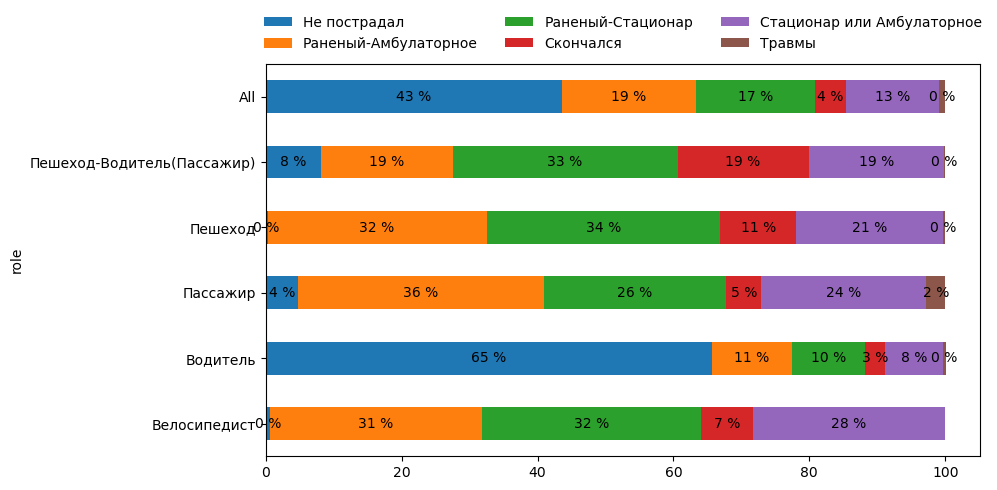

In [72]:
#Выведем график % долей категорий здоровья в зависимости от роли

z.plot.barh(stacked=True,  figsize=(10,5))
#plt.title('Гистограмма  распределения долей участников в категориях здоровья по ролям')
plt.legend(
     bbox_to_anchor=(0.5, 1.02),
     loc="lower center",
     borderaxespad=0,
     frameon=False,
     ncol=3,
    )
for ix, row in z.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in row:
        if element == element and element > 0.1:
            plt.text(
                    cumulative + element / 2,
                    ix,
                    f"{int(element)} %",
                    va="center",
                    ha="center",
                )
            cumulative += element
plt.tight_layout()

plt.show();

По Гистограмме  распределения долей участников в категориях здоровья по ролям отметим, что меньше всего вреда здоровью получают водители, чаще всего погибают Водитель или пассажир, которые вышли из машины, также много раненных среди пешеходов, пассажиров и велосипедистов, а среди них погибают чаще пешеходы.  Это более не защищенные слои.

In [100]:
#создадим сводную таблицу по ТС и категориии тяжести ДТП
z= df_vehicles.pivot_table(index='avto_category',
                         columns='severity',
                         values = 'id',
                         aggfunc='count', margins=True)
z

severity           Легкий  С погибшими  Тяжёлый     All
avto_category                                          
Велосипед_Самокат    8264         1058     4446   13768
Грузовой           106223        19486    55093  180802
Другое               5583          906     2609    9098
Личный             153077        20473    77136  250686
Мотоцикл            23582         4302    19571   47455
Общественный        34420         4078    14362   52860
Спец.техника         6527         2121     4439   13087
All                337676        52424   177656  567756

In [101]:
#создадим сводную таблицу по ТС и категориии тяжести ДТП в % от общего число в строке ТС
for col in z.columns:
    z[col] = np.round(z[col]*100 / z['All'],1)
z

severity           Легкий  С погибшими  Тяжёлый    All
avto_category                                         
Велосипед_Самокат    60.0          7.7     32.3  100.0
Грузовой             58.8         10.8     30.5  100.0
Другое               61.4         10.0     28.7  100.0
Личный               61.1          8.2     30.8  100.0
Мотоцикл             49.7          9.1     41.2  100.0
Общественный         65.1          7.7     27.2  100.0
Спец.техника         49.9         16.2     33.9  100.0
All                  59.5          9.2     31.3  100.0

In [102]:
#удалим столбец All
z.drop('All',axis=1,inplace = True) 

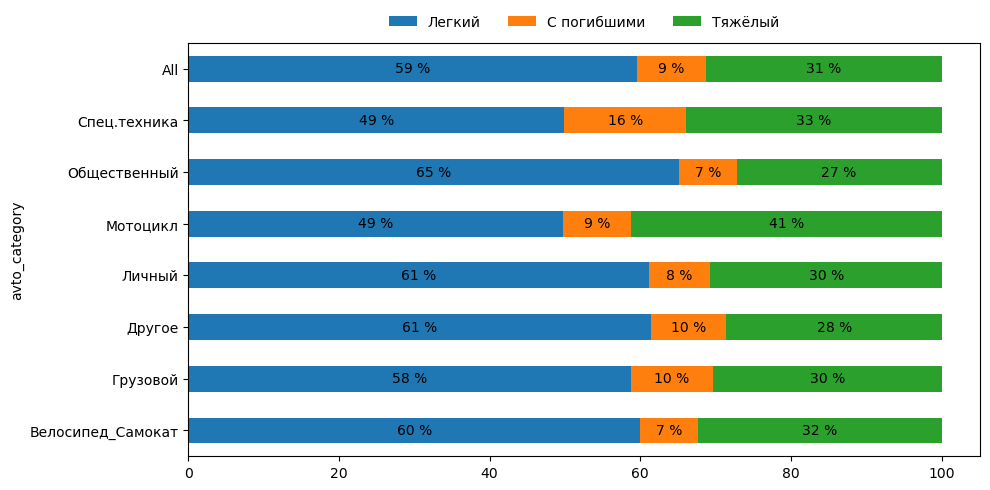

In [103]:
#Выведем график % долей категориий тяжести ДТП  в зависимости от ТС

z.plot.barh(stacked=True,  figsize=(10,5))
#plt.title('Гистограмма  распределения долей ТС в категориях тяжести ДТП )
plt.legend(
     bbox_to_anchor=(0.5, 1.02),
     loc="lower center",
     borderaxespad=0,
     frameon=False,
     ncol=3,
    )
for ix, row in z.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in row:
        if element == element and element > 0.1:
            plt.text(
                    cumulative + element / 2,
                    ix,
                    f"{int(element)} %",
                    va="center",
                    ha="center",
                )
            cumulative += element
plt.tight_layout()

plt.show();

По Гистограмме  распределения долей ТС в категориях тяжести ДТП видим, что больше всего аварий с легким исходом приходится на Общественный транспорт. С тяжелым исходом больше всего процент ДТП занимают мотоциклы. Большой процент ТС Спец. техники учавствуют в авариях с погибшими, целых 16% от общего числа ДТП со спец. техникой. К Транспорту спец. техники, как правило, относят тяжелый транспорт, которому трудно делать резкие остановки при возникновении препятсвия, либо скорую помощь, которую необходимо пропускать. Возможно как раз скорую помощь и машины со спец. сигналами не пропускают, не видят, и из-за этого такой процент смертей с этим транспортом связанно. Высокий процент смертей приходится также на мотоциклы и грузовой, 9% и 10% соотвественно.

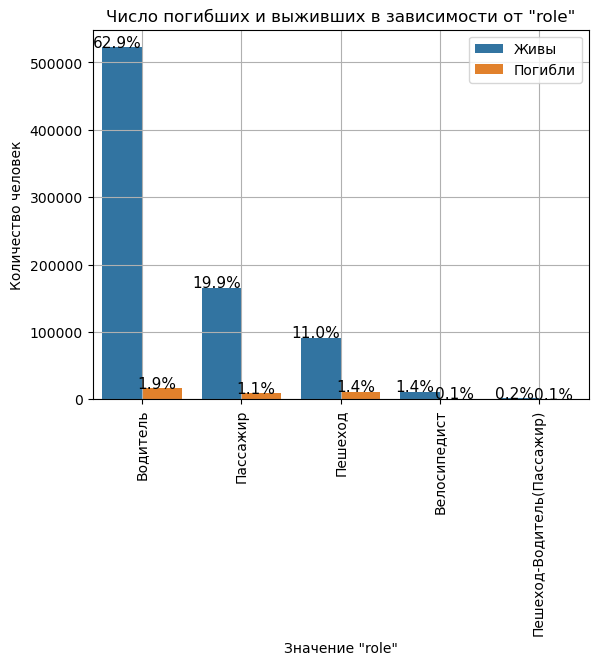

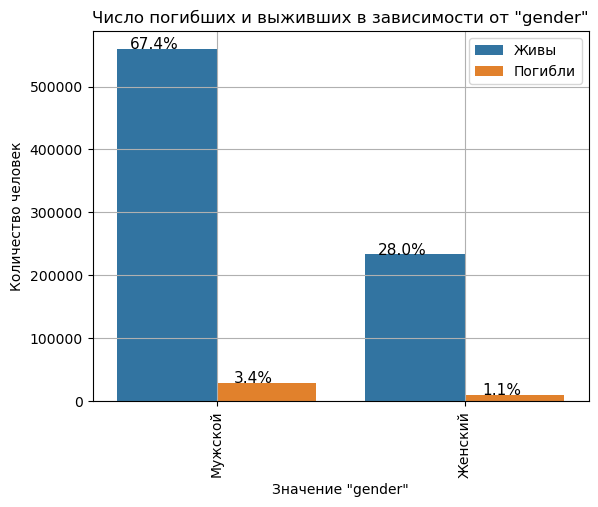

In [73]:
#Бинарные и дискретные признаки визуализируем методом "countplot"
for col in df_foot_part[['role', 'gender']].columns:
    ax=sns.countplot(x = col, hue = 'dead', data = df_foot_part)

    plt.title(f'Число погибших и выживших в зависимости от "{col}"' )
    plt.ylabel('Количество человек')
    plt.xlabel(f'Значение "{col}"')
    plt.legend(['Живы','Погибли'])
    plt.xticks(rotation=90)
    plt.grid(True)
    without_hue(ax,df_foot_part[col])
    plt.show();

Среди мужчин выше процент погибших, чем у женщин. Среди пешеходов и пассажиров высок процент погибших, выше  всего процент погибших у водителей.

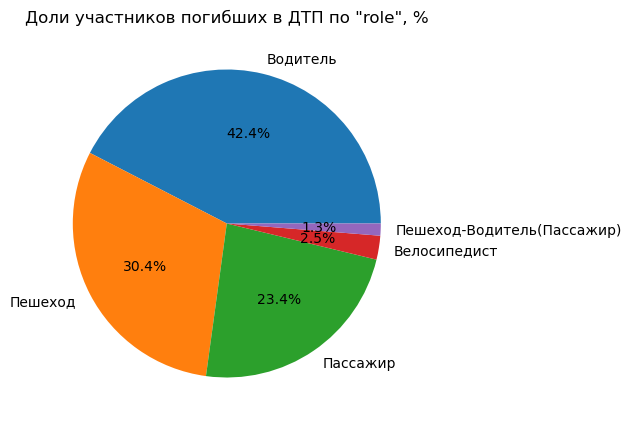

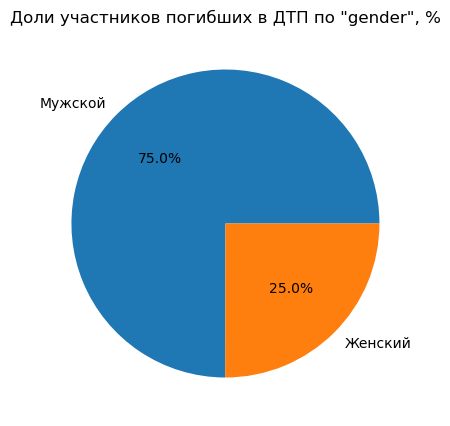

In [74]:
#построим график зависимости долей погибших участников ДТП по роли и полу
for col in df_foot_part[['role', 'gender']].columns:

    category = df_foot_part.query('dead==1')[col].value_counts()

    fig1, ax1 = plt.subplots(figsize=(5, 5))
    ax1.pie(category,labels=category.index, autopct='%1.1f%%')
    ax1.set_title(f'Доли участников погибших в ДТП по "{col}", %')
    plt.show();

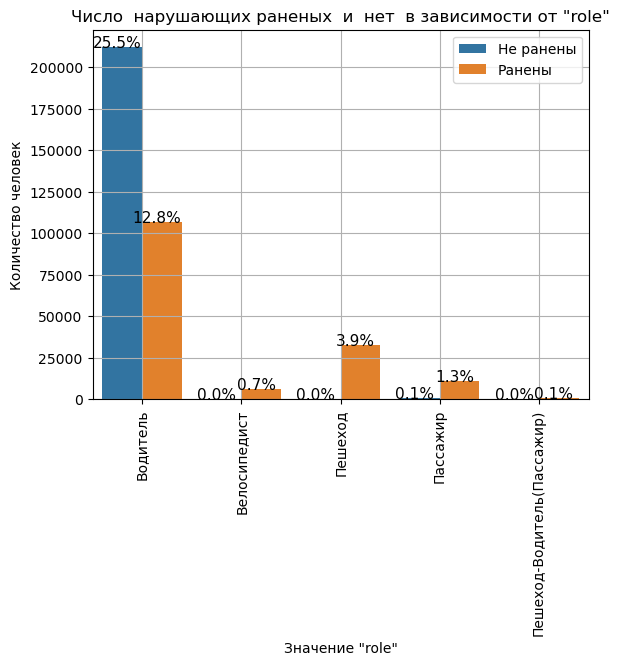

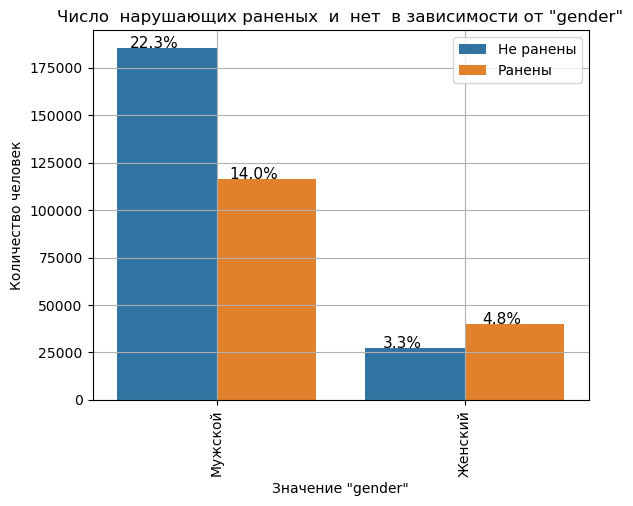

In [75]:
#Бинарные и дискретные признаки визуализируем методом "countplot" по виновным в аварии, исключаем погибших
for col in df_foot_part.query('category_violations==1 & dead==0')[['role', 'gender']].columns:
    ax=sns.countplot(x = col, hue = 'hurt', data = df_foot_part.query('category_violations==1 & dead==0'))

    plt.title(f'Число  нарушающих раненых  и  нет  в зависимости от "{col}"' )
    plt.ylabel('Количество человек')
    plt.xlabel(f'Значение "{col}"')
    plt.legend(['Не ранены','Ранены'])
    plt.xticks(rotation=90)
    plt.grid(True)
    without_hue(ax,df_foot_part[col])

    plt.show();

По Гистограмме  нарушающих раненых  и  нет  в зависимости от пола видно, что нарушающие женщины чаще получают ранения, в то время как мужчины остаются без повреждений. Возможно, реакция и хлоднокровие мужчин чаще спасает от серьезных аварий.

По Гистограмме  нарушающих раненых  и  нет  в зависимости от роли отметим, что нарушающие пешеходы, велосипедисты и пассажиры чаще получают ранения. Пассажиры, думаю, выходят из машины не в положенных местах. А водители нарушающие остаются больше без ранений. Погибшие в этих гистограммах исключены.

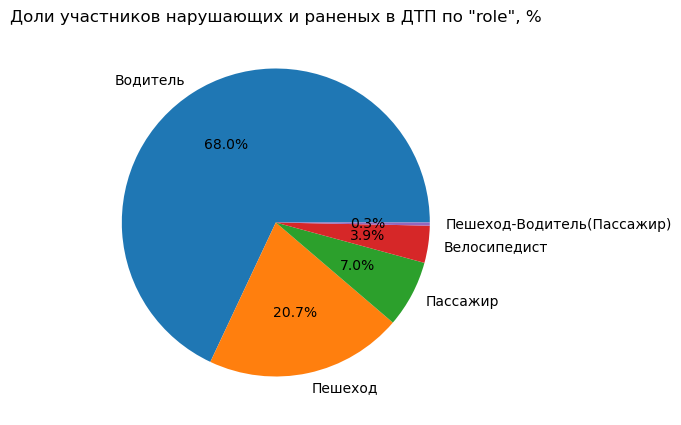

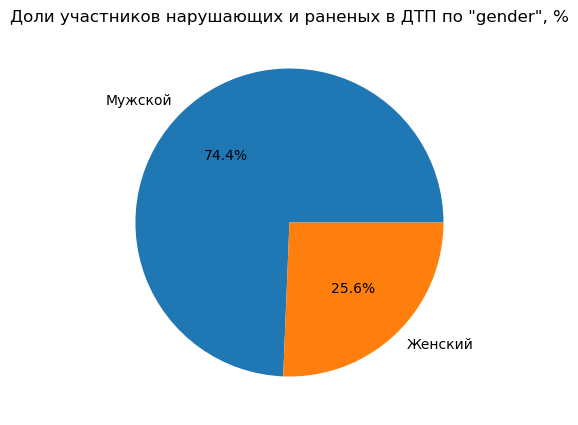

In [76]:
#построим график зависимости долей нарушающих раненых участников ДТП по роли и полу
for col in df_foot_part[['role', 'gender']].columns:

    category = df_foot_part.query('category_violations==1 & dead==0 & hurt==1')[col].value_counts()

    fig1, ax1 = plt.subplots(figsize=(5, 5))
    ax1.pie(category,labels=category.index, autopct='%1.1f%%')
    ax1.set_title(f'Доли участников нарушающих и раненых в ДТП по "{col}", %');
    plt.show()

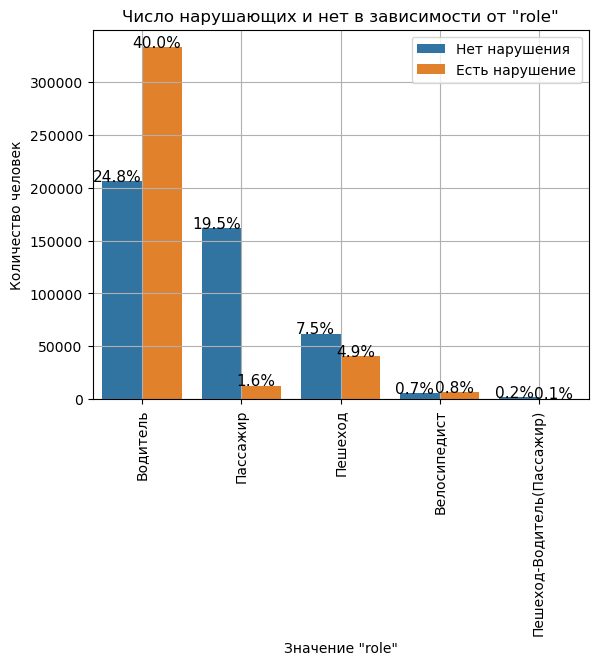

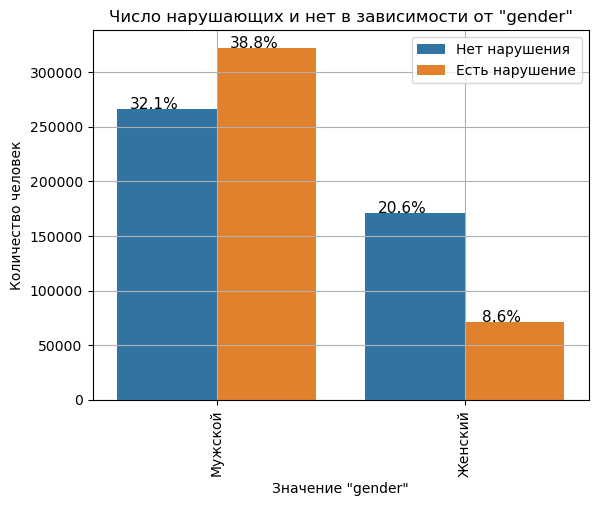

In [77]:
#Бинарные и дискретные признаки визуализируем методом "countplot"
for col in df_foot_part[['role', 'gender']].columns:
    ax=sns.countplot(x = col, hue = 'category_violations', data = df_foot_part)

    plt.title(f'Число нарушающих и нет в зависимости от "{col}"' )
    plt.ylabel('Количество человек')
    plt.xlabel(f'Значение "{col}"')
    plt.legend(['Нет нарушения','Есть нарушение'])
    plt.xticks(rotation=90)
    plt.grid(True)
    without_hue(ax,df_foot_part[col])

    plt.show();

По гистограмме распределения числа нарушающих и нет по полу видно, что Мужчины больше нарушающих, чем нет. И таже они чаще нарушают, чем женщины. Таже По гистограмме распределения числа нарушающих и нет по роли больше нарушающих, чем не не нарушающих у водителей, у велосипедистов поровну нарушающих и нет. Пешеходы не нарушающих все же меньше, чем тех кто нарушает правила.Но среди пешеходов все же высок процент нарушающих.

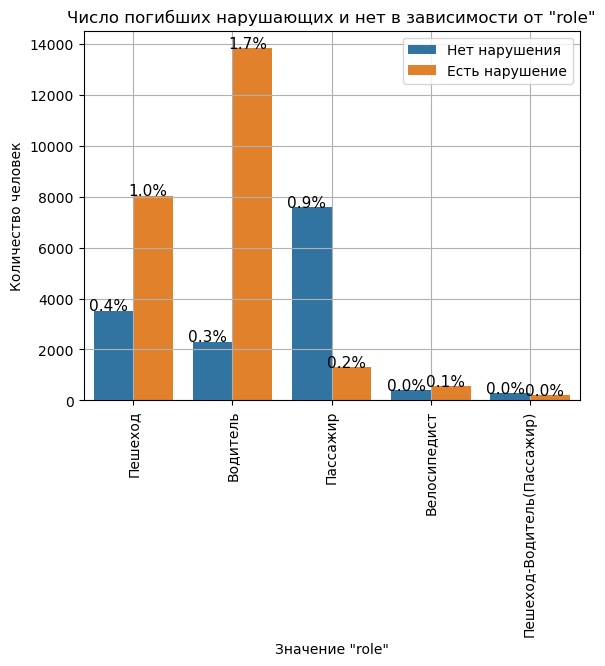

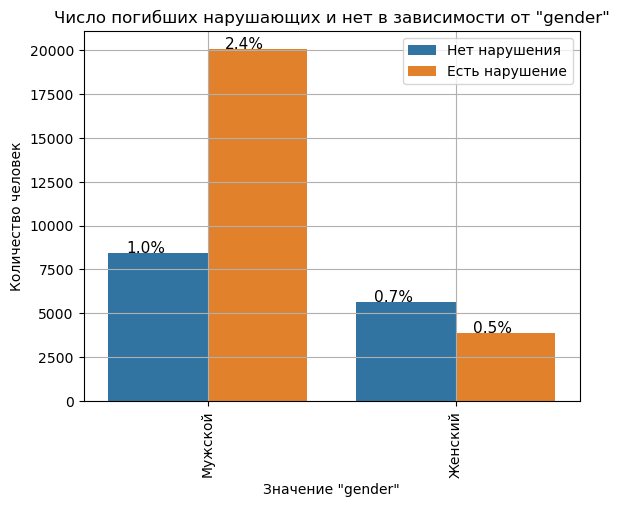

In [78]:
#Бинарные и дискретные признаки  погибших нарушающих или нет визуализируем методом "countplot"
for col in df_foot_part.query('dead==1')[['role', 'gender']].columns:
    ax=sns.countplot(x = col, hue = 'category_violations', data = df_foot_part.query('dead==1'))

    plt.title(f'Число погибших нарушающих и нет в зависимости от "{col}"' )
    plt.ylabel('Количество человек')
    plt.xlabel(f'Значение "{col}"')
    plt.legend(['Нет нарушения','Есть нарушение'])
    plt.xticks(rotation=90)
    plt.grid(True)
    without_hue(ax,df_foot_part[col])

    plt.show();

По гистограмме распределения числа погибших среди нарушающих и нет по полу видно, что Мужчины нарушающие чаще погибают, чем, мужчины не нарушающие и чем женщины. А у женщин больше погибших среди не нарушающих.

По гистограмме распределения числа погибших среди нарушающих и нет по роли отметим, что погибают чаще нарушающие водители и пешеходы, велосипедисты.

In [79]:
#нарушения пассажиров погибающих
df_foot_part.query('dead==1 & role=="Пассажир"')['violations'].value_counts()

violations
[]                                                                                                                                                     7577
[Нарушение правил применения ремней безопасности пассажиром]                                                                                            977
[Нарушение правил применения мотошлема пассажиром]                                                                                                      154
[Иные нарушения]                                                                                                                                         92
[Иные нарушения, Нарушение правил применения ремней безопасности пассажиром]                                                                             49
[Оставление движущегося транспортного средства (выход или выпрыгивание на ходу и т.д.)]                                                                  17
[Нарушение правил пользования общественным транспорто

In [80]:
#нарушения пассажиров погибающих
df_foot_part.query('dead==1 & role=="Пешеход"')['violations'].value_counts().head()

violations
[]                                                                                                                                                                        3529
[Переход через проезжую часть вне пешеходного перехода в зоне его видимости либо при наличии в непосредственной близости подземного (надземного) пешеходного перехода]    1964
[Переход через проезжую часть в неустановленном месте (при наличии в зоне видимости перекрёстка)]                                                                          667
[Иные нарушения]                                                                                                                                                           655
[Нахождение на проезжей части без цели её перехода]                                                                                                                        589
Name: count, dtype: int64

Отметим, что погибающие пассажиры чаще всего нарушают: правила применения ремней безопасности и правила применения мотошлема. А пешеходы перебегают дорогу не в положенных местах вблизи пешеходного перехода и погибают.

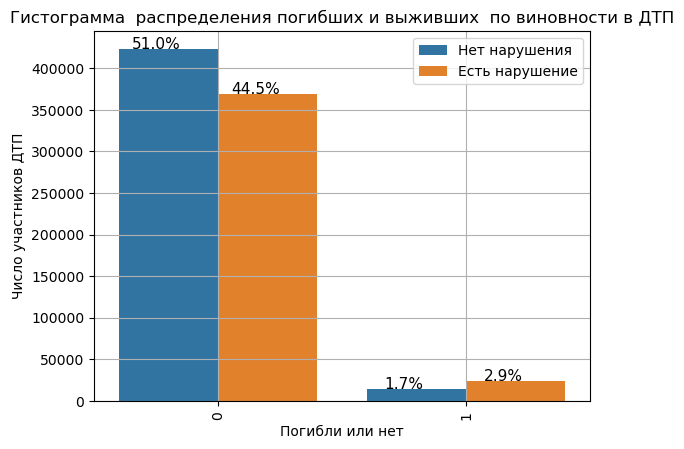

In [81]:
#Построим гистограмму распределения числа невиновных участников ДТП по категориям вреда здоровья
ax=sns.countplot(hue = 'category_violations', x = df_foot_part['dead'],\
              data = df_foot_part)

#ax = plt.gca()
#autolabel(ax.patches,  height_factor=1.01)
plt.title('Гистограмма  распределения погибших и выживших  по виновности в ДТП')
plt.xlabel( 'Погибли или нет')
plt.ylabel('Число участников ДТП')
plt.legend(['Нет нарушения','Есть нарушение'])
plt.xticks(rotation=90)
plt.grid(True)
without_hue(ax,df_foot_part['category_violations'])

plt.show();

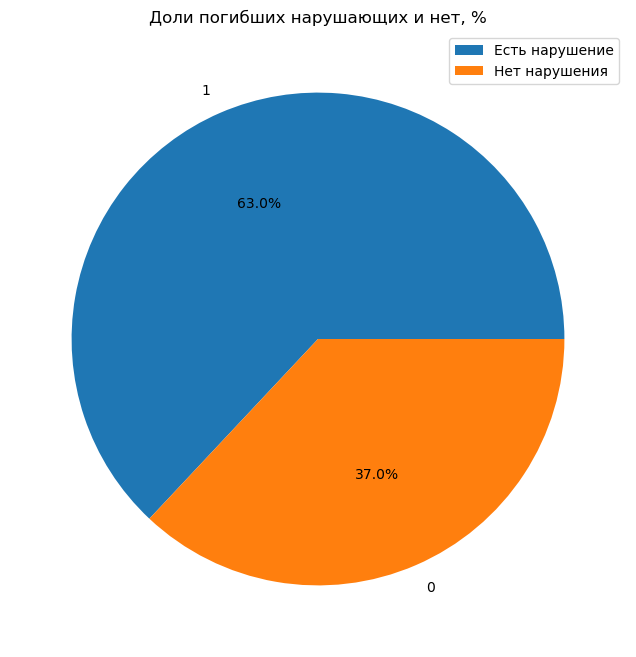

In [82]:
#построим график зависимости долей ТС
category = df_foot_part.query('dead==1')['category_violations'].value_counts()

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(category,labels=category.index, autopct='%1.1f%%')
ax1.set_title('Доли погибших нарушающих и нет, %')
plt.legend(['Есть нарушение','Нет нарушения'])
plt.show();

Гистограмма  распределения погибших и выживших по виновности в ДТП показывает, что выживших много, среди них больше не нарушающих. А вот среди погибших почти одинаково нарушающих и не нарушающих. Т.е. те кто не нарушал могли погибнуть по чьей то вине и их больше, чем  нарушающих погибших. И чаще погибают нарушающие участники ДТП. Нарушают больше половины участников ДТП.

In [83]:
# Разделим самые простые списки.

for col in df:

# Важно, чтобы в списках не затерялся json формат.

    if col not in ['vehicles', 'participants', 'point']:

#

        try:
            print(f'Столбец {col}')
            #  explode разделяет list
            print(f'Уникальные значения {df.explode(col)[col].unique()}')

            print(f'Всего {df.explode(col)[col].nunique()}')
            print(f'Первые 10 по Числу ДТП по условию {df[col].value_counts().head(10)} ')
            print(50*'*')
        except:
            print(50*'-')

Столбец id
Уникальные значения [2700162 2810534 2797373 ... 1867222 1874000 1867695]
Всего 348745
Первые 10 по Числу ДТП по условию id
2700162    1
2154674    1
2154651    1
2154607    1
2154258    1
2154609    1
2154657    1
2154619    1
2154660    1
2154626    1
Name: count, dtype: int64 
**************************************************
Столбец tags
Уникальные значения ['Дорожно-транспортные происшествия'
 'ДТП и пострадавшие дети в возрасте до 16 лет'
 'ДТП и пострадавшие пешеходы, из-за наезда на пешеходов, на пешеходных переходах, по вине пешеходов']
Всего 3
Первые 10 по Числу ДТП по условию tags
[Дорожно-транспортные происшествия]                                                                                                                                                      315322
[Дорожно-транспортные происшествия, ДТП и пострадавшие дети в возрасте до 16 лет]                                                                                                         30359
[Доро

In [79]:
#выведем покрытие дороги для ДТП с погибшими, первые 15
df.query('severity=="С погибшими"').explode('road_conditions')['road_conditions'].value_counts().head(15)

road_conditions
Сухое                                                                     21440
Мокрое                                                                     8067
Отсутствие, плохая различимость горизонтальной разметки проезжей части     5239
Обработанное противогололедными материалами                                2643
Отсутствие дорожных знаков в необходимых местах                            1811
Отсутствие освещения                                                       1348
Недостатки зимнего содержания                                              1162
Неудовлетворительное состояние обочин                                      1013
Заснеженное                                                                 808
Неправильное применение, плохая видимость дорожных знаков                   745
Отсутствие тротуаров (пешеходных дорожек)                                   708
Дефекты покрытия                                                            461
Неисправное освещение   

Видим, что в  ДТП с погибшими покрытие дороги часто Сухое, второе место занимает мокрое. Важно, что плохая различимость горизонтальной разметки проезжей части, отсутствие дорожных знаков, где они должны быть и отсутсвие освещения очень влияют на число аварий со смертельным исходом. Важно убирать вовремя снег с дороги, проверять на видимость дорожных знаков и наличие тротуаров и пешеходных ограждений.

In [82]:
#выведем категории  ДТП 
df.explode('category')['category'].value_counts()

category
Столкновение                                       154215
Наезд на пешехода                                   98444
Наезд на препятствие                                21916
Опрокидывание                                       17828
Съезд с дороги                                      16659
Наезд на стоящее ТС                                 12754
Наезд на велосипедиста                              12495
Падение пассажира                                   11152
Иной вид ДТП                                         1222
Наезд на животное                                    1101
Отбрасывание предмета                                 241
Наезд на лицо, осуществляющее работы                  231
Наезд на лицо, осуществляющее несение службы          139
Наезд на лицо, осуществляющее иную деятельность       127
Наезд на внезапно возникшее препятствие                78
Наезд на гужевой транспорт                             68
Падение груза                                          59
Возго

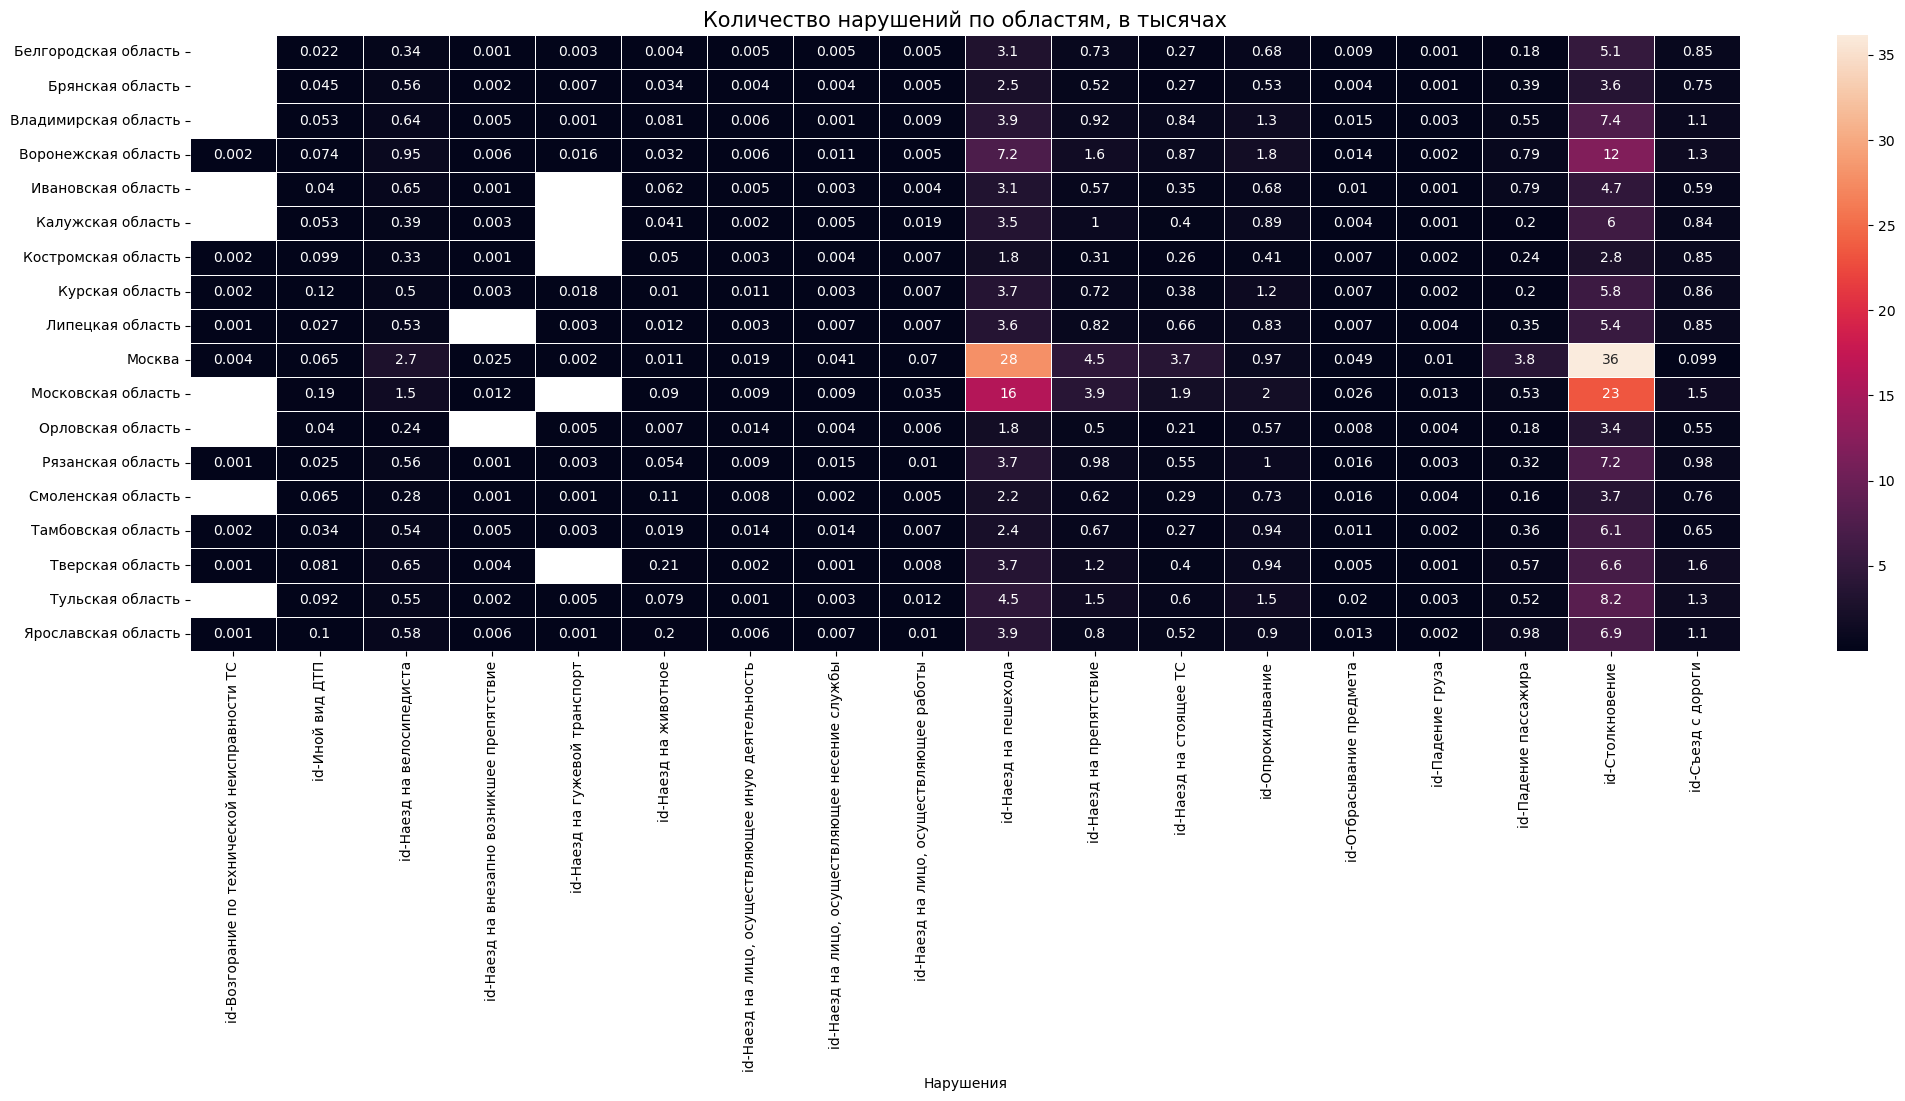

In [89]:
#выведем тепловую карту Количества нарушений по областям
plt.figure(figsize = (25,8))
sns.heatmap(df.explode('category').pivot_table(index=['parent_region'],columns=['category'], \
                             values=['id'], aggfunc= lambda x: x.count()/1000), annot=True, linewidth=.5)
plt.title('Количество нарушений по областям, в тысячах', fontsize = 15)
plt.xlabel('Нарушения')
plt.ylabel('');


Выделим по основному датафрейму df, что аварии с 2015 года и до февраля 2024 года. Больше всего аварий с категорией столкновение - 154090, на втором месте наезд на пешехода - 9838, на сухом покрытии дороги больше всего аварий - 159919, на мокром - 60052,  остальные меньше по числу.

По тепловой карте количества нарушений по областям и таблице отметим, что больше всего аварий по причине Столкновения и наезда на пешехода. Меньшее число занимают нарушения: наезд на препятствие, на стоящее ТС, Опрокидывание и падение пешеходов. Больше всего ДТП отмечено в Москвеи Московской области, особенно лидирует нарушение Столкновение, чуть меньше наезд на пешехода. 

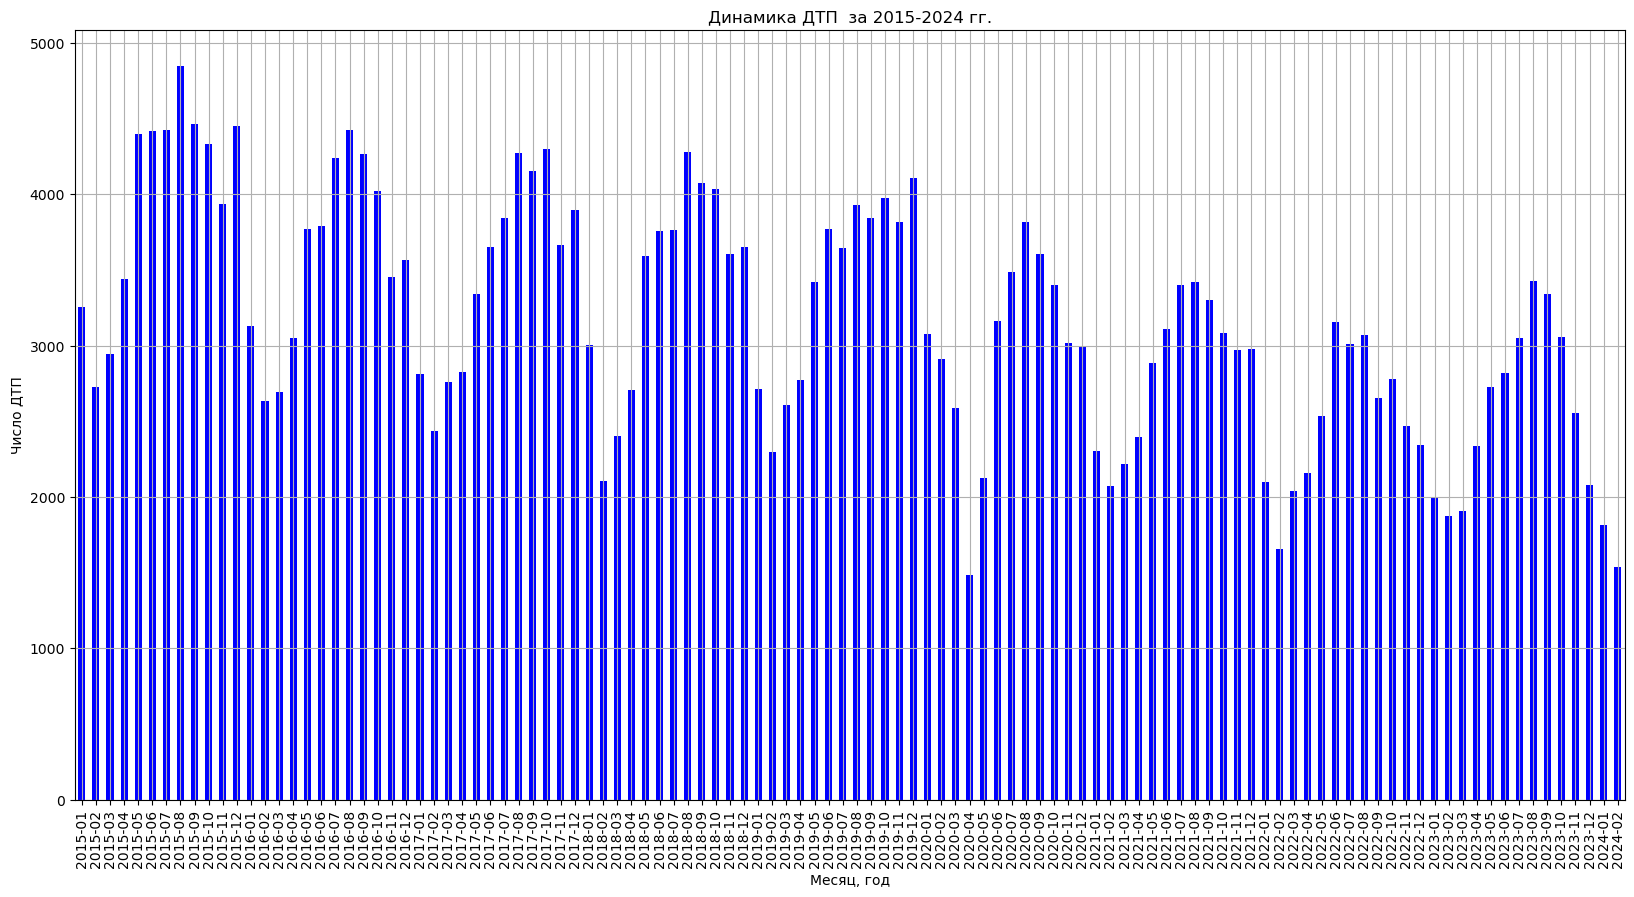

In [90]:
# Посмотрим число ДТП по месяцам.

dat = df['datetime'].dt.to_period("M").sort_values().value_counts(sort=False)
dat.plot(kind='bar', grid=True, figsize=[20, 10],color = 'blue')
plt.title('Динамика ДТП  за 2015-2024 гг.')
plt.xlabel('Месяц, год')
plt.ylabel('Число ДТП');

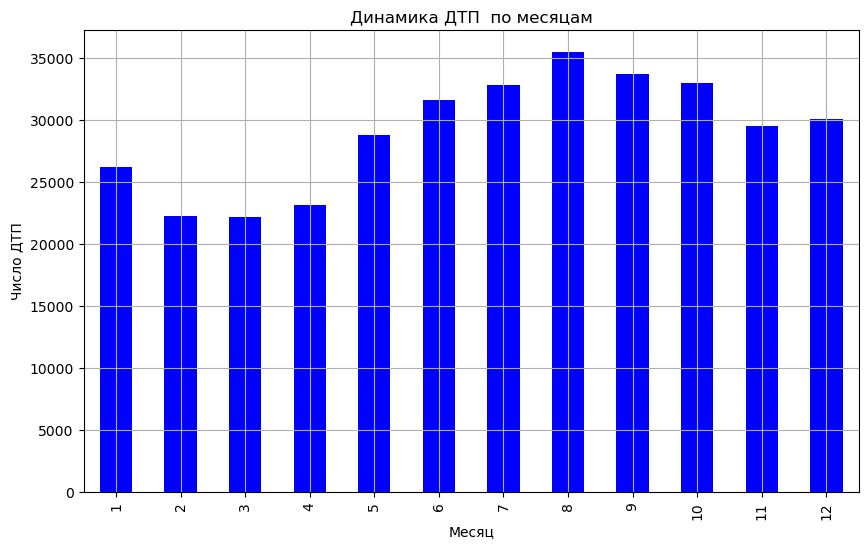

In [91]:
# Посмотрим число ДТП по месяцам.

dat = df['datetime'].dt.month.sort_values().value_counts(sort=False)
dat.plot(kind='bar', grid=True, figsize=[10, 6],color = 'blue')
plt.title('Динамика ДТП  по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Число ДТП');

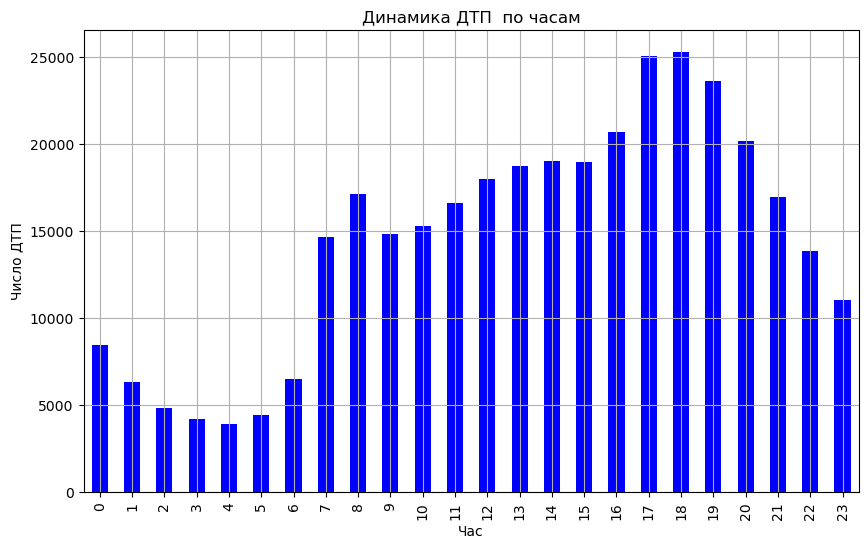

In [92]:
# Посмотрим число ДТП по месяцам.

dat = df['datetime'].dt.hour.sort_values().value_counts(sort=False)
dat.plot(kind='bar', grid=True, figsize=[10, 6],color = 'blue')
plt.title('Динамика ДТП  по часам')
plt.xlabel('Час')
plt.ylabel('Число ДТП');

По гистограмме распределения Динамики ДТП  за 2015-2024 гг отметим сезонность, когда аварии минимальны: это месяцы февраль-март, а вблизи августа наблюдаются пики ДТП. Возможно, многие на авто не ездят зимой, либо как то аккуратнее водят из-за снежных покровов. А к августу активны очень студенты, люди возвращаются с отпусков, готовят детей к школе и из-за этого увеличение аварий.

Также по гистограмме динамики ДТП по времени видим, что минимум аварий приходится ночное время, после полуночи и до 6 утра. Затем резкий скачок в 7, 8 часов говорит о спешке людей на работу, ну, а самый пик приходится на 17-19 часов, когда все возвращаются домой.

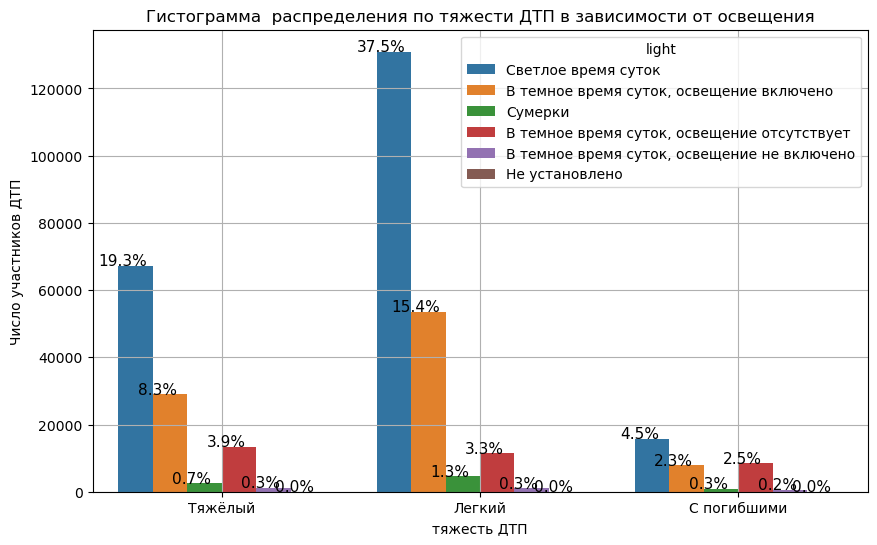

In [93]:
#Построим гистограмму распределения по тяжести ДТП в зависимости от освещения
plt.figure(figsize=(10, 6))
ax=sns.countplot(hue = df['light'], x ='severity' ,\
              data = df)

plt.title('Гистограмма  распределения по тяжести ДТП в зависимости от освещения')
plt.xlabel( 'тяжесть ДТП')
plt.ylabel('Число участников ДТП')
without_hue(ax,df['light'])
plt.grid(True)

plt.show();

In [104]:
#создадим сводную таблицу по освещенности и категориии тяжести ДТП
z= df.pivot_table(index='light',
                         columns='severity',
                         values = 'id',
                         aggfunc='count', margins=True)
z

severity                                     Легкий  С погибшими  Тяжёлый  \
light                                                                       
В темное время суток, освещение включено      53538         7920    29068   
В темное время суток, освещение не включено    1025          551     1149   
В темное время суток, освещение отсутствует   11505         8577    13444   
Не установлено                                    8            2        2   
Светлое время суток                          130925        15763    67253   
Сумерки                                        4567          878     2570   
All                                          201568        33691   113486   

severity                                        All  
light                                                
В темное время суток, освещение включено      90526  
В темное время суток, освещение не включено    2725  
В темное время суток, освещение отсутствует   33526  
Не установлено                                   12  
Светлое время суток                          213941  
Сумерки                                        8015  
All                                          348745

In [105]:
#создадим сводную таблицу по освещенности и категориии тяжести ДТП в % от общего число в строке типа освещенности
for col in z.columns:
    z[col] = np.round(z[col]*100 / z['All'],1)
z

severity                                     Легкий  С погибшими  Тяжёлый  \
light                                                                       
В темное время суток, освещение включено       59.1          8.7     32.1   
В темное время суток, освещение не включено    37.6         20.2     42.2   
В темное время суток, освещение отсутствует    34.3         25.6     40.1   
Не установлено                                 66.7         16.7     16.7   
Светлое время суток                            61.2          7.4     31.4   
Сумерки                                        57.0         11.0     32.1   
All                                            57.8          9.7     32.5   

severity                                       All  
light                                               
В темное время суток, освещение включено     100.0  
В темное время суток, освещение не включено  100.0  
В темное время суток, освещение отсутствует  100.0  
Не установлено                               100.0  
Светлое время суток                          100.0  
Сумерки                                      100.0  
All                                          100.0

In [106]:
#удалим столбец All
z.drop('All',axis=1,inplace = True) 

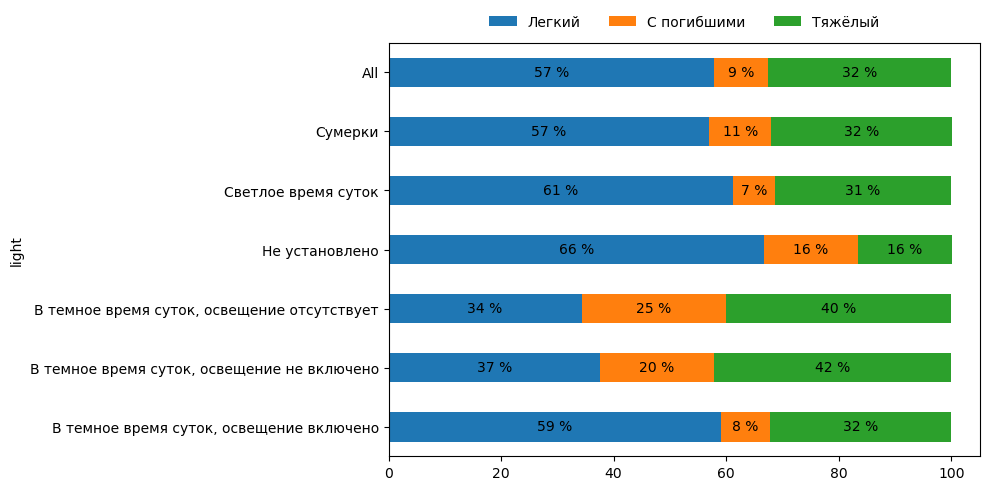

In [107]:
#Выведем график % долей категориий тяжести ДТП  в зависимости от освещенности

z.plot.barh(stacked=True,  figsize=(10,5))
#plt.title('Гистограмма  распределения долей освещенности в категориях тяжести ДТП )
plt.legend(
     bbox_to_anchor=(0.5, 1.02),
     loc="lower center",
     borderaxespad=0,
     frameon=False,
     ncol=3,
    )
for ix, row in z.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in row:
        if element == element and element > 0.1:
            plt.text(
                    cumulative + element / 2,
                    ix,
                    f"{int(element)} %",
                    va="center",
                    ha="center",
                )
            cumulative += element
plt.tight_layout()

plt.show()

 Также по Гистограмме  распределения по тяжести ДТП в зависимости от освещения заметим, что в светлое время суток больше всего аварий, на втором месте аварии в темное время суток, но со освещением. В светлое время суток больше всего аварий с легким исходом.  А вот дороги без освещения и в темное время суток имеют больше аварий с тяжелым исходом, там же и процент погибших достаточно большой. Конечно, важно наличие освещения на дорогах для снижения аварийности и смертности.
 По Гистограмме  распределения долей освещенности в категориях тяжести ДТП отметим также высокий процент смертности 20% и 25% и выше остальных доли с тяжелым исходом у аварий произошедших в темное время суток, где освещение не включено и отсутствует. Что только подчеркивает важность освещения на дорогах. Ведь даже в сумерки процент смертности повышается по сравнению с дневным временем,т.е. , возможно, устанавливать время включения освещения пораньше, либо как то автоматически, когда сумерки наступают.

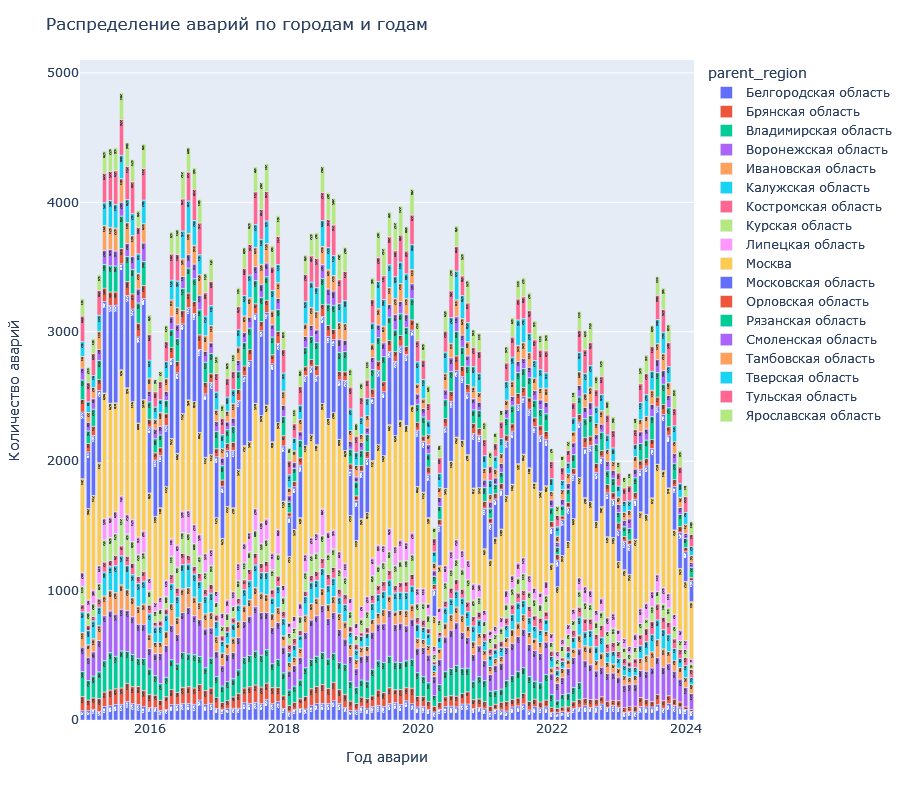

In [108]:
#построим график по сводной таблице - зависимости количество аварий по городам от года
z = df.groupby(['data', 'parent_region'], as_index=False)['id'].count()
# строим график

fig = px.bar(z,
             x='data',
             y='id',
             color='parent_region',
             text='id'
            )

# оформляем график
fig.update_layout(xaxis={'categoryorder':'total descending'},
    title='Распределение аварий по городам и годам',
                   xaxis_title='Год аварии',
                   yaxis_title='Количество аварий',
                   width=1500, # указываем размеры графика
                   height=800)

fig.show() # выводим график

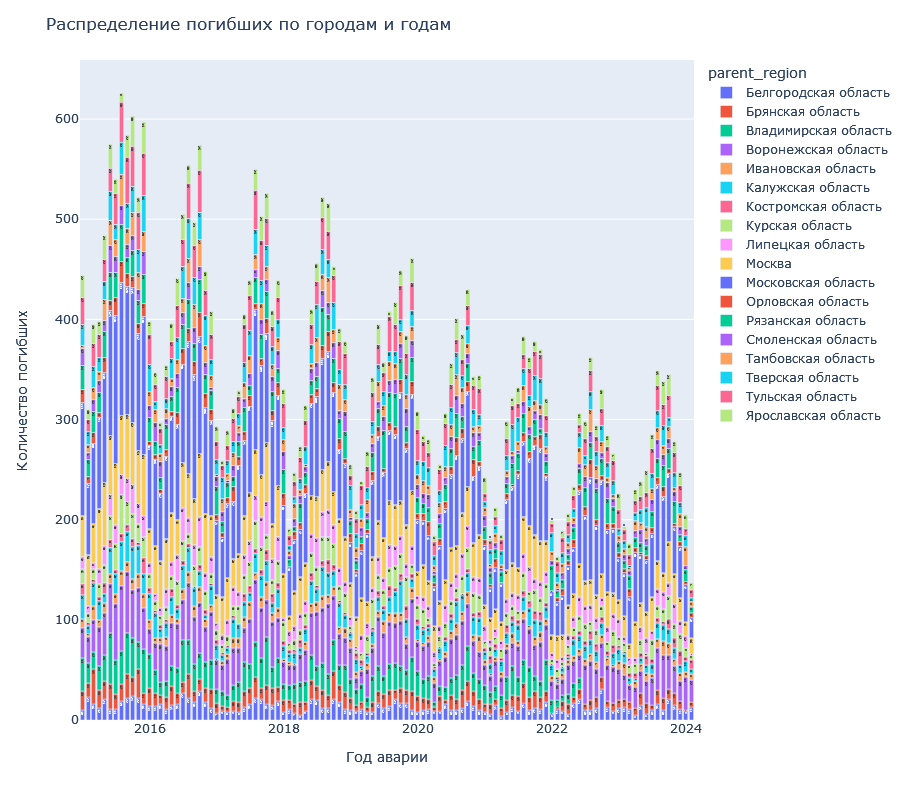

In [109]:
#построим график по сводной таблице - зависимости количество погибших по городам от года
z = df.groupby(['data', 'parent_region'], as_index=False)['dead_count'].sum()
# строим график

fig = px.bar(z,
             x='data',
             y='dead_count',
             color='parent_region',
             text='dead_count'
            )

# оформляем график
fig.update_layout(xaxis={'categoryorder':'total descending'},
    title='Распределение погибших по городам и годам',
                   xaxis_title='Год аварии',
                   yaxis_title='Количество погибших',
                   width=1500, # указываем размеры графика
                   height=800)

fig.show() # выводим график

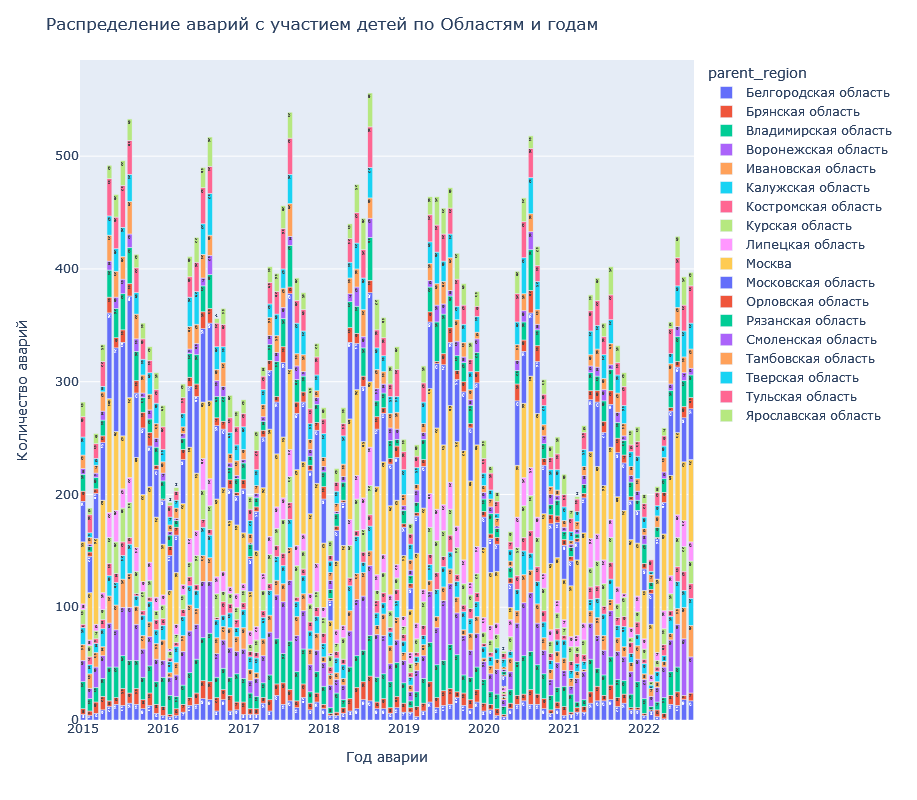

In [110]:
#построим график по сводной таблице - зависимости количество аварий с детьми по городам от года
z = df.query('baby==1').groupby(['data', 'parent_region'], as_index=False)['id'].count()
# строим график

fig = px.bar(z,
             x='data',
             y='id',
             color='parent_region',
             text='id'
            )

# оформляем график
fig.update_layout(xaxis={'categoryorder':'total descending'},
    title='Распределение аварий с участием детей по Областям и годам',
                   xaxis_title='Год аварии',
                   yaxis_title='Количество аварий',
                   width=1500, # указываем размеры графика
                   height=800)

fig.show() # выводим график

In [111]:
#выведем сводную таблицу по годам и Областям с числом аварий
df.pivot_table(index='year',
                         columns='parent_region',
                         values='id',
                         aggfunc='count')

parent_region  Белгородская область  Брянская область  Владимирская область  \
year                                                                          
2015                         1242.0            1402.0                2748.0   
2016                         1368.0            1321.0                2476.0   
2017                         1397.0            1274.0                2404.0   
2018                         1277.0            1263.0                2389.0   
2019                         1323.0            1146.0                2310.0   
2020                         1175.0             874.0                2051.0   
2021                         1089.0             705.0                1916.0   
2022                         1076.0             579.0                 606.0   
2023                         1142.0             632.0                   NaN   
2024                          151.0              33.0                   NaN   

parent_region  Воронежская область  Ивановская область  Калужская область  \
year                                                                        
2015                        3248.0              1706.0             2058.0   
2016                        3088.0              1543.0             1830.0   
2017                        3117.0              1454.0             1578.0   
2018                        3010.0              1308.0             1544.0   
2019                        3115.0              1136.0             1448.0   
2020                        2815.0              1096.0             1264.0   
2021                        2711.0               996.0             1159.0   
2022                        2540.0              1009.0             1114.0   
2023                        2570.0              1154.0             1227.0   
2024                         274.0               144.0              147.0   

parent_region  Костромская область  Курская область  Липецкая область  \
year                                                                    
2015                         762.0           1858.0            1736.0   
2016                         725.0           1616.0            1611.0   
2017                         783.0           1601.0            1643.0   
2018                         751.0           1600.0            1559.0   
2019                         758.0           1652.0            1623.0   
2020                         716.0           1500.0            1424.0   
2021                         819.0           1304.0            1144.0   
2022                         792.0           1162.0            1086.0   
2023                         958.0           1064.0            1225.0   
2024                         123.0            106.0             108.0   

parent_region   Москва  Московская область  Орловская область  \
year                                                            
2015           10396.0              7884.0             1180.0   
2016            9045.0              6832.0             1012.0   
2017            8907.0              6705.0              894.0   
2018            9157.0              5933.0              800.0   
2019            9296.0              5847.0              773.0   
2020            7990.0              4927.0              778.0   
2021            8562.0              4605.0              737.0   
2022            7780.0              4007.0              648.0   
2023            8196.0              3983.0              687.0   
2024             901.0               391.0               59.0   

parent_region  Рязанская область  Смоленская область  Тамбовская область  \
year                                                                       
2015                      2094.0              1233.0              1715.0   
2016                      1812.0              1089.0              1511.0   
2017                      1818.0               999.0              1425.0   
2018                      1827.0              1035.0              1412.0   
2019        

По сводной таблице числа аварий по годам и областям видим, что во Владимирской области отсутсвуют данные за 2023 и 2024 год совсем. И многих областей число ДТп увеличилось к 2023 году по сравнению с 2022 году, изучим далее статистическую разницу.

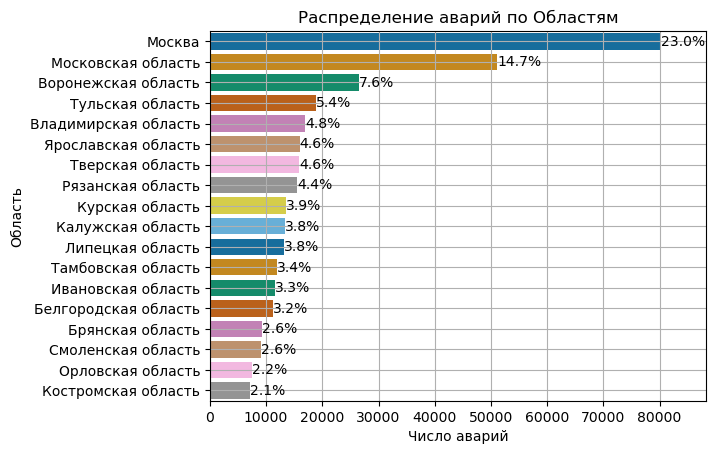

In [112]:
#выведем график распределения аварий по Областям
ax = sns.countplot(y='parent_region', data=df, palette='colorblind',  order=df['parent_region'].value_counts().index)

# сохраним общее число аварий
total = df['parent_region'].count()

#создадим подписи долей аварий
ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/total)*100:0.1f}%')
ax.margins(x=0.1)
ax.set(xlabel='Число аварий', ylabel='Область', title='Распределение аварий по Областям')
plt.grid(True)
plt.show()

Как видим, в базе **отсутствуют данные по Владимирской области об авариях за 2023 год**, поэтому статистика может быть искажена, где фигурирует данная область. Также **отсутствуют аварии с детьми за 2023 год** полностью.

На первом месте по числу аварий Москва - 23%, Московская область - 14,7%, Воронежская на третьем месте 7,6%.

Отметим, что тенденция снижения аварий и числа погибших есть из года в год, особенно по авариям с участием детей. Много аварий с детским участием прослеживается в Москве, Московской области, но и во Владимирской области, а вот в **2022 году** тенденция аварий с детьми практически во всех областях **снизилась в двое**, особенно во Владимирской. Либо какие то проблемы с выгрузкой или заполнением категории Детей в авариях начились уже в 2022 году, а в 2023 вообще прекратилось. Либо правда снизились аварии с детьми.

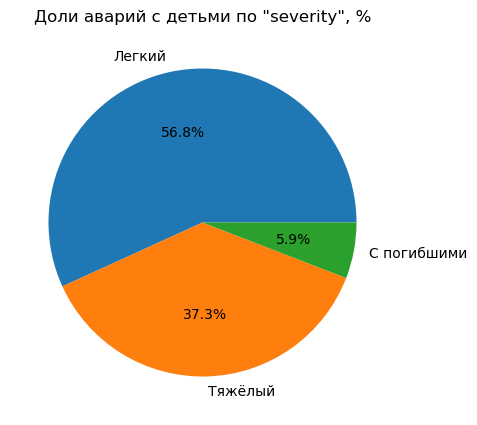

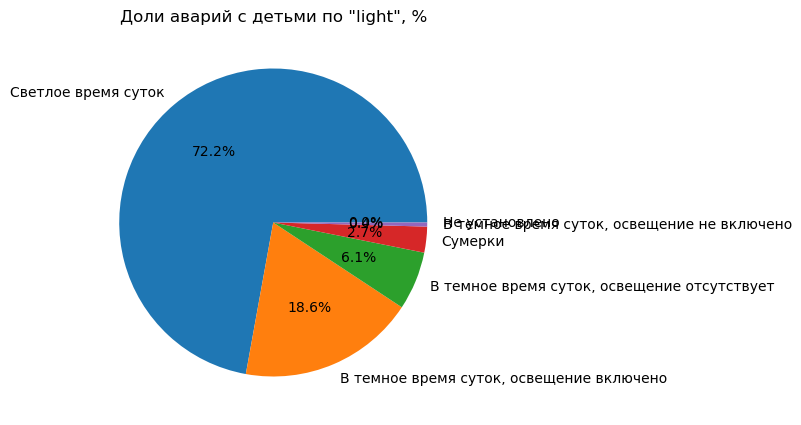

In [113]:
#построим график зависимости долей участников ДТП по категориям вреда здоровья с участием детей
for col in df.query('baby==1')[['severity', 'light']].columns:

    category = df.query('baby==1')[col].value_counts()

    fig1, ax1 = plt.subplots(figsize=(5, 5))
    ax1.pie(category,labels=category.index, autopct='%1.1f%%')
    ax1.set_title(f'Доли аварий с детьми по "{col}", %');
    plt.show()

Про аварии с участием детей также можно ответить, что 55,6% с легкими последствиями, 35,2% с тяжелыми и 9,2% с погибшими. 70,2% аварий с детьми происходит в светлое время суток.

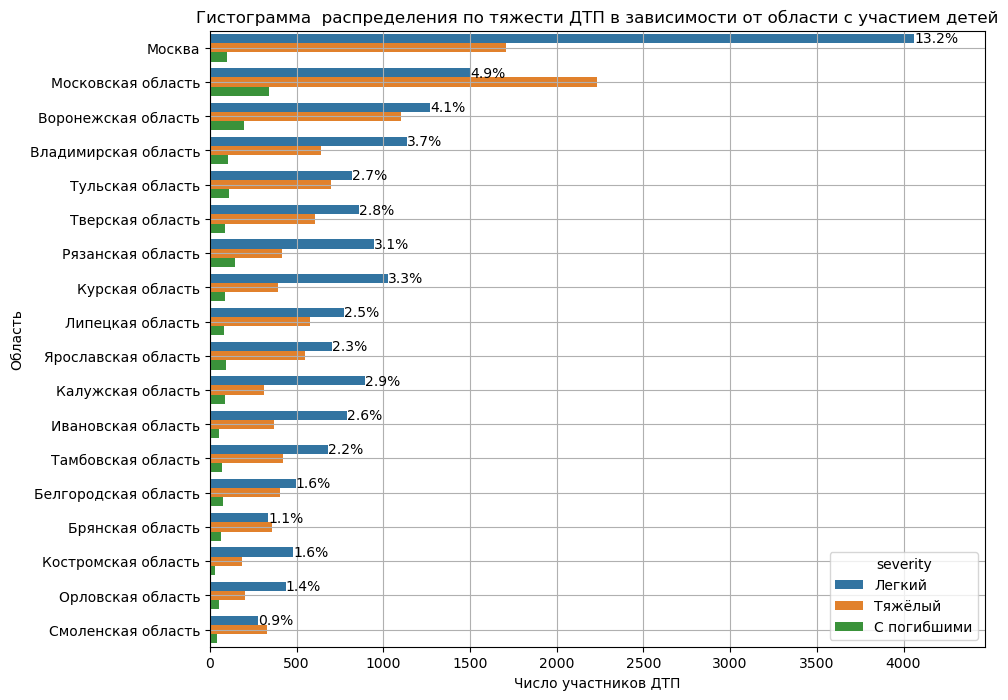

In [114]:
#Построим гистограмму распределения по тяжести ДТП в зависимости от освещения с участием детей
plt.figure(figsize=(10, 8))
ax=sns.countplot(hue = df.query('baby==1')['severity'], y ='parent_region' ,\
              data = df.query('baby==1'), order=df.query('baby==1')['parent_region'].value_counts().index)

plt.title('Гистограмма  распределения по тяжести ДТП в зависимости от области с участием детей')
plt.ylabel( 'Область')
plt.xlabel('Число участников ДТП')
# сохраним общее число аварий
total = df.query('baby==1')['parent_region'].count()

#создадим подписи долей аварий
ax.bar_label(ax.containers[0], fmt=lambda x: f'{(x/total)*100:0.1f}%')
ax.margins(x=0.1)

plt.grid(True)

plt.show();

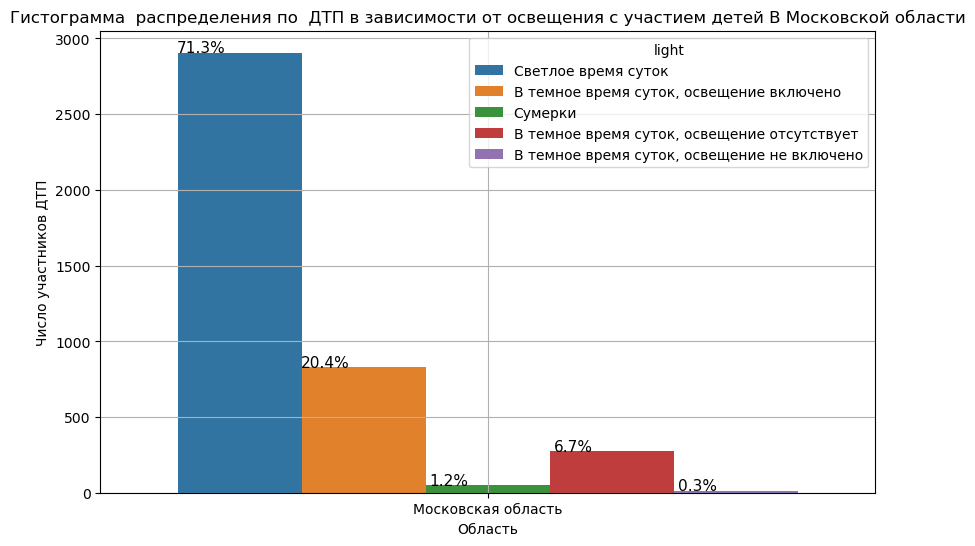

In [115]:
#Построим гистограмму распределения по тяжести ДТП в зависимости от освещения с участием детей в Московской области
plt.figure(figsize=(10, 6))
ax=sns.countplot(hue = df.query('baby==1 & parent_region=="Московская область"')['light'], x ='parent_region' ,\
              data = df.query('baby==1 & parent_region=="Московская область"'))

plt.title('Гистограмма  распределения по  ДТП в зависимости от освещения с участием детей В Московской области')
plt.xlabel( 'Область')
plt.ylabel('Число участников ДТП')
without_hue(ax,df.query('baby==1 & parent_region=="Московская область"')['light'])
plt.grid(True)

plt.show();

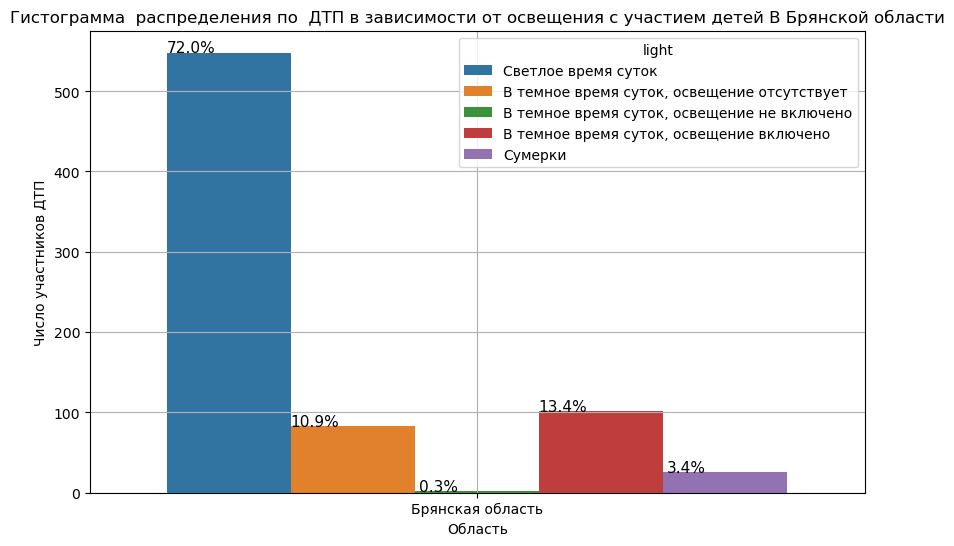

In [116]:
#Построим гистограмму распределения по тяжести ДТП в зависимости от освещения с участием детей в Брянской области
plt.figure(figsize=(10, 6))
ax=sns.countplot(hue = df.query('baby==1 & parent_region=="Брянская область"')['light'], x ='parent_region' ,\
              data = df.query('baby==1 & parent_region=="Брянская область"'))

plt.title('Гистограмма  распределения по  ДТП в зависимости от освещения с участием детей В Брянской области')
plt.xlabel( 'Область')
plt.ylabel('Число участников ДТП')
without_hue(ax,df.query('baby==1 & parent_region=="Брянская область"')['light'])
plt.grid(True)

plt.show();

In [117]:
#нарушения участников ДТП с детьми в Брянской области, первые 15
df_foot_part.query('baby==1 & parent_region=="Брянская область"')['violations'].value_counts().head(15)

violations
[]                                                                                                                                                                        1268
[Другие нарушения ПДД водителем]                                                                                                                                            83
[Несоблюдение очередности проезда]                                                                                                                                          63
[Нарушение правил проезда пешеходного перехода]                                                                                                                             54
[Иные нарушения]                                                                                                                                                            32
[Несоблюдение очередности проезда перекрестков]                                                                   

In [118]:
#нарушения участников ДТП с детьми в Московской области, первые 15
df_foot_part.query('baby==1 & parent_region=="Московская область"')['violations'].value_counts().head(15)

violations
[]                                                                                                                                                                        7447
[Нарушение правил проезда пешеходного перехода]                                                                                                                            462
[Несоблюдение очередности проезда]                                                                                                                                         360
[Несоответствие скорости конкретным условиям движения]                                                                                                                     287
[Неправильный выбор дистанции]                                                                                                                                             269
[Переход через проезжую часть вне пешеходного перехода в зоне его видимости либо при наличии в непосредственной бл

In [119]:
#стаж водителей  с участием детей в Московской области, первые 10, начиная с 2021
df_foot_part.query('baby==1 & parent_region=="Московская область" & year>=2021')['years_of_driving_experience'].value_counts().head(10)

years_of_driving_experience
0.0     104
13.0     51
15.0     45
9.0      44
16.0     43
19.0     42
14.0     42
12.0     40
20.0     39
17.0     38
Name: count, dtype: int64

In [120]:
#стаж водителей  с участием детей в Брянской области, первые 10, начиная с 2021
df_foot_part.query('baby==1 & parent_region=="Брянская область" & year>=2021')['years_of_driving_experience'].value_counts().head(10)

years_of_driving_experience
0.0     23
13.0    15
6.0     10
15.0     9
14.0     9
2.0      9
26.0     6
1.0      6
10.0     6
16.0     6
Name: count, dtype: int64

Интересно отметить, что тенденция аварий с тяжелым исходом превышает остальные в Московской области и там же больше всего погибших в авариях с детьми. А в Москве меньше всего погибших участников с детьми.

По графику Распределения аварий с участием детей по Областям и годам, выделив лишь Московскую область, заметна сезонность аварий с детьми. Это преимущественно летние месяцы и май, соответсвенно когда у детей каникулы и майские праздники, вместе с детьми едут в подмосковье отдыхать, большие пробки, видимо, и там не так безопасны дороги- меньше светофоров, камер на соблюдение скоростного режима и прочих приспособлений, также пассажиры с детьми не пристегиваются или управление в алкогольном опьянении. Также в первой десятке стажей водителей с участием детей в Московской области имеется **стаж 0 лет**, а это значит, что дети-водители за рулем, попадающие в аварии. А с 2021 года дети-водители на первом месте по числу ДТП в Московской области.

В Брянкой области также превалируют тяжелые ДТП с участием детей. Также присутсвуют дети-водители на первом месте по числу  ДТП  с 2021 года.

# Шаг 3. Статистический анализ данных <a id="Шаг_3._Статистический_анализ_данных"></a>

## Шаг 3.1 Гипотезы по Женщинам <a id="Шаг_3.1_Гипотезы_по_женщинам"></a>

**1 Гипотеза**

H0 - Женщины со стажем от 0-4 лет и от 5-8 лет в равной доле нарушают правила ДТП

H1 - Женщины со стажем от 0-4 лет и от 5-8 лет в разной доле нарушают правила ДТП

**2 Гипотеза**

H0 - Женщины со стажем 5-8 лет и 9-13 лет в равной доле нарушают правила ДТП

H1 -  Женщины со стажем 5-8 лет и 9-13 лет лет в разной доле нарушают правила ДТП

**3 Гипотеза**

H0 -  Женщины со стажем 9-13 лет и 14-29 лет в равной доле нарушают правила ДТП

H1 -  Женщины со стажем 9-13 лет и 14-29 лет в разной доле нарушают правила ДТП

**4 Гипотеза**

H0 - Женщины со стажем от 0-4 лет и от 5-8 лет в равной доле раненые в ДТП

H1 - Женщины со стажем от 0-4 лет и от 5-8 лет в разной доле раненые в ДТП

**5 Гипотеза**

H0 - Женщины со стажем 5-8 лет и 9-13 лет в равной доле раненые в ДТП

H1 -  Женщины со стажем 5-8 лет и 9-13 лет лет в разной раненые в ДТП

**6 Гипотеза**

H0 -  Женщины со стажем 9-13 лет и 14-29 лет в равной доле раненые в ДТП

H1 -  Женщины со стажем 9-13 лет и 14-29 лет в разной доле раненые в ДТП


**7 Гипотеза**

H0 - Женщины со стажем от 0-4 лет и от 5-8 лет в равной доле погибают в ДТП

H1 - Женщины со стажем от 0-4 лет и от 5-8 лет в разной доле погибают в ДТП

**8 Гипотеза**

H0 - Женщины со стажем 5-8 лет и 9-13 лет в равной доле погибают в ДТП

H1 -  Женщины со стажем 5-8 лет и 9-13 лет в разной доле погибают в ДТП

**9 Гипотеза**

H0 - Женщины со стажем 9-13 лет и 14-29 лет в равной доле погибают в ДТП

H1 -  Женщины со стажем 9-13 лет и 14-29 лет в разной доле погибают в ДТП



In [48]:
#создадим столбец с категориями по стажу вождения Женщин, квинтили
df_foot_part['category_year_driving_W'] = pd.qcut(df_foot_part.\
                                                query('gender == "Женский" & years_of_driving_experience<= @release_max_years_dr_w')['years_of_driving_experience'],\
                                                                                                    q=4, labels=['0-4', '5-8', '9-13','14-29' ])
df_foot_part['category_year_driving_W'].value_counts()

category_year_driving_W
0-4      22612
14-29    19236
5-8      18035
9-13     17817
Name: count, dtype: int64

In [49]:
#выведем число участников, нарушителей,  раненых и погибших в авариях  женщин с разным стажем
Women_years = df_foot_part.query('gender=="Женский"').pivot_table(index='category_year_driving_W',
                         values=['id','category_violations','hurt','dead'],
                         aggfunc={'category_violations':'sum','id':'count','dead':'sum','hurt':'sum'})
Women_years = Women_years.rename( columns={'category_violations':'Нарушителей','dead':'Число_погибших', 'hurt': 'Число_раненых', 'id':'Число_аварий'})
Women_years

Нарушителей  Число_погибших  Число_раненых  \
category_year_driving_W                                               
0-4                            15323             416          10940   
5-8                            10507             283           8037   
9-13                            9808             232           7212   
14-29                          10237             237           7097   

                         Число_аварий  
category_year_driving_W                
0-4                             22612  
5-8                             18035  
9-13                            17817  
14-29                           19236

In [50]:
#добавим столбцы доли нарушителей и доли погибших в %
Women_years['Доля_наруш']= round(Women_years['Нарушителей']/Women_years['Число_аварий']*100, 1)
Women_years['Доля_ранен']= round(Women_years['Число_раненых']/Women_years['Число_аварий']*100, 1)
Women_years['Доля_погибш']= round(Women_years['Число_погибших']/Women_years['Число_аварий']*100, 2)
Women_years

Нарушителей  Число_погибших  Число_раненых  \
category_year_driving_W                                               
0-4                            15323             416          10940   
5-8                            10507             283           8037   
9-13                            9808             232           7212   
14-29                          10237             237           7097   

                         Число_аварий  Доля_наруш  Доля_ранен  Доля_погибш  
category_year_driving_W                                                     
0-4                             22612        67.8        48.4         1.84  
5-8                             18035        58.3        44.6         1.57  
9-13                            17817        55.0        40.5         1.30  
14-29                           19236        53.2        36.9         1.23

In [51]:
#напишем функцию получения p_value с заданием alpha- критический уровень статистической значимости
def st_test(successes0, successes1, trials0, trials1, alpha):

# пропорция успехов в первой группе:
    p1 = successes0 / trials0
# пропорция успехов во второй группе:
    p2 = successes1 / trials1
# пропорция успехов в комбинированном датасете:
    p_combined = (successes0 + successes1) / (trials0 + trials1)
# разница пропорций в датасетах
    difference = p1 - p2
# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials0 + 1/trials1))
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

In [52]:
#создадим таблицу для вывода результатов по определению разницы между группами 0_4, 5_8, 9_13, 14-29
#Применим критический уровень статистической значимости 0,05

AB_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

for i in range(3):
    group_1 = Women_years.index[i]
    current_row = Women_years.loc[group_1]
    group_2 = Women_years.index[i+1]
    for event_number in range(3):
        curr_W = Women_years.columns[event_number]
        p_value_result = st_test(current_row[curr_W],
                                       Women_years[curr_W][group_2],
                                       current_row['Число_аварий'],
                                       Women_years['Число_аварий'][group_2],
                                       alpha = .05
                               )
        new_row = pd.DataFrame({'Группа_1': [group_1],
                   'Группа_2': [group_2],
                   'Событие': [f'{Women_years.columns[event_number]}'],
                   'p_alpha': [0.05],
                   'p_value': [round(p_value_result, 5)],
                   'Результат': [f'{result_options[p_value_result >= 0.05]}']})
        AB_pivot = pd.concat([AB_pivot, new_row], ignore_index=True)

pd.options.display.max_colwidth = 150
AB_pivot.index = range(len(AB_pivot))
AB_pivot

Группа_1 Группа_2         Событие  p_alpha  p_value  \
0      0-4      5-8     Нарушителей     0.05  0.00000   
1      0-4      5-8  Число_погибших     0.05  0.03711   
2      0-4      5-8   Число_раненых     0.05  0.00000   
3      5-8     9-13     Нарушителей     0.05  0.00000   
4      5-8     9-13  Число_погибших     0.05  0.03361   
5      5-8     9-13   Число_раненых     0.05  0.00000   
6     9-13    14-29     Нарушителей     0.05  0.00041   
7     9-13    14-29  Число_погибших     0.05  0.54667   
8     9-13    14-29   Число_раненых     0.05  0.00000   

                                                                       Результат  
0            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
1            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
2            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
3            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
4            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
5            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
6            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
7  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными  
8            Отвергаем нулевую гипотезу - между долями есть статзначимая разница

Скорректируем уровень значимости для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез, для этого используем поправку Шидака.


In [53]:
#введем формулу поправки Шидака
alpha = 0.05 # критический уровень статистической значимости
m = 3 #число сравнений
Shidaka = 1-(1-alpha)**(1/m)

In [54]:
#создадим таблицу для вывода результатов по определению разницы между группами 0_4, 5_8, 9_13, 14-29
#Применим критический уровень статистической значимости 0,05

AB_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

for i in range(3):
    group_1 = Women_years.index[i]
    current_row = Women_years.loc[group_1]
    group_2 = Women_years.index[i+1]
    for event_number in range(3):
        curr_W = Women_years.columns[event_number]
        p_value_result = st_test(current_row[curr_W],
                                       Women_years[curr_W][group_2],
                                       current_row['Число_аварий'],
                                       Women_years['Число_аварий'][group_2],
                                       Shidaka
                               )
        new_row = pd.DataFrame({'Группа_1': [group_1],
                   'Группа_2': [group_2],
                   'Событие': [f'{Women_years.columns[event_number]}'],
                   'p_alpha': [Shidaka],
                   'p_value': [round(p_value_result, 5)],
                   'Результат': [f'{result_options[p_value_result >= Shidaka]}']})
        AB_pivot = pd.concat([AB_pivot, new_row], ignore_index=True)

pd.options.display.max_colwidth = 150
AB_pivot.index = range(len(AB_pivot))
AB_pivot

Группа_1 Группа_2         Событие   p_alpha  p_value  \
0      0-4      5-8     Нарушителей  0.016952  0.00000   
1      0-4      5-8  Число_погибших  0.016952  0.03711   
2      0-4      5-8   Число_раненых  0.016952  0.00000   
3      5-8     9-13     Нарушителей  0.016952  0.00000   
4      5-8     9-13  Число_погибших  0.016952  0.03361   
5      5-8     9-13   Число_раненых  0.016952  0.00000   
6     9-13    14-29     Нарушителей  0.016952  0.00041   
7     9-13    14-29  Число_погибших  0.016952  0.54667   
8     9-13    14-29   Число_раненых  0.016952  0.00000   

                                                                       Результат  
0            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
1  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными  
2            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
3            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
4  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными  
5            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
6            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
7  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными  
8            Отвергаем нулевую гипотезу - между долями есть статзначимая разница

После корректировки уровеня значимости для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез, с применением формулы Шитака, проверка гипотез о Женщинах водителях имеют  результат по погибшим иной.

Доли нарушителей и раненых   женщин со стажем 0-4, 5-8, 9-13  **имеют статистическую разницу**.

Женщины погибают в равной доле с любым стажем.

По таблице хочу также добавить, что больше всего нарушают, получают ранения  женщины со стажем 0-4 лет. Меньше всего нарушают, получают ранения  женщины водители со стажем 14-29.

## Шаг 3.2 Гипотезы по Мужчинам <a id="Шаг_3.2_Гипотезы_по_Мужчинам"></a>

**10 Гипотеза**

H0 - Мужчины со стажем  0-5 лет и 6-12 нарушают правила ДТП в равной доле

H1 - Мужчины со стажем  0-5 лет и 6-12 нарушают правила ДТП в разной  доле

**11 Гипотеза**

H0 - Мужчины со стажем  6-12 лет и 13-22 нарушают правила ДТП в равной доле

H1 - Мужчины со стажем  6-12 лет и 13-22 нарушают правила ДТП в разной  доле

**12 Гипотеза**

H0 - Мужчины со стажем 13-22 лет и 23-47,5 нарушают правила ДТП в равной доле

H1 - Мужчины со стажем 13-22 лет и 23-47,5 нарушают правила ДТП в разной доле

**13 Гипотеза**

H0 - Мужчины со стажем  0-5 лет и 6-12 раненые в ДТП в равной доле

H1 - Мужчины со стажем  0-5 лет и 6-12 раненые в ДТП в разной  доле

**14 Гипотеза**

H0 - Мужчины со стажем  6-12 лет и 13-22 раненые в ДТП в равной доле

H1 - Мужчины со стажем  6-12 лет и 13-22 раненые в ДТП в разной  доле

**15 Гипотеза**

H0 - Мужчины со стажем 13-22 лет и 23-47,5 раненые в ДТП в равной доле

H1 - Мужчины со стажем 13-22 лет и 23-47,5 раненые в ДТП в разной доле

**16 Гипотеза**

H0 - Мужчины со стажем  0-5 лет и 6-12 погибают в ДТП в равной доле

H1 - Мужчины со стажем  0-5 лет и 6-12 погибают в ДТП в разной  доле

**17 Гипотеза**

H0 - Мужчины со стажем  6-12 лет и 13-22 погибают в ДТП в равной доле

H1 - Мужчины со стажем  6-12 лет и 13-22 погибают в ДТП в разной  доле

**18 Гипотеза**

H0 - Мужчины со стажем 13-22 лет и 23-47,5 погибают в ДТП в равной доле

H1 - Мужчины со стажем 13-22 лет и 23-47,5 погибают в ДТП в разной доле



In [55]:
#создадим столбец с категориями по стажу вождения Мужчин, квинтили
df_foot_part['category_year_driving_M'] = pd.qcut(df_foot_part.\
         query('gender == "Мужской" & years_of_driving_experience<=@release_max_years_dr_m')['years_of_driving_experience'], q=4, labels=['0-5', '6-12', '13-22', '23-47.5'])
df_foot_part['category_year_driving_M'].value_counts()

category_year_driving_M
0-5        119810
13-22      119380
6-12       111429
23-47.5    105237
Name: count, dtype: int64

In [56]:
#выведем число участников, нарушителей,  раненых и погибших в авариях  мужчин с разным стажем
men_years = df_foot_part.query('gender=="Мужской"').pivot_table(index='category_year_driving_M',
                         values=['id','category_violations','hurt','dead'],
                         aggfunc={'category_violations':'sum','id':'count','dead':'sum','hurt':'sum'})
men_years = men_years.rename( columns={'category_violations':'Нарушителей','dead':'Число_погибших', 'hurt': 'Число_раненых', 'id':'Число_аварий'})
men_years

Нарушителей  Число_погибших  Число_раненых  \
category_year_driving_M                                               
0-5                            89461            4634          45146   
6-12                           66235            3064          31156   
13-22                          67548            3487          30695   
23-47.5                        59948            3557          24798   

                         Число_аварий  
category_year_driving_M                
0-5                            119810  
6-12                           111429  
13-22                          119380  
23-47.5                        105237

In [57]:
#добавим столбцы доли нарушителей и доли погибших в %
men_years['Доля_наруш']= round(men_years['Нарушителей']/men_years['Число_аварий']*100, 1)
men_years['Доля_ранен']= round(men_years['Число_раненых']/men_years['Число_аварий']*100, 1)
men_years['Доля_погибш']= round(men_years['Число_погибших']/men_years['Число_аварий']*100, 2)
men_years

Нарушителей  Число_погибших  Число_раненых  \
category_year_driving_M                                               
0-5                            89461            4634          45146   
6-12                           66235            3064          31156   
13-22                          67548            3487          30695   
23-47.5                        59948            3557          24798   

                         Число_аварий  Доля_наруш  Доля_ранен  Доля_погибш  
category_year_driving_M                                                     
0-5                            119810        74.7        37.7         3.87  
6-12                           111429        59.4        28.0         2.75  
13-22                          119380        56.6        25.7         2.92  
23-47.5                        105237        57.0        23.6         3.38

In [58]:
#создадим таблицу для вывода результатов по определению разницы между группами 0_5, 6_12, 13_22, 23-47,5
#Применим критический уровень статистической значимости 0,05

AB_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

for i in range(3):
    group_1 = men_years.index[i]
    current_row = men_years.loc[group_1]
    group_2 = men_years.index[i+1]
    for event_number in range(3):
        curr_W = men_years.columns[event_number]
        p_value_result = st_test(current_row[curr_W],
                                       men_years[curr_W][group_2],
                                       current_row['Число_аварий'],
                                       men_years['Число_аварий'][group_2],
                                       alpha = .05
                               )
        new_row = pd.DataFrame({'Группа_1': [group_1],
                   'Группа_2': [group_2],
                   'Событие': [f'{men_years.columns[event_number]}'],
                   'p_alpha': [0.05],
                   'p_value': [round(p_value_result, 5)],
                   'Результат': [f'{result_options[p_value_result >= 0.05]}']})
        AB_pivot = pd.concat([AB_pivot, new_row], ignore_index=True)

pd.options.display.max_colwidth = 150
AB_pivot.index = range(len(AB_pivot))
AB_pivot

Группа_1 Группа_2         Событие  p_alpha  p_value  \
0      0-5     6-12     Нарушителей     0.05  0.00000   
1      0-5     6-12  Число_погибших     0.05  0.00000   
2      0-5     6-12   Число_раненых     0.05  0.00000   
3     6-12    13-22     Нарушителей     0.05  0.00000   
4     6-12    13-22  Число_погибших     0.05  0.01333   
5     6-12    13-22   Число_раненых     0.05  0.00000   
6    13-22  23-47.5     Нарушителей     0.05  0.06791   
7    13-22  23-47.5  Число_погибших     0.05  0.00000   
8    13-22  23-47.5   Число_раненых     0.05  0.00000   

                                                                       Результат  
0            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
1            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
2            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
3            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
4            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
5            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
6  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными  
7            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
8            Отвергаем нулевую гипотезу - между долями есть статзначимая разница

Доли раненых и погибших мужчин со стажем между 0-5 и 6-12, 6-12 и 13-22, 13-22 и 23-47.5  имеют статистическую разницу.  Доля нарушителей со стажем 13-22 и 23-47,5 одинакова.

Причем, по таблице отметим, что число аварий, доля нарушителей и раненых мужчин и погибших больше всего со стажем 0-5 лет.  После 23 лет стажа доля погибших опять возрастает по сравнению с 13-22 годами, хотя нарушают одинаково.

Скорректируем уровень значимости для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез, для этого используем поправку Шидака.

In [59]:
#введем формулу поправки Шидака
alpha = 0.05 # критический уровень статистической значимости
m = 3 #число сравнений
Shidaka = 1-(1-alpha)**(1/m)

In [60]:
#создадим таблицу для вывода результатов по определению разницы между группами 0_5, 6_12, 13_22, 23-47,5
#Применим критический уровень статистической значимости 0,05

AB_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

for i in range(3):
    group_1 = men_years.index[i]
    current_row = men_years.loc[group_1]
    group_2 = men_years.index[i+1]
    for event_number in range(3):
        curr_W = men_years.columns[event_number]
        p_value_result = st_test(current_row[curr_W],
                                       men_years[curr_W][group_2],
                                       current_row['Число_аварий'],
                                       men_years['Число_аварий'][group_2],
                                       Shidaka
                               )
        new_row = pd.DataFrame({'Группа_1': [group_1],
                   'Группа_2': [group_2],
                   'Событие': [f'{men_years.columns[event_number]}'],
                   'p_alpha': [Shidaka],
                   'p_value': [round(p_value_result, 5)],
                   'Результат': [f'{result_options[p_value_result >= Shidaka]}']})
        AB_pivot = pd.concat([AB_pivot, new_row], ignore_index=True)

pd.options.display.max_colwidth = 150
AB_pivot.index = range(len(AB_pivot))
AB_pivot

Группа_1 Группа_2         Событие   p_alpha  p_value  \
0      0-5     6-12     Нарушителей  0.016952  0.00000   
1      0-5     6-12  Число_погибших  0.016952  0.00000   
2      0-5     6-12   Число_раненых  0.016952  0.00000   
3     6-12    13-22     Нарушителей  0.016952  0.00000   
4     6-12    13-22  Число_погибших  0.016952  0.01333   
5     6-12    13-22   Число_раненых  0.016952  0.00000   
6    13-22  23-47.5     Нарушителей  0.016952  0.06791   
7    13-22  23-47.5  Число_погибших  0.016952  0.00000   
8    13-22  23-47.5   Число_раненых  0.016952  0.00000   

                                                                       Результат  
0            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
1            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
2            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
3            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
4            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
5            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
6  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными  
7            Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
8            Отвергаем нулевую гипотезу - между долями есть статзначимая разница

После корректировки уровеня значимости для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез, с применением формулы Шитака, проверка гипотез о Мужчинах водителях имеют тот же результат.

## Шаг3.3 Гипотезы о Мужчинах и Женщинах <a id="Шаг_3.3_Гипотезы_о_Мужчинах_и_Женщинах"></a>

**19 Гипотеза**

H0 - Мужчины  И Женщины со стажем  0-5  нарушают правила ДТП в равной доле

H1 - Мужчины И Женщины со стажем  0-5  нарушают правила ДТП в разной доле

**20 Гипотеза**

H0 - Мужчины И Женщины  со стажем  6-11 лет нарушают правила ДТП в равной доле

H1 - Мужчины И Женщины со стажем  6-11 лет нарушают правила ДТП в разной доле

**21 Гипотеза**

H0 - Мужчины И Женщины  со стажем  12-20 лет нарушают правила ДТП в равной доле

H1 - Мужчины И Женщины со стажем  12-20 лет нарушают правила ДТП в разной доле

**22 Гипотеза**

H0 - Мужчины И Женщины  со стажем  21-45 лет нарушают правила ДТП в равной доле

H1 - Мужчины И Женщины со стажем  21-45 лет нарушают правила ДТП в разной доле


**23 Гипотеза**

H0 - Мужчины  И Женщины со стажем  0-5  раненые в ДТП в равной доле

H1 - Мужчины И Женщины со стажем  0-5  раненые в ДТП в разной доле

**24 Гипотеза**

H0 - Мужчины И Женщины  со стажем  6-11 лет раненые в ДТП в равной доле

H1 - Мужчины И Женщины со стажем  6-11 лет раненые в ДТП в разной доле

**25 Гипотеза**

H0 - Мужчины И Женщины  со стажем  12-20 лет раненые в ДТП в равной доле

H1 - Мужчины И Женщины со стажем  12-20 лет раненые в ДТП в разной доле

**26 Гипотеза**

H0 - Мужчины И Женщины  со стажем  21-45 лет раненые в ДТП в равной доле

H1 - Мужчины И Женщины со стажем  21-45 лет раненые в ДТП в разной доле

**23 Гипотеза**

H0 - Мужчины  И Женщины со стажем  0-5  погибают в ДТП в равной доле

H1 - Мужчины И Женщины со стажем  0-5  погибают в ДТП в разной доле

**24 Гипотеза**

H0 - Мужчины И Женщины  со стажем  6-11 лет погибают в ДТП в равной доле

H1 - Мужчины И Женщины со стажем  8-11 лет погибают в ДТП в разной доле

**25 Гипотеза**

H0 - Мужчины И Женщины  со стажем  12-20 лет погибают в ДТП в равной доле

H1 - Мужчины И Женщины со стажем  12-20 лет погибают в ДТП в разной доле

**26 Гипотеза**

H0 - Мужчины И Женщины  со стажем  21-45 лет погибают в ДТП в равной доле

H1 - Мужчины И Женщины со стажем  21-45 лет погибают в ДТП в разной доле


In [63]:
#составим таблицу по категориям стажа для Мужчин и Женщин
df_foot_part['years_of_driving_all']=pd.qcut(df_foot_part.\
query('years_of_driving_experience<=@release_max_years_dr')['years_of_driving_experience'],\
                                             q=4, labels=['0-5', '6-11', '12-20', '21-45'])
w=df_foot_part.pivot_table(index='years_of_driving_all',
                         columns = 'gender',
                         values=['id','category_violations','hurt','dead'],
                         aggfunc={'category_violations':'sum','id':'count','dead':'sum','hurt':'sum'})
w=w.rename( columns={'category_violations':'Нарушителей','dead':'Число_погибших', 'hurt': 'Число_раненых', 'id':'Число_аварий'})
w

Нарушителей         Число_погибших         Число_раненых  \
gender                   Женский Мужской        Женский Мужской       Женский   
years_of_driving_all                                                            
0-5                        18169   89461            498    4634         13063   
6-11                       14135   58118            359    2696         10625   
12-20                      10728   64616            250    3269          7695   
21-45                       3611   69808             88    4056          2314   

                             Число_аварий          
gender               Мужской      Женский Мужской  
years_of_driving_all                               
0-5                    45146        27375  119810  
6-11                   27173        24870   97148  
12-20                  29835        20154  113995  
21-45                  29168         6580  123030

In [64]:
w[('Доля_наруш' , 'Женский')]= round(w[(   'Нарушителей', 'Женский')]/w[(  'Число_аварий', 'Женский')]*100, 1)
w[('Доля_наруш' , 'Мужской')]= round(w[(   'Нарушителей', 'Мужской')]/w[(  'Число_аварий', 'Мужской')]*100, 1)
w[('Доля_ранен', 'Женский')]= round(w[( 'Число_раненых', 'Женский')]/w[(  'Число_аварий', 'Женский')]*100, 1)
w[('Доля_ранен', 'Мужской')]= round(w[( 'Число_раненых', 'Мужской')]/w[(  'Число_аварий', 'Мужской')]*100, 1)
w[('Доля_погибш', 'Женский')]= round(w[( 'Число_погибших', 'Женский')]/w[(  'Число_аварий', 'Женский')]*100, 2)
w[('Доля_погибш', 'Мужской')]= round(w[( 'Число_погибших', 'Мужской')]/w[(  'Число_аварий', 'Мужской')]*100, 2)

w

Нарушителей         Число_погибших         Число_раненых  \
gender                   Женский Мужской        Женский Мужской       Женский   
years_of_driving_all                                                            
0-5                        18169   89461            498    4634         13063   
6-11                       14135   58118            359    2696         10625   
12-20                      10728   64616            250    3269          7695   
21-45                       3611   69808             88    4056          2314   

                             Число_аварий         Доля_наруш          \
gender               Мужской      Женский Мужской    Женский Мужской   
years_of_driving_all                                                   
0-5                    45146        27375  119810       66.4    74.7   
6-11                   27173        24870   97148       56.8    59.8   
12-20                  29835        20154  113995       53.2    56.7   
21-45                  29168         6580  123030       54.9    56.7   

                     Доля_ранен         Доля_погибш          
gender                  Женский Мужской     Женский Мужской  
years_of_driving_all                                         
0-5                        47.7    37.7        1.82    3.87  
6-11                       42.7    28.0        1.44    2.78  
12-20                      38.2    26.2        1.24    2.87  
21-45                      35.2    23.7        1.34    3.30

In [65]:
#создадим таблицу для вывода результатов по определению разницы между группами стажа 0_5, 6_11, 12_20, 21-45 Мужчин и Женщин
#Применим критический уровень статистической значимости 0,05

AB_pivot = pd.DataFrame(columns=['Женщины', 'Мужчины', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

for i in range(4):
    group_1 = w.index[i]
    current_row =w.loc[group_1]

    for event_number  in range(0,6,2):
        curr_W = w.columns[event_number]
        curr_m = w.columns[event_number+1]

        p_value_result = st_test(current_row[curr_W],
                                       current_row[curr_m],
                                       current_row[('Число_аварий', 'Женский')],
                                       current_row[('Число_аварий', 'Мужской')],
                                       alpha = .05
                               )
        new_row = pd.DataFrame({'Женщины': [group_1],
                   'Мужчины': [group_1],
                   'Событие': [f'{curr_W+curr_m}'],
                   'p_alpha': [0.05],
                   'p_value': [round(p_value_result, 5)],
                   'Результат': [f'{result_options[p_value_result >= 0.05]}']})
        AB_pivot = pd.concat([AB_pivot, new_row], ignore_index=True)

pd.options.display.max_colwidth = 150
AB_pivot.index = range(len(AB_pivot))
AB_pivot

Женщины Мужчины  \
0      0-5     0-5   
1      0-5     0-5   
2      0-5     0-5   
3     6-11    6-11   
4     6-11    6-11   
5     6-11    6-11   
6    12-20   12-20   
7    12-20   12-20   
8    12-20   12-20   
9    21-45   21-45   
10   21-45   21-45   
11   21-45   21-45   

                                                       Событие  p_alpha  \
0         ('Нарушителей', 'Женский', 'Нарушителей', 'Мужской')     0.05   
1   ('Число_погибших', 'Женский', 'Число_погибших', 'Мужской')     0.05   
2     ('Число_раненых', 'Женский', 'Число_раненых', 'Мужской')     0.05   
3         ('Нарушителей', 'Женский', 'Нарушителей', 'Мужской')     0.05   
4   ('Число_погибших', 'Женский', 'Число_погибших', 'Мужской')     0.05   
5     ('Число_раненых', 'Женский', 'Число_раненых', 'Мужской')     0.05   
6         ('Нарушителей', 'Женский', 'Нарушителей', 'Мужской')     0.05   
7   ('Число_погибших', 'Женский', 'Число_погибших', 'Мужской')     0.05   
8     ('Число_раненых', 'Женский', 'Число_раненых', 'Мужской')     0.05   
9         ('Нарушителей', 'Женский', 'Нарушителей', 'Мужской')     0.05   
10  ('Число_погибших', 'Женский', 'Число_погибших', 'Мужской')     0.05   
11    ('Число_раненых', 'Женский', 'Число_раненых', 'Мужской')     0.05   

    p_value  \
0   0.00000   
1   0.00000   
2   0.00000   
3   0.00000   
4   0.00000   
5   0.00000   
6   0.00000   
7   0.00000   
8   0.00000   
9   0.00298   
10  0.00000   
11  0.00000   

                                                              Результат  
0   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
1   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
2   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
3   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
4   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
5   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
6   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
7   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
8   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
9   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
10  Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
11  Отвергаем нулевую гипотезу - между долями есть статзначимая разница

По итогу проверок гипотез  выяснили, что между долями стажа мужчин и женщин по нарушителям, раненым и погибшим   есть статзначимая разница. По таблице отметим, что доля погибших женщин меньше, чем мужчин, а доля раненых женщин значительно превышает, долю раненых мужчин.

Скорректируем уровень значимости для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез, для этого используем поправку Шидака.

In [66]:
#введем формулу поправки Шидака
alpha = 0.05 # критический уровень статистической значимости
m = 3 #число сравнений
Shidaka = 1-(1-alpha)**(1/m)

In [67]:
#создадим таблицу для вывода результатов по определению разницы между группами стажа 0_5, 6_11, 12_20, 21-45 Мужчин и Женщин
#Применим критический уровень статистической значимости 0,05

AB_pivot = pd.DataFrame(columns=['Женщины', 'Мужчины', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

for i in range(4):
    group_1 = w.index[i]
    current_row =w.loc[group_1]

    for event_number  in range(0,6,2):
        curr_W = w.columns[event_number]
        curr_m = w.columns[event_number+1]

        p_value_result = st_test(current_row[curr_W],
                                       current_row[curr_m],
                                       current_row[('Число_аварий', 'Женский')],
                                       current_row[('Число_аварий', 'Мужской')],
                                       Shidaka
                               )
        new_row = pd.DataFrame({'Женщины': [group_1],
                   'Мужчины': [group_1],
                   'Событие': [f'{curr_W+curr_m}'],
                   'p_alpha': [Shidaka],
                   'p_value': [round(p_value_result, 5)],
                   'Результат': [f'{result_options[p_value_result >= Shidaka]}']})
        AB_pivot = pd.concat([AB_pivot, new_row], ignore_index=True)

pd.options.display.max_colwidth = 150
AB_pivot.index = range(len(AB_pivot))
AB_pivot

Женщины Мужчины  \
0      0-5     0-5   
1      0-5     0-5   
2      0-5     0-5   
3     6-11    6-11   
4     6-11    6-11   
5     6-11    6-11   
6    12-20   12-20   
7    12-20   12-20   
8    12-20   12-20   
9    21-45   21-45   
10   21-45   21-45   
11   21-45   21-45   

                                                       Событие   p_alpha  \
0         ('Нарушителей', 'Женский', 'Нарушителей', 'Мужской')  0.016952   
1   ('Число_погибших', 'Женский', 'Число_погибших', 'Мужской')  0.016952   
2     ('Число_раненых', 'Женский', 'Число_раненых', 'Мужской')  0.016952   
3         ('Нарушителей', 'Женский', 'Нарушителей', 'Мужской')  0.016952   
4   ('Число_погибших', 'Женский', 'Число_погибших', 'Мужской')  0.016952   
5     ('Число_раненых', 'Женский', 'Число_раненых', 'Мужской')  0.016952   
6         ('Нарушителей', 'Женский', 'Нарушителей', 'Мужской')  0.016952   
7   ('Число_погибших', 'Женский', 'Число_погибших', 'Мужской')  0.016952   
8     ('Число_раненых', 'Женский', 'Число_раненых', 'Мужской')  0.016952   
9         ('Нарушителей', 'Женский', 'Нарушителей', 'Мужской')  0.016952   
10  ('Число_погибших', 'Женский', 'Число_погибших', 'Мужской')  0.016952   
11    ('Число_раненых', 'Женский', 'Число_раненых', 'Мужской')  0.016952   

    p_value  \
0   0.00000   
1   0.00000   
2   0.00000   
3   0.00000   
4   0.00000   
5   0.00000   
6   0.00000   
7   0.00000   
8   0.00000   
9   0.00298   
10  0.00000   
11  0.00000   

                                                              Результат  
0   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
1   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
2   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
3   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
4   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
5   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
6   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
7   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
8   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
9   Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
10  Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
11  Отвергаем нулевую гипотезу - между долями есть статзначимая разница

После корректировки уровеня значимости для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез, с применением формулы Шитака, проверка гипотез о Мужчинах и Женщинах водителях  с разным стажем имеют тот же результат.

## Шаг 3.4 Гипотезы о пешеходах <a id="Шаг_3.4_Гипотеза_о_пешеходах"></a>

**27 Гипотеза**

H0 - Пешеходы нарушающие и не нарушающие в равной доле раненые

H1 - Пешеходы нарушающие и не нарушающие в разной доле раненые

**28 Гипотеза**

H0 - Пешеходы нарушающие и не нарушающие в равной доле погибают

H1 - Пешеходы нарушающие и не нарушающие в разной доле погибают


In [183]:
#выведем число участников, раненых и погибших в авариях  нарушающих и нет пешеходов
walk = df_foot_part.query('role=="Пешеход"').pivot_table(index='category_violations',
                         values=['id','hurt','dead'],
                         aggfunc={'id':'count','dead':'sum','hurt':'sum'})
walk = walk.rename(index={0: 'Не нарушители', 1:'Нарушители'}, columns={'dead':'Число_погибших', 'hurt': 'Число_раненых', 'id':'Число_аварий'})
walk.index.names = ['Пешеходы']
walk

Число_погибших  Число_раненых  Число_аварий
Пешеходы                                                  
Не нарушители            3529          58171         62187
Нарушители               8040          32496         40679

In [184]:
#добавим столбцы доли нарушителей и доли погибших, раненых в %
walk['Доля_ранен']= round(walk['Число_раненых']/walk['Число_аварий']*100, 1)
walk['Доля_погибш']= round(walk['Число_погибших']/walk['Число_аварий']*100, 2)
walk

Число_погибших  Число_раненых  Число_аварий  Доля_ранен  \
Пешеходы                                                                 
Не нарушители            3529          58171         62187        93.5   
Нарушители               8040          32496         40679        79.9   

               Доля_погибш  
Пешеходы                    
Не нарушители         5.67  
Нарушители           19.76

In [185]:
#создадим таблицу для вывода результатов по определению разницы между группами нарушающих и нет пешеходов
#Применим критический уровень статистической значимости 0,05

AB_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

group_1 = "Нарушители"
current_row = walk.loc[group_1]
group_2 = "Не нарушители"

for event_number in range(2):
    curr_W = walk.columns[event_number]
    p_value_result = st_test(current_row[curr_W],
                                       walk[curr_W][group_2],
                                       current_row['Число_аварий'],
                                       walk['Число_аварий'][group_2],
                                       alpha = .05
                               )
    new_row = pd.DataFrame({'Группа_1': [group_1],
                   'Группа_2': [group_2],
                   'Событие': [f'{walk.columns[event_number]}'],
                   'p_alpha': [0.05],
                   'p_value': [round(p_value_result, 5)],
                   'Результат': [f'{result_options[p_value_result >= 0.05]}']})
    AB_pivot = pd.concat([AB_pivot, new_row], ignore_index=True)

pd.options.display.max_colwidth = 150
AB_pivot.index = range(len(AB_pivot))
AB_pivot

Группа_1       Группа_2         Событие  p_alpha  p_value  \
0  Нарушители  Не нарушители  Число_погибших     0.05      0.0   
1  Нарушители  Не нарушители   Число_раненых     0.05      0.0   

                                                             Результат  
0  Отвергаем нулевую гипотезу - между долями есть статзначимая разница  
1  Отвергаем нулевую гипотезу - между долями есть статзначимая разница

Подтвердилась Гипотеза, что доля **пешеходов нарушающих и не нарушающих** по погибшим и раненным **имеют статистическую разницу**. По таблице отметим, что не нарушающие пешеходы чаще попадают в аварии и получают ранения, чем нарушающие. А вот нарушающие чаще гибнут в ДТП.

## Шаг3.5 Гипотезы о безопасности в городах <a id="Шаг3.5_Гипотезы_о_безопасности_в_городах"></a>

**29 Гипотеза**

H0 -В Москве, Московской области безопасно в 2021, 2022 и в 2023  в равной доле

H1 -В Москве, Московской области безопасно в 2021, 2022 и в 2023  в разной доле



In [186]:
#выведем число участников, раненых и погибших в авариях в Москве и Московской области за 2021,2022,2023 г
d = df_foot_part.query('parent_region=="Московская область" or parent_region=="Москва"')
M_dtp = d.query('2023>=year>=2021').pivot_table(index='year',
                         values=['id','hurt','dead'],
                         aggfunc={'id':'count','dead':'sum','hurt':'sum'})
M_dtp = M_dtp.rename(columns={'dead':'Число_погибших', 'hurt': 'Число_раненых', 'id':'Число_участников'})
M_dtp

Число_погибших  Число_раненых  Число_участников
year                                                 
2021            1197          15357             32706
2022            1070          13727             29473
2023             981          13434             28494

In [187]:
#добавим столбцы доли нарушителей и доли погибших, раненых в %
M_dtp['Доля_ранен']= round(M_dtp['Число_раненых']/M_dtp['Число_участников']*100, 1)
M_dtp['Доля_погибш']= round(M_dtp['Число_погибших']/M_dtp['Число_участников']*100, 2)
M_dtp

Число_погибших  Число_раненых  Число_участников  Доля_ранен  Доля_погибш
year                                                                          
2021            1197          15357             32706        47.0         3.66
2022            1070          13727             29473        46.6         3.63
2023             981          13434             28494        47.1         3.44

In [188]:
#создадим таблицу для вывода результатов по определению разницы между годами 2021,2022,2023 для Москвы и области
#Применим критический уровень статистической значимости 0,05
AB_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

for i in range(2):
    group_1 = M_dtp.index[i]
    current_row = M_dtp.loc[group_1]
    group_2 = M_dtp.index[i+1]
    for event_number in range(2):
        curr_W = M_dtp.columns[event_number]
        p_value_result = st_test(current_row[curr_W],
                                       M_dtp[curr_W][group_2],
                                       current_row['Число_участников'],
                                       M_dtp['Число_участников'][group_2],
                                       alpha = .05
                               )
        new_row = pd.DataFrame({'Группа_1': [group_1],
                   'Группа_2': [group_2],
                   'Событие': [f'{M_dtp.columns[event_number]}'],
                   'p_alpha': [0.05],
                   'p_value': [round(p_value_result, 5)],
                   'Результат': [f'{result_options[p_value_result >= 0.05]}']})
        AB_pivot = pd.concat([AB_pivot, new_row], ignore_index=True)

pd.options.display.max_colwidth = 150
AB_pivot.index = range(len(AB_pivot))
AB_pivot

Группа_1 Группа_2         Событие  p_alpha  p_value  \
0     2021     2022  Число_погибших     0.05  0.84496   
1     2021     2022   Число_раненых     0.05  0.34318   
2     2022     2023  Число_погибших     0.05  0.22158   
3     2022     2023   Число_раненых     0.05  0.16773   

                                                                       Результат  
0  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными  
1  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными  
2  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными  
3  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

После проверки гипотез отметим, что **число погибших и раненных в Москве и Московской области равны для 2021,2022,2023 года**. Т.е. безопасность на дороге не изменилась за эти года.

**30 Гипотеза**


H0 -В Других 15 областях (без Москвы, Московской и Владимирской области) безопасно в 2021, 2022 и в 2023  в равной доле

H1 -В Других 15 областях (без Москвы, Московской и Владимирской области)  безопасно в 2021, 2022 и в 2023  в разной доле


In [189]:
#выведем число участников, раненых и погибших в авариях в других 15 областях за 2021,2022,2023 г
t= df_foot_part.query('parent_region!="Московская область" or parent_region!="Москва"')
no_M_dtp = t.query('parent_region!="Владимирская область" and 2023>=year>=2021').pivot_table(index='year',
                        #columns=['Число_раненых', 'Число_погибших', 'Число_участников'],
                         values=['id','hurt','dead'],
                         aggfunc={'id':'count','dead':'sum','hurt':'sum'})
no_M_dtp = no_M_dtp.rename(columns={'dead':'Число_погибших', 'hurt': 'Число_раненых', 'id':'Число_участников'})
no_M_dtp

Число_погибших  Число_раненых  Число_участников
year                                                 
2021            3390          39600             79214
2022            3110          36136             72729
2023            3069          36989             73247

In [190]:
#добавим столбцы доли нарушителей и доли погибших, раненых в %
no_M_dtp['Доля_ранен']= round(M_dtp['Число_раненых']/M_dtp['Число_участников']*100, 1)
no_M_dtp['Доля_погибш']= round(M_dtp['Число_погибших']/M_dtp['Число_участников']*100, 2)
no_M_dtp

Число_погибших  Число_раненых  Число_участников  Доля_ранен  Доля_погибш
year                                                                          
2021            3390          39600             79214        47.0         3.66
2022            3110          36136             72729        46.6         3.63
2023            3069          36989             73247        47.1         3.44

In [191]:
#создадим таблицу для вывода результатов по определению разницы между годами 2021,2022,2023 для других 16 областей
#Применим критический уровень статистической значимости 0,05
AB_pivot = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

for i in range(2):
    group_1 = no_M_dtp.index[i]
    current_row = no_M_dtp.loc[group_1]
    group_2 = no_M_dtp.index[i+1]
    for event_number in range(2):
        curr_W = no_M_dtp.columns[event_number]
        p_value_result = st_test(current_row[curr_W],
                                       no_M_dtp[curr_W][group_2],
                                       current_row['Число_участников'],
                                       no_M_dtp['Число_участников'][group_2],
                                       alpha = .05
                               )
        new_row = pd.DataFrame({'Группа_1': [group_1],
                   'Группа_2': [group_2],
                   'Событие': [f'{no_M_dtp.columns[event_number]}'],
                   'p_alpha': [0.05],
                   'p_value': [round(p_value_result, 5)],
                   'Результат': [f'{result_options[p_value_result >= 0.05]}']})
        AB_pivot = pd.concat([AB_pivot, new_row], ignore_index=True)

pd.options.display.max_colwidth = 150
AB_pivot.index = range(len(AB_pivot))
AB_pivot

Группа_1 Группа_2         Событие  p_alpha  p_value  \
0     2021     2022  Число_погибших     0.05  0.97391   
1     2021     2022   Число_раненых     0.05  0.23438   
2     2022     2023  Число_погибших     0.05  0.41334   
3     2022     2023   Число_раненых     0.05  0.00189   

                                                                       Результат  
0  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными  
1  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными  
2  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными  
3            Отвергаем нулевую гипотезу - между долями есть статзначимая разница

Также проверив гипотезы **по другим 15 регионам в  2021,2022,2023 года, убедились, что число погибших равны**, а раненных стало немного меньше в 2023 г Т.е. безопасность на дороге  изменилась за эти года незначительно к 2023 г.

# Шаг 4. Выводы: <a id="Шаг4._Выводы:"></a>

**С 2015 до 2023 году  число аварий уменьшилось. А вот с 2021 по 2023 год безопасность на дорогах изменилась совсем незначительно.**

**С личным транспортом больше аварий, чем с общественным. Общественный транспорт безопасней всего.**

**С нулевым стажем есть водители в базе. Соответсвенно есть участие в авариях  детей за рулем и водителей без прав на ТС**.

**Чаще погибают нарушающие участники ДТП.**

**Аккуратнее водят Мужчины, чем Женщины.**

**Больше всего нарушают, получают ранения и погибают  женщины со стажем 0-4 лет.**

**Доля нарушителей и раненых мужчин больше всего со стажем 0-5 лет.**

**Нарушающие женщины чаще получают ранения, в то время как мужчины нарушающие чаще погибают.**

**Много раненных среди пешеходов, пассажиров и велосипедистов, а среди них погибают чаще пешеходы.**

**Больше всего аварий с категорией столкновение, на втором месте наезд на пешехода, также на сухом покрытии дороги больше всего аварий , на втором месте на мокром покрытии дороги, в зависимости от освещения в светлое время суток больше всего аварий, на втором месте аварии в темное время суток, но со освещением.**

**К 2022 году тенденция аварий с детьми практически во всех областях снизилась в двое, особенно во Владимирской. Либо какая то ошибка выгрузки\заполнения**

**Тенденция аварий с тяжелым исходом превышает остальные в Московской области и там же больше всего погибших в авариях с детьми**

**В базе отсутствуют данные по Владимирской области об авариях за 2023 год, поэтому статистика может быть искажена, где фигурирует данная область. Также отсутствуют аварии с детьми за 2023 год полностью.**

**Число погибших и раненных в Центральном округе РФ  для 2021,2022,2023 года имеют статистически одинаковые доли.**

## Шаг 4.1 Выводы подробнее: <a id="Шаг_4.1_Выводы_подробнее"></a>

Работа выполнялась, когда данные на сайте были до февраля 2024 года, а они постоянно обновляются, поэтому обрежем таблицу по эти данные.

В полученной таблице 348507 строк и 21 столбец, есть пропуски в столбцах - scheme, address и geometry, эти столбцы можно удалить,т.к. не нужны для дальнейшего исследования, а в адресах нет единого заполнения тем более. Все столбцы в нужном типе данных, есть те, которые необходимо раскрыть  в отдельную таблицу -  vehicles, participants.

Больше всего пропусков в столбце роль в 2015 и 2016 годах, они составляют меньше одного процента от общего числа строк, поэтому можно будет удалить строки с пропусками в столбцах Роль и Нарушения. Также поступим с пропусками в столбце статус здоровья из-за малой доли пропущенных значений. Пропуски связаны с годом, до 2018 года инспекторы вводили не правильно данные.

А вот распределение пропусков в столбце Пол несколько иное, в 2018 и 2017 больше всего, в каждом из году они имеются, но также малый имеют процент, чтобы как то могли повлиять на дальнейшее исследование. Воспользуемся и для этого столбца удалением строк с пропуском.



### df - общий датасет

* 'coordinates' - координаты  ,
* 'id' - идентификатор,
* 'tags' - показатели с официального сайта ГИБДД,
* 'light' - время суток,
* 'nearby' - объекты рядом,
* 'region' - город/район и т.д.,
* 'weather' - погодные условия,
* 'category' - тип ДТП
* 'datetime' - дата и время ДТП,
* 'severity' - тяжесть состояния,
* 'vehicles' транспортное средство,
* 'dead_count' - погибшие,
* 'participants' - участники в транспортном средстве,
* 'injured_count' - количество пострадавших,
* 'parent_region' - центральный регион,
* 'road_conditions' - условия дороги,
* 'participants_count' - количество участников ДТП,
* 'participant_categories' - категории участников
* 'years' - год ДТП


### df_foot_part - данные по пассажирам ТС и пешеходам.

    id - идентификатор
    role - роль в ДТП
    gender - половая принадлежность
    violations - нарушение
    health_category - категории вреда здоровью
    years_of_driving_experience - стаж вождения
    dead - скончался человек или нет
    category_violations - по категориям нарушил или нет
    avto_category - категории ТС
    parent_region - регион
    year - год аварии
    baby -  с участием детей
    region - город
    data - Месяц и Год
    severity - тяжесть состояния,

### df_vehicles- данные по транспорту

    id - идентификатор
    year - год выпуска ТС
    brand - бренд ТС
    color - цвет ТС
    model -модель ТС
    avto_category - категория ТС
    baby - с участием детей
    severity - тяжесть состояния,


Отметили, что в таблице df_foot_part по статусу здоровья участники разделяются: больше всего Не пострадал - 362174, затем почти с одинаковым количеством людей раненные Раненый-Амбулаторное - 164049, Раненый-Стационар -145179, Стационар или Амбулаторное - 113769, и на 5 месте Скончался - 38033, и есть Травмы - 7829, которые не нуждаются в лечении.

В таблице df_foot_part почти поровну участников с ранением и без ранения.

Заметили, что среди водителей, у которых есть пропуск в стаже вождения и ДТП с участием детей, имеются нарушения: Управление ТС лицом, не имеющим права на управление ТС. Процент таких 0.83 от всех аварий, и говорит, что среди них есть дети - водители, не имеющих прав вождения в принципе. Также пропуски у водителей также могут быть связаны с отсутствием прав. Поэтому эти пропуски можно заменить на 0 лет.

Рассмотрели остальные пропуски в стаже у женщин и у женщин, после замены стажа водителей не имеющих прав на вождение ТС на НОЛь, пропусков больше нет.

Аварий с личным транспортом больше всего, на втором месте идет грузовой транспорт, в три раза меньше в авариях учавствует общественный транспорт и меньше всего участников на спец. технике и велосипеде.

*По диаграмме размаха, рассчетам  и таблице* выделели, что:

   Минимальное значение стажа 0 лет говорит об участии детей-водителей, и людей не имеющих прав и таких аварий больше всего.   
   
   Верхняя граница значений стажа водителей: 45

   Процент стажа всех нарушающих со значением более 45: 0,69 %

   **Медианное и среднее значение стажа всех участников ДТП** по количеству аварий сотставляет - **11-13 лет**.

   А  водители со стажем  **от 0 до 5 лет** совершают до **25%** от всех аварий.
   
   А также сделали вывод, что **женщины** не ездят аккуратнее, т.к. стаж  приходящийся на 25% аварий ниже и составляет: от 0 года до 4 лет, а **Медианное и среднее значение стажа женщин в ДТП 8-9 лет**. **Верхняя** граница стажа нарушающих женщин составляет **29 лет**.
   
Видели скошенность медианного значения стажа у Мужчин и у Женщин ближе к стороне с минимальным значением, получаем , что распределение стажа  скошено вправо (или «положительно» скошено).  В левой части распределения, плотность значений больше по величине, чем в правой.

По графику Распределения долей тяжести ДТП по стажу водителей видели, что большой скачок в доли ДТП с тяжелым исходом и с погибшими имеется в отметке стажа 0 лет. Дальше до 15 лет стажа водителей больше 60%  аварий имеет с легким исходом, а доля погибших от года до 15 лет увеличивается и стремится к 10%. И после 20 лет стажа увеличивается процент погибших, а с легким исходом уменьшается. Возможно, водители до 15 лет стажа более аккуратны и внимательны, реакция еще хорошая. Хотя, по таблице число ДТП больше у водителей с меньшим стажем.

По графику Доли ТС по авариям видели, что 44,2% аварий приходится на личный транспорт, на втором месте грузовой - 31,8%, намного тменьше аварий с общественным транспортом - 9,3%. Отсюда можно сделать вывод, что в общественном транспорте безопаснее, чем в личном.

По числу погибших в авариях больше всего у Личного транспорта и доля составляет 39,20%, затем немного уступает грузовой транспорт-с долей погибших - 38,02%, Общественный и Мотоциклы имеют по 7,93% и 7,54% соотсветственно. У грузового транспорта много слепых зон и трудно быстро остановиться, думаю, поэтому много смертей с этим транспортным средством.

По Гистограмме  распределения числа аварий с детьми и без по виду транспорта заметили, что аварий с детьми крайне мало. Из них 44,8% приходится на участие личного транспорта, также на втором месте Грузовой - 28,6%, 10%-Общественный и на самом последнем месте аварии с участием спец. техники, всего 1,3%. Т.е. более внимательными на дороге быть и готовыми к появлению детей на ней нужно водителям на личном транспорте и  грузовом.

В ДТП с участием детей водитель меньше всего получает вреда для здоровья, больше 80% получают ранения отсальные участиники ДТП. Больше всего смертельных исходов в авариях с участием детей у тех, кто вышел из машины. предполагаю, что дети выходят из транспорта без присмотра взрослых, не внимательно относятся к безопасности и поэтому погибают.

По Гистограмме распределения долей участников в категориях здоровья по ролям отметили, что меньше всего вреда здоровью получают водители, чаще всего погибают Водитель или пассажир, которые вышли из машины, также много раненных среди пешеходов, пассажиров и велосипедистов, а среди них погибают чаще пешеходы. Это более не защищенные слои.

По графикам распределения долей отметили, что больше всего в базе участников ДТП с ролью водитель - 64,8%, 21,1% пассажиров, 12% -пешеходов. Больше всего мужчин - 70,8%. 43,6% участников со статусом- не пострадал, около половины занимаю участники с ранениями. 4,6-Скончались.

Среди мужчин выше процент погибших, чем у женщин. Среди пешеходов и пассажиров высок процент погибших, выше  всего процент погибших у водителей.

По Гистограмме  нарушающих раненых  и  нет  в зависимости от пола видно, что нарушающие женщины чаще получают ранения, в то время как мужчины остаются без повреждений. Возможно, реакция и хлоднокровие мужчин чаще спасает от серьезных аварий.

По Гистограмме  нарушающих раненых  и  нет  в зависимости от роли отметили, что нарушающие пешеходы, велосипедисты и пассажиры чаще получают ранения. Пассажиры, думаю, выходят из машины не в положенных местах. А водители нарушающие остаются больше без ранений. Погибшие в этих гистограммах исключены.

По гистограмме распределения числа нарушающих и нет по полу видно, что Мужчины больше нарушающих, чем нет. И таже они чаще нарушают, чем женщины. Таже По гистограмме распределения числа нарушающих и нет по роли больше нарушающих, чем не не нарушающих у водителей, у велосипедистов поровну нарушающих и нет. Пешеходы не нарушающих все же меньше, чем тех кто нарушает правила.

По гистограмме распределения числа погибших среди нарушающих и нет по полу видно, что Мужчины нарушающие чаще погибают, чем, мужчины не нарушающие и чем женщины. А у женщин больше погибших среди не нарушающих.

По гистограмме распределения числа погибших среди нарушающих и нет по роли отметили, что погибают чаще нарушающие водители и пешеходы, велосипедисты.

Погибающие пассажиры чаще всего нарушают: правила применения ремней безопасности и правила применения мотошлема. А пешеходы перебегают дорогу не в положенных местах вблизи пешеходного перехода и погибают.

Гистограмма  распределения погибших и выживших по виновности в ДТП показывает, что выживших много, среди них больше не нарушающих. А вот среди погибших почти одинаково нарушающих и не нарушающих. Т.е. те кто не нарушал могли погибнуть по чьей то вине и их больше, чем  нарушающих погибших. И чаще погибают нарушающие участники ДТП. Нарушают больше половины участников ДТП.

По Гистограмме  распределения долей участников в категориях здоровья по ролям отметили, что меньше всего вреда здоровью получают водители, чаще всего погибают Водитель или пассажир, которые вышли из машины, также много раненных среди пешеходов, пассажиров и велосипедистов, а среди них погибают чаще пешеходы.  Это более не защищенные слои.

По Гистограмме  распределения долей ТС в категориях тяжести ДТП видели, что больше всего аварий с легким исходом приходится на Общественный транспорт. С тяжелым исходом больше всего процент ДТП занимают мотоциклы. Большой процент ТС Спец. техники учавствуют в авариях с погибшими, целых 16% от общего числа ДТП со спец. техникой. К Транспорту спец. техники, как правило, относят тяжелый транспорт, которому трудно делать резкие остановки при возникновении препятсвия, либо скорую помощь, которую необходимо пропускать. Возможно как раз скорую помощь и машины со спец. сигналами не пропускают, не видят, и из-за этого такой процент смертей с этим транспортом связанно. Высокий процент смертей приходится также на мотоциклы и грузовой, 9% и 10% соотвественно.

Выделим по основному датафрейму df, что аварии с 2015 года и до февраля 2024 года. Больше всего аварий с категорией столкновение - 154090, на втором месте наезд на пешехода - 9838, на сухом покрытии дороги больше всего аварий - 159919, на мокром - 60052,  остальные меньше по числу. Важно, что плохая различимость горизонтальной разметки проезжей части, отсутствие дорожных знаков, где они должны быть и отсутсвие освещения очень влияют на число аварий со смертельным исходом. Важно убирать вовремя снег с дороги, проверять на видимость дорожных знаков и наличие тротуаров и пешеходных ограждений и это спасет кому то жизнь.

По тепловой карте количества нарушений по областям и таблице отметили, что больше всего аварий по причине Столкновения и наезда на пешехода. Меньшее число занимают нарушения: наезд на препятствие, на стоящее ТС, Опрокидывание и падение пешеходов. Больше всего ДТП отмечено в Москвеи Московской области, особенно лидирует нарушение Столкновение, чуть меньше наезд на пешехода.

По гистограмме распределения Динамики ДТП  за 2015-2024 гг отметили сезонность, когда аварии минимальны: это месяцы февраль-март, а вблизи августа наблюдаются пики ДТП. Возможно, многие на авто не ездят зимой, либо как то аккуратнее водят из-за снежных покровов. А к августу активны очень студенты, люди возвращаются с отпусков, готовят детей к школе и из-за этого увеличение аварий.

Также по гистограмме динамики ДТП по времени видели, что минимум аварий приходится ночное время, после полуночи и до 6 утра. Затем резкий скачок в 7, 8 часов говорит о спешке людей на работу, ну, а самый пик приходится на 17-19 часов, когда все возвращаются домой.


Также по Гистограмме  распределения по тяжести ДТП в зависимости от освещения заметили, что в светлое время суток больше всего аварий, на втором месте аварии в темное время суток, но со освещением. У этих же категорий выше аварии со статусом - легкий. А вот дороги без освещения и в темное время суток имеют больше аварий с тяжелым исходом, там же и процент погибших достаточно большой. Конечно, важно наличие освещения на дорогах для снижения аварийности и смертности.

По Гистограмме  распределения долей освещенности в категориях тяжести ДТП отметим также высокий процент смертности 20% и 25% и выше остальных доли с тяжелым исходом у аварий произошедших в темное время суток, где освещение не включено и отсутствует. Что только подчеркивает важность освещения на дорогах. Ведь даже в сумерки процент смертности повышается по сравнению с дневным временем,т.е. , возможно, устанавливать время включения освещения пораньше, либо как то автоматически, когда сумерки наступают.

По сводной таблице числа аварий по годам и областям видили, что во Владимирской области отсутсвуют данные за 2023 и 2024 год совсем. И многих областей число ДТп увеличилось к 2023 году по сравнению с 2022 году, изучим далее статистическую разницу.

В базе отсутствуют данные по Владимирской области об авариях за 2023 год, поэтому статистика может быть искажена, где фигурирует данная область. Также отсутствуют аварии с детьми за 2023 год полностью.

На первом месте по числу аварий Москва - 23%, Московская область - 14,7%, Воронежская на третьем месте 7,6%.

Отметим, что тенденция снижения аварий и числа погибших есть из года в год, особенно по авариям с участием детей. Много аварий с детским участием прослеживается в Москве, Московской области, но и во Владимирской области, а вот в 2022 году тенденция аварий с детьми практически во всех областях снизилась в двое, особенно во Владимирской. Либо какие то проблемы с выгрузкой или заполнением категории Детей в авариях начились уже в 2022 году, а в 2023 вообще прекратилось. Либо правда снизились аварии с детьми.

Про аварии с участием детей также можно отметить, что 55,6% с легкими последствиями, 35,2% с тяжелыми и 9,2% с погибшими. 70,2% аварий с детьми происходит в светлое время суток.

Тенденция аварий с тяжелым исходом превышает остальные в Московской области и там же больше всего погибших в авариях с детьми. Особенно пиковые значения в летнее время и май, когда едут с детьми на отдых, и не соблюдают очередности проезда, правила пристегивания пассажиров и водят в нетрезвом виде и не соблюдают скоростной режим. Думаю, есть необходимость улучшить безопасность в Московской области установкой доп светофоров, камер фиксации скорости. Также в первой десятке стажей водителей с участием детей **в Московской области имеется стаж 0 лет**, а это значит, что **дети-водители** за рулем, попадающие в аварии.  А с 2021 года дети-водители на первом месте по числу ДТП в Московской области.

В Брянской области также превалируют тяжелые ДТП с участием детей. Также присутсвуют дети-водители в первой 10ке стажа водителей по ДТП, в том числе и с 2021 года.

После корректировки уровеня значимости для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез, с применением формулы Шитака, проверка гипотез о Женщинах водителях имеют  результат по погибшим иной.

Доли нарушителей и раненых   женщин со стажем 0-4, 5-8, 9-13  **имеют статистическую разницу**.

Женщины погибают в равной доле с любым стажем.

По таблице хочу также добавить, что больше всего нарушают, получают ранения  женщины со стажем 0-4 лет. Меньше всего нарушают, получают ранения  женщины водители со стажем 14-29.

 - H1 - Мужчины со стажем  0-5, 6-12, 13-22, 23-47,5  имеют разные доли   раненых и  погибших

 Доля нарушителей со стажем 13-22 и 23-47,5 одинакова.

Причем, по таблице отметим, что число аварий, доля нарушителей и раненых мужчин и погибших больше всего со стажем 0-5 лет.  После 23 лет стажа доля погибших опять возрастает по сравнению с 13-22 годами, хотя нарушают одинаково.

После корректировки уровеня значимости для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез, с применением формулы Шитака, проверка гипотез о Мужчинах водителях имеют тот же результат.

 - H1 -  Мужчины и Женщины со стажем  0-5, 6-11, 12-20, 21-45  имеют разные доли нарушающих,  раненых и  погибших

По таблице отметили, что доля погибших женщин меньше, чем мужчин, а доля раненых женщин значительно превышает, долю раненых мужчин.

После корректировки уровеня значимости для снижения вероятности ложнопозитивного результата при множественном тестировании гипотез, с применением формулы Шитака, проверка гипотез о Мужчинах и Женщинах водителях  с разным стажем имеют тот же результат.

 - H1 - доля **пешеходов нарушающих и не нарушающих** по погибшим и раненным **имеют статистическую разницу**.

По таблице отметим, что не нарушающие пешеходы чаще попадают в аварии и получают ранения, чем нарушающие. А вот нарушающие чаще гибнут в ДТП.
 - H0 - **число погибших и раненных в Москве и Московской области равны для 2021,2022,2023 года**.

Т.е. безопасность на дороге не изменилась за эти года в Москве и Московской области.
 - H0 - **по другим 15 регионам (без Москвы, Московской и Владимирской области) в  2021,2022,2023 года  число погибших и раненных равны**.

Также проверив гипотезы по другим 15 регионам в 2021,2022,2023 года, убедились, что число погибших равны, а раненных стало немного меньше в 2023 г Т.е. безопасность на дороге изменилась за эти года незначительно к 2023 г.

# Шаг 5. Ссылка на дашборд <a id="Шаг5._Ссылка_на_дашборд"></a>  <https://datalens.yandex/3auwg6qbiorer>